In this tutorial we extend on tutorial 4 by presenting some short notations available within MrBeam, studying a sparser array (EHT2022) and discuss some refinement steps. The first steps are analog to tutorial 4.

In [10]:
#-------------------------------------------------------------------------------
# Modules
#-------------------------------------------------------------------------------
import ehtim as eh
import numpy as np

import logging

from imagingbase.minimization_handler import MinimizationHandler

import ehtplot.color
cfun = 'afmhot_u'

import pathlib 
current_path = str(pathlib.Path().absolute())

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(name)-20s :: %(message)s'
)

In [11]:
#-------------------------------------------------------------------------------
# Fixed imaging parameters
#-------------------------------------------------------------------------------
ttype     = 'direct'            # Type of Fourier transform ('direct', 'nfft', or 'fast')

zbl       = 0.6                 # Total compact flux density (Jy)
npix      = 64                 # Number of pixels across the reconstructed image
fov       = 256*eh.RADPERUAS    # Field of view of the reconstructed image

#data weights
data_term = {'amp'    : 0.2,    # visibility amplitudes
             'cphase' : 1.0,    # closure phases
             'logcamp': 1.0}    # log closure amplitudes

prior_fwhm = 40.0*eh.RADPERUAS  # Gaussian prior FWHM (radians)
rescaling = 0.0002              # rescale intensities per pixel to obtain values of the order ~1

cbar_lims = [0, 1*10**10]       #cbar-lims for interactive plotting (brightness temperature)

Loading uvfits:  C:\Users\hendr\Documents\PhD\mrbeam\mr_beam\examples/../synthetic_data/ring_eht2022_averaged.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!
Loading fits image:  C:\Users\hendr\Documents\PhD\mrbeam\mr_beam\examples/../synthetic_data/ring.fits


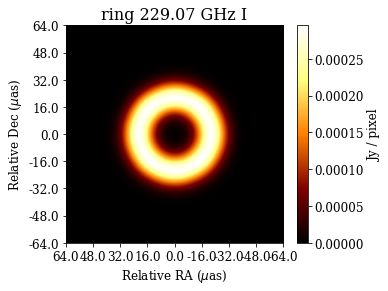

In [3]:
obs_sc = eh.obsdata.load_uvfits(current_path+r'/../synthetic_data/ring_eht2022_averaged.uvfits')
exact_solution = eh.image.load_fits(current_path+r'/../synthetic_data/ring.fits')

exact_solution.display()

res = obs_sc.res()

In [4]:
prior = eh.image.make_square(obs_sc, npix, fov) #prior image, make a prior image
prior = prior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0, 0, 0))

Again we define widths of the wavelets manually by powers of 2.

In [5]:
#------------------------------------------------------------------------------
# Prepare Minimization Procedure
#------------------------------------------------------------------------------
#threshold for identifying gaps in uv-coverage
threshold = 0.01*10**9
#specify widths of wavelezs manually
widths = np.array([1, 2, 4, 6, 8, 12, 16])
#the final handler for the minimization procedure
handler = MinimizationHandler(res, npix, fov, obs_sc, prior, zbl, rescaling, data_term, cbar_lims, threshold, [], [], widths=widths) 
#widths of wavelet filters
widths = handler.widths

Generating I image...
Generating I image...
Generating I image...
Generating I image...


The dirty image defines a proper first approximation to the true image structure and can be used as an initial guess. Moreover, we add a grid search for the best hard thresholds (proximal point operator of l0-penalty term is hard thresholding) per scale to minimize the objective functional of DoG-HiT (data fidelity term of closure quantities + l0 penalization on wavelets). This step finds a proper initial guess for the multiresolution support and helps global convergence, in particular for sparse arrays.

We use  5 scales with threshold 0.5
Current minimum 1639.1121793720504
Start optimization with thresholds [1.e+04 5.e-01 5.e-01 5.e-01 5.e-01 5.e-01 5.e-01]
reverse mode: True
Updated at scale 1 to threshold 0.0 to minimum 1277.4970144651813
Updated at scale 4 to threshold 1.0 to minimum 1250.7355732710005
We use thresholds:  [1.e+04 0.e+00 5.e-01 5.e-01 1.e+00 5.e-01 5.e-01]


2023-11-22 08:59:56,442 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 08:59:56,450 INFO Display              :: Penalty--> 1882.4050918261955
2023-11-22 08:59:56,771 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 08:59:56,779 INFO Display              :: Penalty--> 1830.12023147802
2023-11-22 08:59:57,077 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 08:59:57,077 INFO Display              :: Penalty--> 1820.5961197125146
2023-11-22 08:59:57,391 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 08:59:57,399 INFO Display              :: Penalty--> 1807.5253916054153
2023-11-22 08:59:57,707 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 08:59:57,715 INFO Display              :: Penalty--> 1791.6610623599408
2023-11-22 08:59:58,012 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 08:59:58,023 INFO Display              :: Penalty--> 1779.2436673159982
2023-11-22 08:59:58,317 INFO CountIterations      :: iteration = 7 / 25


311.9388460587337
Data Fidelity:  348.9173970403698


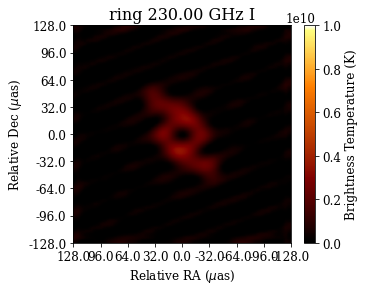

In [6]:
#Use dirty image as input image
img = obs_sc.dirtyimage(npix+1, fov)
data = handler.convert.ehtim_to_numpy(img)/rescaling

#Regularization parameters
alpha = 0.5
tau = 0.01

#Grid based search for best thresholds (l0 penalization) scale by scale 
init = handler.find_initial_guess(data, alpha)

#Define multiscalar weighting, flux transporting smoothing scale not supressed 
noise_levels = handler.noise_levels

wtfcts = handler.second_round(init, tau, alpha*noise_levels, maxiter=1, max_iterations=25, display=True)

reco = handler.op(wtfcts)
img = handler.wrapper.formatoutput(reco)

There is the shorter command handler.second_round_minimization that includes handler.find_initial_guess and handler.second_round for a more compact writing of the code. Again, we blur the image by the resolution and repeat the minimization to help global convergence.

We use  6 scales with threshold 4.0
Current minimum 1764.7457972198927
Start optimization with thresholds [4. 4. 4. 4. 4. 4. 4.]
reverse mode: True
Updated at scale 0 to threshold 7.5 to minimum 1741.8335007428018
Updated at scale 0 to threshold 8.0 to minimum 1628.5149156557197
Updated at scale 0 to threshold 8.5 to minimum 1622.8086108037594
Updated at scale 0 to threshold 9.5 to minimum 1599.6992568538128
Updated at scale 1 to threshold 7.0 to minimum 1598.8882743393353
Updated at scale 1 to threshold 7.5 to minimum 1588.0516870269596
Updated at scale 1 to threshold 8.0 to minimum 1454.3597940324219
Updated at scale 1 to threshold 9.0 to minimum 1449.8140447812443
Updated at scale 2 to threshold 4.5 to minimum 1427.8417120876782
Updated at scale 3 to threshold 2.5 to minimum 1411.7876059794557
Updated at scale 4 to threshold 4.5 to minimum 1399.025230455307
Updated at scale 5 to threshold 1.0 to minimum 1398.5876524368014
Updated at scale 5 to threshold 1.5 to minimum 1395.928394545

2023-11-22 09:01:01,875 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:01:01,883 INFO Display              :: Penalty--> 204.91862712564503
2023-11-22 09:01:02,188 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:01:02,188 INFO Display              :: Penalty--> 200.84300191308606
2023-11-22 09:01:02,493 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:01:02,501 INFO Display              :: Penalty--> 199.37210080181475
2023-11-22 09:01:02,790 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:01:02,798 INFO Display              :: Penalty--> 198.3026327515893
2023-11-22 09:01:03,095 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:01:03,095 INFO Display              :: Penalty--> 196.64020941569996
2023-11-22 09:01:03,394 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:01:03,402 INFO Display              :: Penalty--> 196.48699024892727
2023-11-22 09:01:03,700 INFO CountIterations      :: iteration = 7 / 25

1091.3963597661673
Data Fidelity:  218.87529244949815


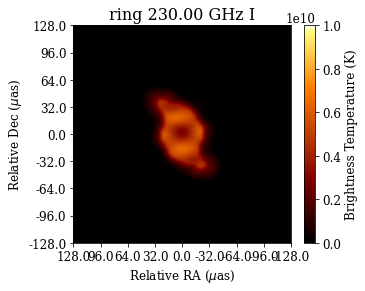

2023-11-22 09:01:10,189 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:01:10,193 INFO Display              :: Penalty--> 187.84850865296502
2023-11-22 09:01:10,508 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:01:10,508 INFO Display              :: Penalty--> 187.84850865296502
2023-11-22 09:01:10,805 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:01:10,814 INFO Display              :: Penalty--> 187.84850865296502
2023-11-22 09:01:11,111 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:01:11,119 INFO Display              :: Penalty--> 187.84850865296502
2023-11-22 09:01:11,409 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:01:11,417 INFO Display              :: Penalty--> 187.84850865296502
2023-11-22 09:01:11,731 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:01:11,731 INFO Display              :: Penalty--> 187.84850865296502
2023-11-22 09:01:12,046 INFO CountIterations      :: iteration = 7 / 2

2995.922507181892
Data Fidelity:  190.3023713483554


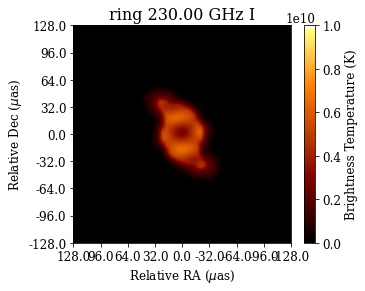

2023-11-22 09:01:18,626 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:01:18,627 INFO Display              :: Penalty--> 187.84850865296502
2023-11-22 09:01:18,931 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:01:18,931 INFO Display              :: Penalty--> 187.84850865296502
2023-11-22 09:01:19,250 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:01:19,253 INFO Display              :: Penalty--> 187.84850865296502
2023-11-22 09:01:19,559 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:01:19,567 INFO Display              :: Penalty--> 187.84850865296502
2023-11-22 09:01:19,882 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:01:19,889 INFO Display              :: Penalty--> 187.84850865296502
2023-11-22 09:01:20,195 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:01:20,203 INFO Display              :: Penalty--> 187.84850865296502
2023-11-22 09:01:20,517 INFO CountIterations      :: iteration = 7 / 2

2996.551162696477
Data Fidelity:  178.4365087418238


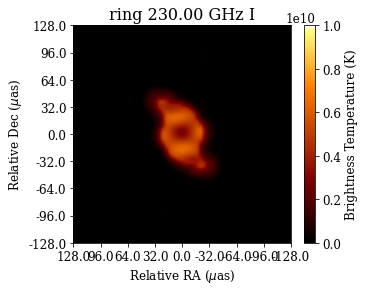

2023-11-22 09:01:27,169 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:01:27,169 INFO Display              :: Penalty--> 187.78722098625593
2023-11-22 09:01:27,481 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:01:27,481 INFO Display              :: Penalty--> 187.78722098625593
2023-11-22 09:01:27,802 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:01:27,810 INFO Display              :: Penalty--> 187.78722098625593
2023-11-22 09:01:28,109 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:01:28,119 INFO Display              :: Penalty--> 187.78722098625593
2023-11-22 09:01:28,407 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:01:28,407 INFO Display              :: Penalty--> 187.78722098625593
2023-11-22 09:01:28,704 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:01:28,712 INFO Display              :: Penalty--> 187.78722098625593
2023-11-22 09:01:29,001 INFO CountIterations      :: iteration = 7 / 2

2996.871125227077
Data Fidelity:  168.97919963358282


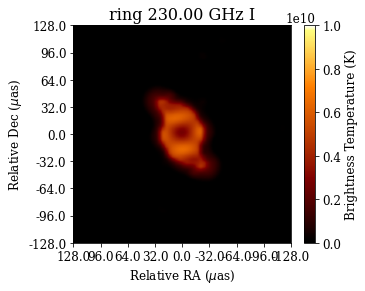

2023-11-22 09:01:35,608 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:01:35,608 INFO Display              :: Penalty--> 187.66311346117007
2023-11-22 09:01:35,907 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:01:35,907 INFO Display              :: Penalty--> 187.66311346117007
2023-11-22 09:01:36,213 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:01:36,213 INFO Display              :: Penalty--> 187.66311346117007
2023-11-22 09:01:36,518 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:01:36,518 INFO Display              :: Penalty--> 187.63246962781554
2023-11-22 09:01:36,841 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:01:36,841 INFO Display              :: Penalty--> 187.63246962781554
2023-11-22 09:01:37,147 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:01:37,155 INFO Display              :: Penalty--> 187.63246962781554
2023-11-22 09:01:37,452 INFO CountIterations      :: iteration = 7 / 2

2997.1205778584945
Data Fidelity:  161.1293866069217


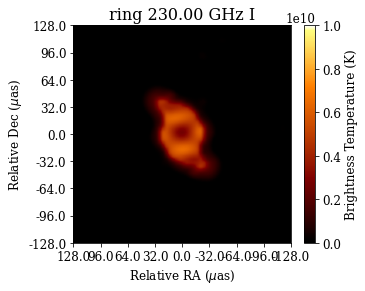

2023-11-22 09:01:44,054 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:01:44,062 INFO Display              :: Penalty--> 187.3857873472608
2023-11-22 09:01:44,376 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:01:44,381 INFO Display              :: Penalty--> 187.3857873472608
2023-11-22 09:01:44,707 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:01:44,707 INFO Display              :: Penalty--> 187.35514351390626
2023-11-22 09:01:45,033 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:01:45,033 INFO Display              :: Penalty--> 187.35514351390626
2023-11-22 09:01:45,344 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:01:45,352 INFO Display              :: Penalty--> 187.35514351390626
2023-11-22 09:01:45,658 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:01:45,666 INFO Display              :: Penalty--> 187.35514351390626
2023-11-22 09:01:45,973 INFO CountIterations      :: iteration = 7 / 25


2997.301590682626
Data Fidelity:  154.49550135895768


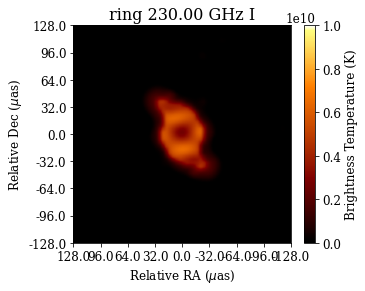

2023-11-22 09:01:52,805 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:01:52,805 INFO Display              :: Penalty--> 187.25401886383628
2023-11-22 09:01:53,110 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:01:53,110 INFO Display              :: Penalty--> 187.25401886383628
2023-11-22 09:01:53,416 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:01:53,416 INFO Display              :: Penalty--> 187.25401886383628
2023-11-22 09:01:53,723 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:01:53,731 INFO Display              :: Penalty--> 187.23563256382357
2023-11-22 09:01:54,036 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:01:54,036 INFO Display              :: Penalty--> 187.23563256382357
2023-11-22 09:01:54,336 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:01:54,344 INFO Display              :: Penalty--> 187.20498873046904
2023-11-22 09:01:54,649 INFO CountIterations      :: iteration = 7 / 2

2997.4752245778627
Data Fidelity:  148.67680875348245


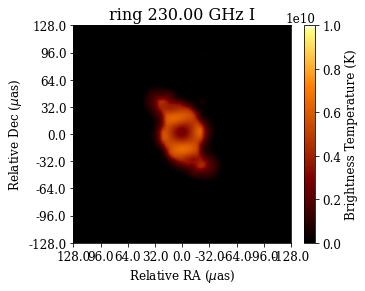

2023-11-22 09:02:01,231 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:02:01,235 INFO Display              :: Penalty--> 187.10233188873136
2023-11-22 09:02:01,524 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:02:01,532 INFO Display              :: Penalty--> 187.09160654705727
2023-11-22 09:02:01,831 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:02:01,836 INFO Display              :: Penalty--> 187.09160654705727
2023-11-22 09:02:02,138 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:02:02,146 INFO Display              :: Penalty--> 187.08088120538318
2023-11-22 09:02:02,452 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:02:02,459 INFO Display              :: Penalty--> 187.08088120538318
2023-11-22 09:02:02,766 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:02:02,774 INFO Display              :: Penalty--> 187.08088120538318
2023-11-22 09:02:03,080 INFO CountIterations      :: iteration = 7 / 2

2997.676031893363
Data Fidelity:  143.52270421763725


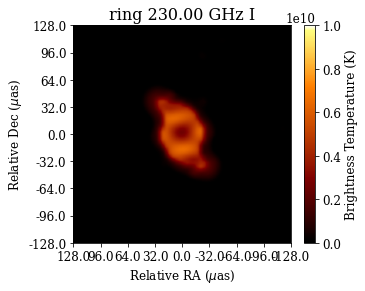

2023-11-22 09:02:09,776 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:02:09,776 INFO Display              :: Penalty--> 186.98894970531958
2023-11-22 09:02:10,098 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:02:10,098 INFO Display              :: Penalty--> 186.98894970531958
2023-11-22 09:02:10,412 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:02:10,420 INFO Display              :: Penalty--> 186.98894970531958
2023-11-22 09:02:10,728 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:02:10,728 INFO Display              :: Penalty--> 186.98894970531958
2023-11-22 09:02:11,029 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:02:11,034 INFO Display              :: Penalty--> 186.98894970531958
2023-11-22 09:02:11,317 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:02:11,325 INFO Display              :: Penalty--> 186.98894970531958
2023-11-22 09:02:11,630 INFO CountIterations      :: iteration = 7 / 2

2997.8398755494727
Data Fidelity:  138.75622477232548


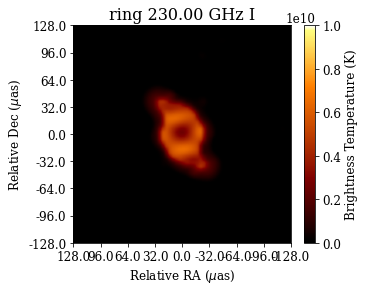

2023-11-22 09:02:18,198 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:02:18,204 INFO Display              :: Penalty--> 186.4434912054567
2023-11-22 09:02:18,501 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:02:18,501 INFO Display              :: Penalty--> 186.4434912054567
2023-11-22 09:02:18,798 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:02:18,806 INFO Display              :: Penalty--> 186.4434912054567
2023-11-22 09:02:19,111 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:02:19,116 INFO Display              :: Penalty--> 186.4434912054567
2023-11-22 09:02:19,417 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:02:19,425 INFO Display              :: Penalty--> 186.41284737210214
2023-11-22 09:02:19,711 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:02:19,716 INFO Display              :: Penalty--> 186.41284737210214
2023-11-22 09:02:20,005 INFO CountIterations      :: iteration = 7 / 25
20

2997.958233034953
Data Fidelity:  134.4792888553465


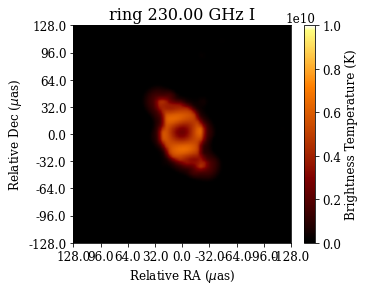

2023-11-22 09:02:26,432 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:02:26,432 INFO Display              :: Penalty--> 186.08342674149017
2023-11-22 09:02:26,724 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:02:26,728 INFO Display              :: Penalty--> 186.05278290813564
2023-11-22 09:02:27,009 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:02:27,017 INFO Display              :: Penalty--> 186.05278290813564
2023-11-22 09:02:27,331 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:02:27,331 INFO Display              :: Penalty--> 186.05278290813564
2023-11-22 09:02:27,637 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:02:27,637 INFO Display              :: Penalty--> 186.02213907478108
2023-11-22 09:02:27,944 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:02:27,952 INFO Display              :: Penalty--> 186.02213907478108
2023-11-22 09:02:28,250 INFO CountIterations      :: iteration = 7 / 2

2998.071715650279
Data Fidelity:  130.59033216577927


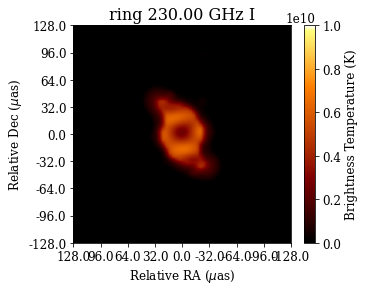

2023-11-22 09:02:34,998 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:02:35,002 INFO Display              :: Penalty--> 185.93020757471749
2023-11-22 09:02:35,314 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:02:35,325 INFO Display              :: Penalty--> 185.93020757471749
2023-11-22 09:02:35,613 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:02:35,625 INFO Display              :: Penalty--> 185.93020757471749
2023-11-22 09:02:35,927 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:02:35,935 INFO Display              :: Penalty--> 185.93020757471749
2023-11-22 09:02:36,239 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:02:36,248 INFO Display              :: Penalty--> 185.93020757471749
2023-11-22 09:02:36,562 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:02:36,562 INFO Display              :: Penalty--> 185.93020757471749
2023-11-22 09:02:36,861 INFO CountIterations      :: iteration = 7 / 2

2998.180279290912
Data Fidelity:  127.02368217568889


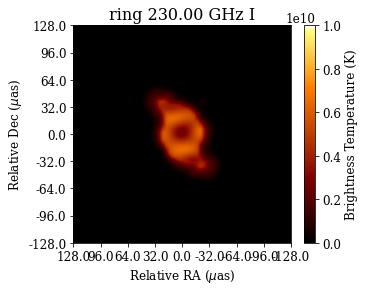

2023-11-22 09:02:43,389 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:02:43,389 INFO Display              :: Penalty--> 185.89956374136295
2023-11-22 09:02:43,688 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:02:43,696 INFO Display              :: Penalty--> 185.89956374136295
2023-11-22 09:02:43,995 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:02:44,003 INFO Display              :: Penalty--> 185.89956374136295
2023-11-22 09:02:44,300 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:02:44,308 INFO Display              :: Penalty--> 185.86891990800842
2023-11-22 09:02:44,606 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:02:44,614 INFO Display              :: Penalty--> 185.86891990800842
2023-11-22 09:02:44,912 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:02:44,920 INFO Display              :: Penalty--> 185.86891990800842
2023-11-22 09:02:45,210 INFO CountIterations      :: iteration = 7 / 2

2998.2234484207033
Data Fidelity:  123.60595770017008


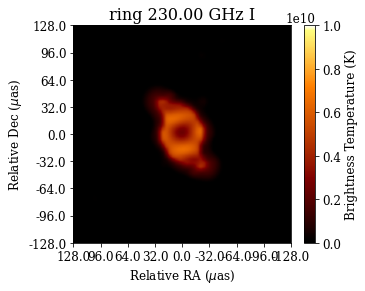

2023-11-22 09:02:51,656 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:02:51,664 INFO Display              :: Penalty--> 185.46901903863028
2023-11-22 09:02:51,954 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:02:51,962 INFO Display              :: Penalty--> 185.43837520527575
2023-11-22 09:02:52,258 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:02:52,258 INFO Display              :: Penalty--> 185.43837520527575
2023-11-22 09:02:52,562 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:02:52,562 INFO Display              :: Penalty--> 185.43071424693713
2023-11-22 09:02:52,858 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:02:52,866 INFO Display              :: Penalty--> 185.42305328859848
2023-11-22 09:02:53,180 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:02:53,180 INFO Display              :: Penalty--> 185.42305328859848
2023-11-22 09:02:53,486 INFO CountIterations      :: iteration = 7 / 2

2998.380947105986
Data Fidelity:  120.44366804432791


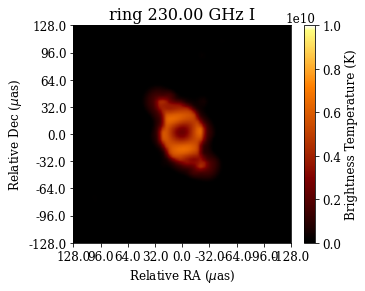

2023-11-22 09:02:59,931 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:02:59,939 INFO Display              :: Penalty--> 185.33112178853486
2023-11-22 09:03:00,244 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:03:00,244 INFO Display              :: Penalty--> 185.30047795518033
2023-11-22 09:03:00,549 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:03:00,549 INFO Display              :: Penalty--> 185.30047795518033
2023-11-22 09:03:00,838 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:03:00,846 INFO Display              :: Penalty--> 185.30047795518033
2023-11-22 09:03:01,151 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:03:01,159 INFO Display              :: Penalty--> 185.30047795518033
2023-11-22 09:03:01,455 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:03:01,466 INFO Display              :: Penalty--> 185.30047795518033
2023-11-22 09:03:01,752 INFO CountIterations      :: iteration = 7 / 2

2998.422648499174
Data Fidelity:  117.5036293609937


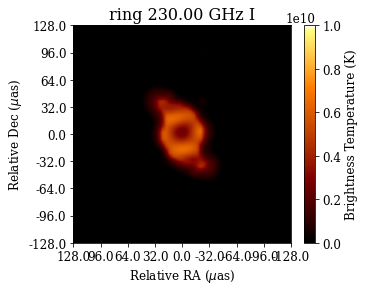

2023-11-22 09:03:08,108 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:03:08,108 INFO Display              :: Penalty--> 185.27902727183215
2023-11-22 09:03:08,403 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:03:08,411 INFO Display              :: Penalty--> 185.27902727183215
2023-11-22 09:03:08,709 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:03:08,709 INFO Display              :: Penalty--> 185.27902727183215
2023-11-22 09:03:09,015 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:03:09,023 INFO Display              :: Penalty--> 185.27902727183215
2023-11-22 09:03:09,336 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:03:09,338 INFO Display              :: Penalty--> 185.11355114966693
2023-11-22 09:03:09,644 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:03:09,644 INFO Display              :: Penalty--> 185.11355114966693
2023-11-22 09:03:09,942 INFO CountIterations      :: iteration = 7 / 2

2998.4851597676916
Data Fidelity:  114.69577206010753


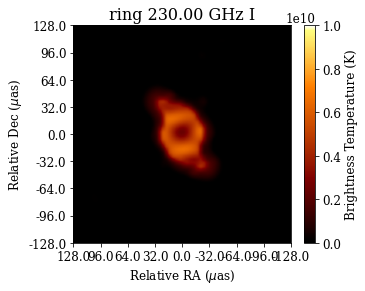

2023-11-22 09:03:16,328 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:03:16,336 INFO Display              :: Penalty--> 185.05226348295787
2023-11-22 09:03:16,627 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:03:16,627 INFO Display              :: Penalty--> 185.05226348295787
2023-11-22 09:03:16,933 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:03:16,941 INFO Display              :: Penalty--> 185.05226348295787
2023-11-22 09:03:17,244 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:03:17,244 INFO Display              :: Penalty--> 185.05226348295787
2023-11-22 09:03:17,552 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:03:17,560 INFO Display              :: Penalty--> 185.05226348295787
2023-11-22 09:03:17,850 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:03:17,850 INFO Display              :: Penalty--> 185.05226348295787
2023-11-22 09:03:18,157 INFO CountIterations      :: iteration = 7 / 2

2998.535902886747
Data Fidelity:  112.06733579968422


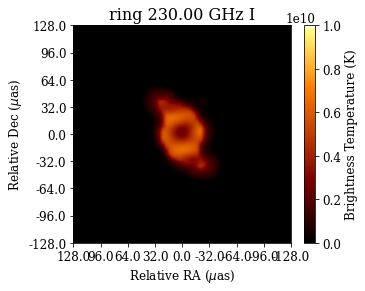

2023-11-22 09:03:24,541 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:03:24,550 INFO Display              :: Penalty--> 184.9725895162361
2023-11-22 09:03:24,854 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:03:24,854 INFO Display              :: Penalty--> 184.9725895162361
2023-11-22 09:03:25,159 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:03:25,167 INFO Display              :: Penalty--> 184.961864174562
2023-11-22 09:03:25,457 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:03:25,465 INFO Display              :: Penalty--> 184.961864174562
2023-11-22 09:03:25,770 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:03:25,770 INFO Display              :: Penalty--> 184.93122034120745
2023-11-22 09:03:26,067 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:03:26,075 INFO Display              :: Penalty--> 184.93122034120745
2023-11-22 09:03:26,388 INFO CountIterations      :: iteration = 7 / 25
2023

2998.5720143606623
Data Fidelity:  109.57960036144729


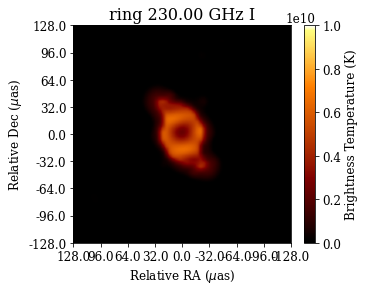

2023-11-22 09:03:32,744 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:03:32,744 INFO Display              :: Penalty--> 184.93122034120745
2023-11-22 09:03:33,043 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:03:33,051 INFO Display              :: Penalty--> 184.93122034120745
2023-11-22 09:03:33,332 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:03:33,340 INFO Display              :: Penalty--> 184.93122034120745
2023-11-22 09:03:33,629 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:03:33,629 INFO Display              :: Penalty--> 184.93122034120745
2023-11-22 09:03:33,942 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:03:33,942 INFO Display              :: Penalty--> 184.93122034120745
2023-11-22 09:03:34,238 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:03:34,238 INFO Display              :: Penalty--> 184.93122034120745
2023-11-22 09:03:34,541 INFO CountIterations      :: iteration = 7 / 2

2998.6095147361953
Data Fidelity:  107.20681922082518


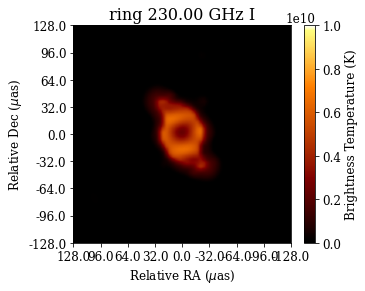

2023-11-22 09:03:41,003 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:03:41,003 INFO Display              :: Penalty--> 184.89291554951427
2023-11-22 09:03:41,293 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:03:41,293 INFO Display              :: Penalty--> 184.89291554951427
2023-11-22 09:03:41,582 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:03:41,590 INFO Display              :: Penalty--> 184.89291554951427
2023-11-22 09:03:41,903 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:03:41,911 INFO Display              :: Penalty--> 184.89291554951427
2023-11-22 09:03:42,216 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:03:42,216 INFO Display              :: Penalty--> 184.89291554951427
2023-11-22 09:03:42,512 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:03:42,515 INFO Display              :: Penalty--> 184.89291554951427
2023-11-22 09:03:42,816 INFO CountIterations      :: iteration = 7 / 2

2998.6563882711016
Data Fidelity:  104.90519063583056


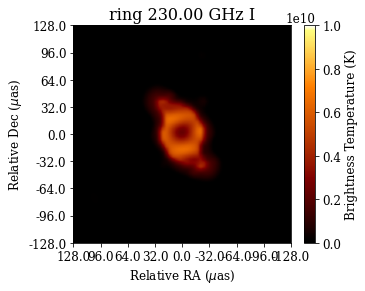

2023-11-22 09:03:49,216 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:03:49,224 INFO Display              :: Penalty--> 184.6554264189659
2023-11-22 09:03:49,538 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:03:49,538 INFO Display              :: Penalty--> 184.6554264189659
2023-11-22 09:03:49,859 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:03:49,867 INFO Display              :: Penalty--> 184.6554264189659
2023-11-22 09:03:50,164 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:03:50,172 INFO Display              :: Penalty--> 184.62478258561137
2023-11-22 09:03:50,477 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:03:50,477 INFO Display              :: Penalty--> 184.62478258561137
2023-11-22 09:03:50,797 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:03:50,805 INFO Display              :: Penalty--> 184.62478258561137
2023-11-22 09:03:51,119 INFO CountIterations      :: iteration = 7 / 25
2

2998.6530536208775
Data Fidelity:  102.747777286872


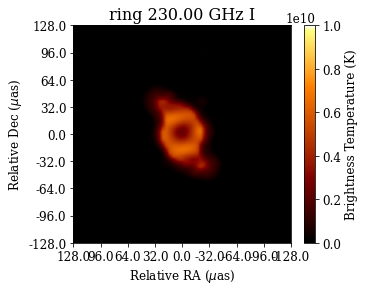

2023-11-22 09:03:57,763 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:03:57,763 INFO Display              :: Penalty--> 184.59413875225684
2023-11-22 09:03:58,086 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:03:58,094 INFO Display              :: Penalty--> 184.59413875225684
2023-11-22 09:03:58,391 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:03:58,399 INFO Display              :: Penalty--> 184.59413875225684
2023-11-22 09:03:58,705 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:03:58,705 INFO Display              :: Penalty--> 184.59413875225684
2023-11-22 09:03:59,018 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:03:59,018 INFO Display              :: Penalty--> 184.59413875225684
2023-11-22 09:03:59,323 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:03:59,334 INFO Display              :: Penalty--> 184.59413875225684
2023-11-22 09:03:59,634 INFO CountIterations      :: iteration = 7 / 2

2998.682017379617
Data Fidelity:  100.67998758234245


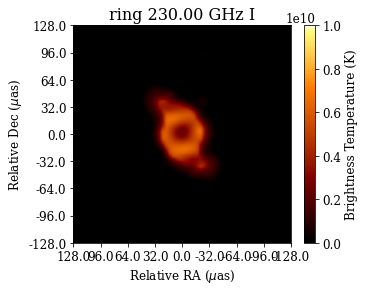

2023-11-22 09:04:06,412 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:04:06,420 INFO Display              :: Penalty--> 184.5221257438737
2023-11-22 09:04:06,718 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:04:06,718 INFO Display              :: Penalty--> 184.5221257438737
2023-11-22 09:04:07,032 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:04:07,042 INFO Display              :: Penalty--> 184.5221257438737
2023-11-22 09:04:07,347 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:04:07,347 INFO Display              :: Penalty--> 184.5221257438737
2023-11-22 09:04:07,659 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:04:07,659 INFO Display              :: Penalty--> 184.5221257438737
2023-11-22 09:04:07,967 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:04:07,967 INFO Display              :: Penalty--> 184.5221257438737
2023-11-22 09:04:08,284 INFO CountIterations      :: iteration = 7 / 25
2023

2998.7022211771923
Data Fidelity:  98.69607897671582


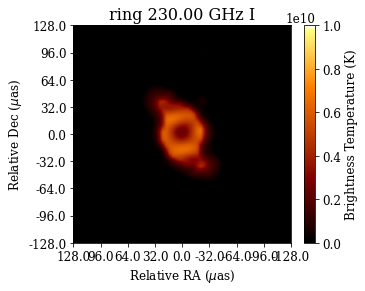

2023-11-22 09:04:14,671 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:04:14,671 INFO Display              :: Penalty--> 184.5221257438737
2023-11-22 09:04:14,952 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:04:14,960 INFO Display              :: Penalty--> 184.5221257438737
2023-11-22 09:04:15,252 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:04:15,258 INFO Display              :: Penalty--> 184.5221257438737
2023-11-22 09:04:15,541 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:04:15,549 INFO Display              :: Penalty--> 184.5221257438737
2023-11-22 09:04:15,839 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:04:15,842 INFO Display              :: Penalty--> 184.5221257438737
2023-11-22 09:04:16,145 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:04:16,154 INFO Display              :: Penalty--> 184.5221257438737
2023-11-22 09:04:16,454 INFO CountIterations      :: iteration = 7 / 25
2023

2998.7172986468404
Data Fidelity:  96.78992773194187


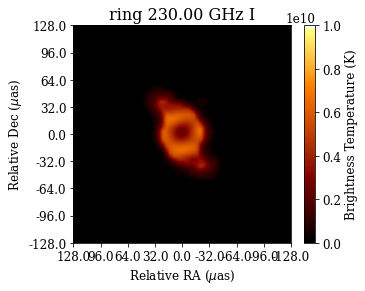

2023-11-22 09:04:22,881 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:04:22,881 INFO Display              :: Penalty--> 184.49148191051916
2023-11-22 09:04:23,187 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:04:23,195 INFO Display              :: Penalty--> 184.49148191051916
2023-11-22 09:04:23,500 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:04:23,500 INFO Display              :: Penalty--> 184.49148191051916
2023-11-22 09:04:23,796 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:04:23,804 INFO Display              :: Penalty--> 184.49148191051916
2023-11-22 09:04:24,069 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:04:24,077 INFO Display              :: Penalty--> 184.4608380771646
2023-11-22 09:04:24,375 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:04:24,383 INFO Display              :: Penalty--> 184.4608380771646
2023-11-22 09:04:24,673 INFO CountIterations      :: iteration = 7 / 25


2998.7303862229573
Data Fidelity:  94.94029106953764


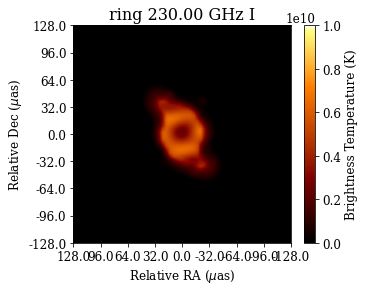

2023-11-22 09:04:30,877 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:04:30,877 INFO Display              :: Penalty--> 184.26471812164485
2023-11-22 09:04:31,159 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:04:31,168 INFO Display              :: Penalty--> 184.26471812164485
2023-11-22 09:04:31,474 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:04:31,474 INFO Display              :: Penalty--> 184.26471812164485
2023-11-22 09:04:31,769 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:04:31,777 INFO Display              :: Penalty--> 184.26471812164485
2023-11-22 09:04:32,074 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:04:32,074 INFO Display              :: Penalty--> 184.26471812164485
2023-11-22 09:04:32,386 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:04:32,394 INFO Display              :: Penalty--> 184.26471812164485
2023-11-22 09:04:32,676 INFO CountIterations      :: iteration = 7 / 2

2998.7416812495894
Data Fidelity:  93.15925270381987


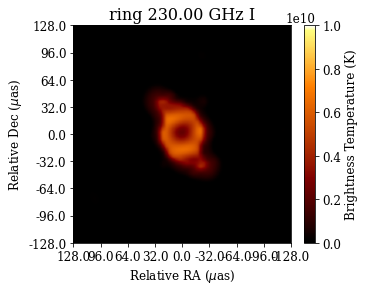

2023-11-22 09:04:39,179 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:04:39,179 INFO Display              :: Penalty--> 184.04714748277692
2023-11-22 09:04:39,460 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:04:39,468 INFO Display              :: Penalty--> 184.04714748277692
2023-11-22 09:04:39,789 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:04:39,797 INFO Display              :: Penalty--> 184.04714748277692
2023-11-22 09:04:40,110 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:04:40,118 INFO Display              :: Penalty--> 184.04714748277692
2023-11-22 09:04:40,405 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:04:40,408 INFO Display              :: Penalty--> 184.04714748277692
2023-11-22 09:04:40,680 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:04:40,688 INFO Display              :: Penalty--> 184.0165036494224
2023-11-22 09:04:40,970 INFO CountIterations      :: iteration = 7 / 25

2998.7542787640573
Data Fidelity:  91.43171687357045


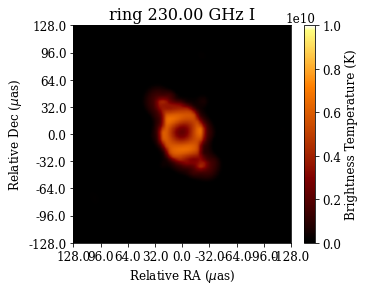

2023-11-22 09:04:47,397 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:04:47,397 INFO Display              :: Penalty--> 183.7897398605481
2023-11-22 09:04:47,679 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:04:47,687 INFO Display              :: Penalty--> 183.7897398605481
2023-11-22 09:04:47,970 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:04:47,977 INFO Display              :: Penalty--> 183.7897398605481
2023-11-22 09:04:48,267 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:04:48,275 INFO Display              :: Penalty--> 183.7897398605481
2023-11-22 09:04:48,575 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:04:48,575 INFO Display              :: Penalty--> 183.7897398605481
2023-11-22 09:04:48,889 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:04:48,894 INFO Display              :: Penalty--> 183.7897398605481
2023-11-22 09:04:49,186 INFO CountIterations      :: iteration = 7 / 25
2023

2998.740943357033
Data Fidelity:  89.76292741192574


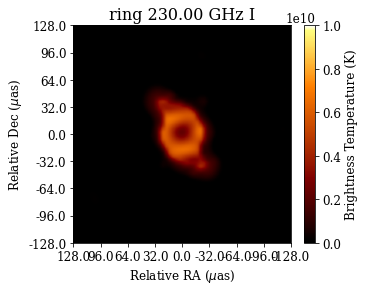

2023-11-22 09:04:55,580 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:04:55,588 INFO Display              :: Penalty--> 183.4710445716102
2023-11-22 09:04:55,883 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:04:55,887 INFO Display              :: Penalty--> 183.4710445716102
2023-11-22 09:04:56,176 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:04:56,176 INFO Display              :: Penalty--> 183.4710445716102
2023-11-22 09:04:56,485 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:04:56,491 INFO Display              :: Penalty--> 183.4710445716102
2023-11-22 09:04:56,765 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:04:56,765 INFO Display              :: Penalty--> 183.4710445716102
2023-11-22 09:04:57,055 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:04:57,055 INFO Display              :: Penalty--> 183.4710445716102
2023-11-22 09:04:57,360 INFO CountIterations      :: iteration = 7 / 25
2023

2998.763027882761
Data Fidelity:  88.15943818021937


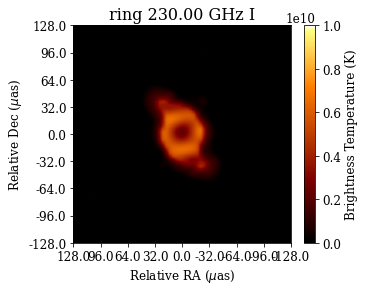

2023-11-22 09:05:03,681 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:05:03,689 INFO Display              :: Penalty--> 183.24428078273593
2023-11-22 09:05:03,980 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:05:03,984 INFO Display              :: Penalty--> 183.24428078273593
2023-11-22 09:05:04,285 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:05:04,285 INFO Display              :: Penalty--> 183.24428078273593
2023-11-22 09:05:04,582 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:05:04,590 INFO Display              :: Penalty--> 183.24428078273593
2023-11-22 09:05:04,887 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:05:04,887 INFO Display              :: Penalty--> 183.24428078273593
2023-11-22 09:05:05,193 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:05:05,193 INFO Display              :: Penalty--> 183.24428078273593
2023-11-22 09:05:05,459 INFO CountIterations      :: iteration = 7 / 2

2998.7593964429007
Data Fidelity:  86.65756495484922


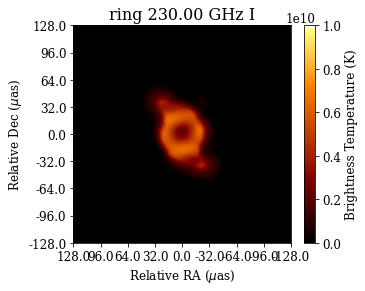

2023-11-22 09:05:11,845 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:05:11,853 INFO Display              :: Penalty--> 183.24428078273593
2023-11-22 09:05:12,126 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:05:12,126 INFO Display              :: Penalty--> 183.24428078273593
2023-11-22 09:05:12,423 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:05:12,423 INFO Display              :: Penalty--> 183.24428078273593
2023-11-22 09:05:12,719 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:05:12,727 INFO Display              :: Penalty--> 183.24428078273593
2023-11-22 09:05:13,024 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:05:13,032 INFO Display              :: Penalty--> 183.24428078273593
2023-11-22 09:05:13,319 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:05:13,321 INFO Display              :: Penalty--> 183.24428078273593
2023-11-22 09:05:13,620 INFO CountIterations      :: iteration = 7 / 2

2998.756614538405
Data Fidelity:  85.18613860291427


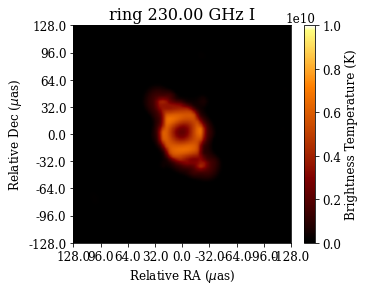

2023-11-22 09:05:19,999 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:05:20,007 INFO Display              :: Penalty--> 183.0788046605707
2023-11-22 09:05:20,305 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:05:20,313 INFO Display              :: Penalty--> 183.0788046605707
2023-11-22 09:05:20,615 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:05:20,619 INFO Display              :: Penalty--> 183.0788046605707
2023-11-22 09:05:20,907 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:05:20,907 INFO Display              :: Penalty--> 183.0788046605707
2023-11-22 09:05:21,212 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:05:21,212 INFO Display              :: Penalty--> 183.0788046605707
2023-11-22 09:05:21,493 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:05:21,501 INFO Display              :: Penalty--> 183.0788046605707
2023-11-22 09:05:21,788 INFO CountIterations      :: iteration = 7 / 25
2023

2998.7553493786418
Data Fidelity:  83.775685053194


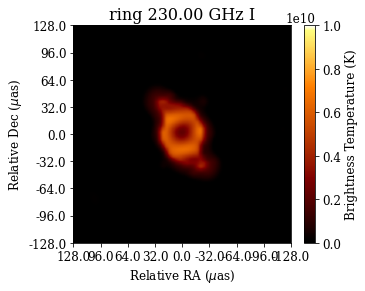

2023-11-22 09:05:28,231 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:05:28,235 INFO Display              :: Penalty--> 183.0788046605707
2023-11-22 09:05:28,537 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:05:28,540 INFO Display              :: Penalty--> 183.0788046605707
2023-11-22 09:05:28,828 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:05:28,828 INFO Display              :: Penalty--> 183.0788046605707
2023-11-22 09:05:29,140 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:05:29,148 INFO Display              :: Penalty--> 183.0788046605707
2023-11-22 09:05:29,461 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:05:29,461 INFO Display              :: Penalty--> 183.0788046605707
2023-11-22 09:05:29,767 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:05:29,775 INFO Display              :: Penalty--> 183.0788046605707
2023-11-22 09:05:30,074 INFO CountIterations      :: iteration = 7 / 25
2023

2998.7519152853047
Data Fidelity:  82.4055393028316


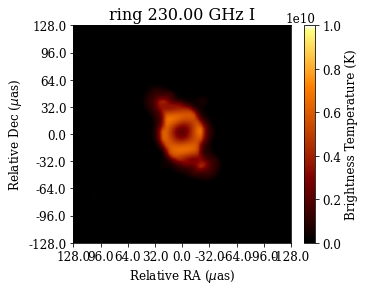

2023-11-22 09:05:36,996 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:05:36,996 INFO Display              :: Penalty--> 183.0788046605707
2023-11-22 09:05:37,388 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:05:37,396 INFO Display              :: Penalty--> 183.0788046605707
2023-11-22 09:05:37,797 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:05:37,805 INFO Display              :: Penalty--> 183.0788046605707
2023-11-22 09:05:38,159 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:05:38,167 INFO Display              :: Penalty--> 183.0788046605707
2023-11-22 09:05:38,520 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:05:38,528 INFO Display              :: Penalty--> 183.0788046605707
2023-11-22 09:05:38,923 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:05:38,931 INFO Display              :: Penalty--> 183.0788046605707
2023-11-22 09:05:39,315 INFO CountIterations      :: iteration = 7 / 25
2023

2998.7607168661643
Data Fidelity:  81.0671718863695


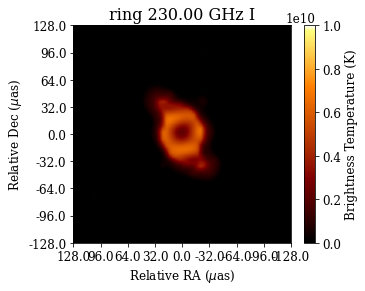

2023-11-22 09:05:47,347 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:05:47,356 INFO Display              :: Penalty--> 183.0374354855421
2023-11-22 09:05:47,737 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:05:47,745 INFO Display              :: Penalty--> 183.0374354855421
2023-11-22 09:05:48,121 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:05:48,126 INFO Display              :: Penalty--> 183.0374354855421
2023-11-22 09:05:48,494 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:05:48,502 INFO Display              :: Penalty--> 183.0374354855421
2023-11-22 09:05:48,877 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:05:48,882 INFO Display              :: Penalty--> 183.0374354855421
2023-11-22 09:05:49,232 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:05:49,232 INFO Display              :: Penalty--> 183.0374354855421
2023-11-22 09:05:49,596 INFO CountIterations      :: iteration = 7 / 25
2023

2998.7395942393605
Data Fidelity:  79.77080153095254


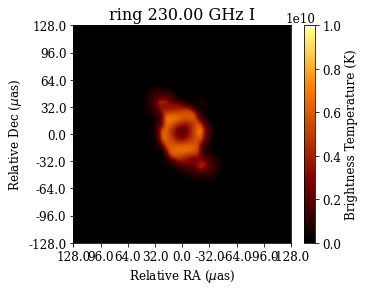

2023-11-22 09:05:57,509 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:05:57,511 INFO Display              :: Penalty--> 183.0374354855421
2023-11-22 09:05:57,890 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:05:57,898 INFO Display              :: Penalty--> 183.0374354855421
2023-11-22 09:05:58,299 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:05:58,299 INFO Display              :: Penalty--> 183.0374354855421
2023-11-22 09:05:58,694 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:05:58,702 INFO Display              :: Penalty--> 183.0374354855421
2023-11-22 09:05:59,050 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:05:59,058 INFO Display              :: Penalty--> 183.0374354855421
2023-11-22 09:05:59,437 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:05:59,437 INFO Display              :: Penalty--> 183.0374354855421
2023-11-22 09:05:59,850 INFO CountIterations      :: iteration = 7 / 25
2023

2998.737853367824
Data Fidelity:  78.5052212859362


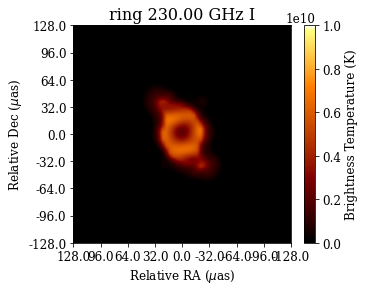

2023-11-22 09:06:07,736 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:06:07,744 INFO Display              :: Penalty--> 182.97614781883303
2023-11-22 09:06:08,099 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:06:08,107 INFO Display              :: Penalty--> 182.97614781883303
2023-11-22 09:06:08,469 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:06:08,478 INFO Display              :: Penalty--> 182.97614781883303
2023-11-22 09:06:08,842 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:06:08,850 INFO Display              :: Penalty--> 182.9455039854785
2023-11-22 09:06:09,204 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:06:09,212 INFO Display              :: Penalty--> 182.9455039854785
2023-11-22 09:06:09,590 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:06:09,594 INFO Display              :: Penalty--> 182.9455039854785
2023-11-22 09:06:09,966 INFO CountIterations      :: iteration = 7 / 25
2

2998.733776065749
Data Fidelity:  77.25627417846152


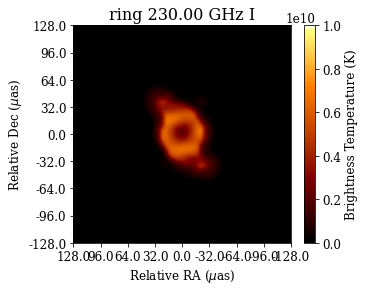

2023-11-22 09:06:17,882 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:06:17,882 INFO Display              :: Penalty--> 182.8842163187694
2023-11-22 09:06:18,230 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:06:18,238 INFO Display              :: Penalty--> 182.8842163187694
2023-11-22 09:06:18,622 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:06:18,626 INFO Display              :: Penalty--> 182.8842163187694
2023-11-22 09:06:18,996 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:06:19,006 INFO Display              :: Penalty--> 182.8842163187694
2023-11-22 09:06:19,352 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:06:19,356 INFO Display              :: Penalty--> 182.8842163187694
2023-11-22 09:06:19,741 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:06:19,741 INFO Display              :: Penalty--> 182.8842163187694
2023-11-22 09:06:20,111 INFO CountIterations      :: iteration = 7 / 25
2023

2998.7306050404222
Data Fidelity:  76.05461361875888


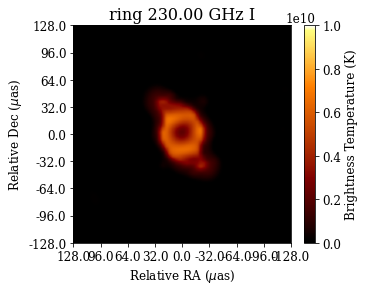

2023-11-22 09:06:28,150 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:06:28,150 INFO Display              :: Penalty--> 182.85357248541487
2023-11-22 09:06:28,524 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:06:28,524 INFO Display              :: Penalty--> 182.85357248541487
2023-11-22 09:06:28,910 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:06:28,918 INFO Display              :: Penalty--> 182.85357248541487
2023-11-22 09:06:29,320 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:06:29,328 INFO Display              :: Penalty--> 182.68809636324966
2023-11-22 09:06:29,696 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:06:29,704 INFO Display              :: Penalty--> 182.68809636324966
2023-11-22 09:06:30,067 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:06:30,067 INFO Display              :: Penalty--> 182.68809636324966
2023-11-22 09:06:30,370 INFO CountIterations      :: iteration = 7 / 2

2998.7229560922306
Data Fidelity:  74.86949983395732


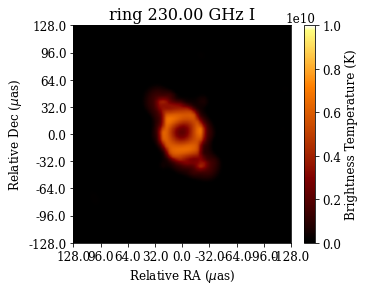

2023-11-22 09:06:38,140 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:06:38,148 INFO Display              :: Penalty--> 182.65745252989512
2023-11-22 09:06:38,509 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:06:38,517 INFO Display              :: Penalty--> 182.65745252989512
2023-11-22 09:06:38,871 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:06:38,879 INFO Display              :: Penalty--> 182.65745252989512
2023-11-22 09:06:39,202 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:06:39,210 INFO Display              :: Penalty--> 182.65745252989512
2023-11-22 09:06:39,596 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:06:39,604 INFO Display              :: Penalty--> 182.4919764077299
2023-11-22 09:06:39,988 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:06:39,996 INFO Display              :: Penalty--> 182.4919764077299
2023-11-22 09:06:40,381 INFO CountIterations      :: iteration = 7 / 25


2998.7245758389554
Data Fidelity:  73.71835048982155


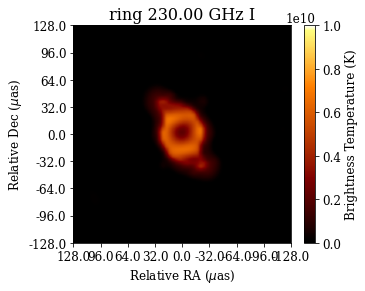

2023-11-22 09:06:48,182 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:06:48,182 INFO Display              :: Penalty--> 182.46133257437538
2023-11-22 09:06:48,536 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:06:48,540 INFO Display              :: Penalty--> 182.46133257437538
2023-11-22 09:06:48,861 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:06:48,869 INFO Display              :: Penalty--> 182.46133257437538
2023-11-22 09:06:49,226 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:06:49,234 INFO Display              :: Penalty--> 182.46133257437538
2023-11-22 09:06:49,575 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:06:49,584 INFO Display              :: Penalty--> 182.46133257437538
2023-11-22 09:06:49,958 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:06:49,958 INFO Display              :: Penalty--> 182.46133257437538
2023-11-22 09:06:50,329 INFO CountIterations      :: iteration = 7 / 2

2998.727445421193
Data Fidelity:  72.59808883786656


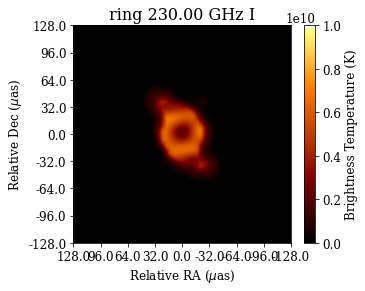

2023-11-22 09:06:57,366 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:06:57,368 INFO Display              :: Penalty--> 182.4000449076663
2023-11-22 09:06:57,682 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:06:57,690 INFO Display              :: Penalty--> 182.4000449076663
2023-11-22 09:06:57,980 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:06:57,988 INFO Display              :: Penalty--> 182.4000449076663
2023-11-22 09:06:58,262 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:06:58,270 INFO Display              :: Penalty--> 182.4000449076663
2023-11-22 09:06:58,539 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:06:58,545 INFO Display              :: Penalty--> 182.4000449076663
2023-11-22 09:06:58,841 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:06:58,849 INFO Display              :: Penalty--> 182.4000449076663
2023-11-22 09:06:59,162 INFO CountIterations      :: iteration = 7 / 25
2023

2998.7231208574094
Data Fidelity:  71.50176931474522


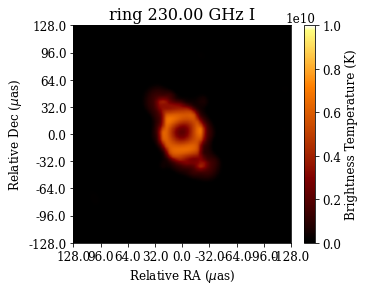

2023-11-22 09:07:05,486 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:07:05,486 INFO Display              :: Penalty--> 182.32803189928313
2023-11-22 09:07:05,776 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:07:05,784 INFO Display              :: Penalty--> 182.32803189928313
2023-11-22 09:07:06,072 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:07:06,072 INFO Display              :: Penalty--> 182.2973880659286
2023-11-22 09:07:06,354 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:07:06,362 INFO Display              :: Penalty--> 182.2973880659286
2023-11-22 09:07:06,659 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:07:06,667 INFO Display              :: Penalty--> 182.2973880659286
2023-11-22 09:07:06,964 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:07:06,964 INFO Display              :: Penalty--> 182.2973880659286
2023-11-22 09:07:07,248 INFO CountIterations      :: iteration = 7 / 25
20

2998.706448672167
Data Fidelity:  70.43546542456153


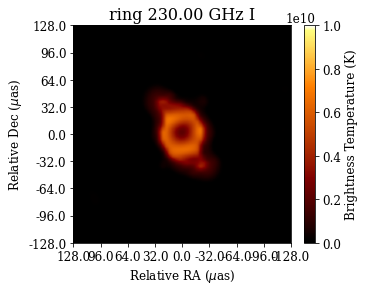

2023-11-22 09:07:13,516 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:07:13,516 INFO Display              :: Penalty--> 182.26674423257407
2023-11-22 09:07:13,797 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:07:13,805 INFO Display              :: Penalty--> 182.26674423257407
2023-11-22 09:07:14,102 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:07:14,102 INFO Display              :: Penalty--> 182.26674423257407
2023-11-22 09:07:14,407 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:07:14,407 INFO Display              :: Penalty--> 182.26674423257407
2023-11-22 09:07:14,688 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:07:14,688 INFO Display              :: Penalty--> 182.26674423257407
2023-11-22 09:07:15,001 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:07:15,009 INFO Display              :: Penalty--> 182.26674423257407
2023-11-22 09:07:15,299 INFO CountIterations      :: iteration = 7 / 2

2998.721478638561
Data Fidelity:  69.3954823469031


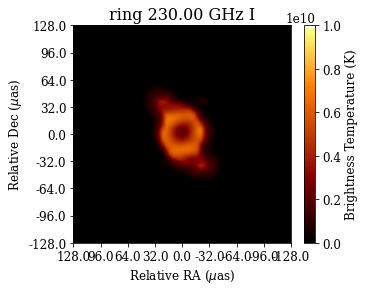

2023-11-22 09:07:21,658 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:07:21,666 INFO Display              :: Penalty--> 182.26674423257407
2023-11-22 09:07:21,965 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:07:21,973 INFO Display              :: Penalty--> 182.26674423257407
2023-11-22 09:07:22,278 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:07:22,278 INFO Display              :: Penalty--> 182.26674423257407
2023-11-22 09:07:22,586 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:07:22,586 INFO Display              :: Penalty--> 182.26674423257407
2023-11-22 09:07:22,892 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:07:22,892 INFO Display              :: Penalty--> 182.26674423257407
2023-11-22 09:07:23,376 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:07:23,384 INFO Display              :: Penalty--> 182.26674423257407
2023-11-22 09:07:23,682 INFO CountIterations      :: iteration = 7 / 2

2998.7229704970055
Data Fidelity:  68.37632235712219


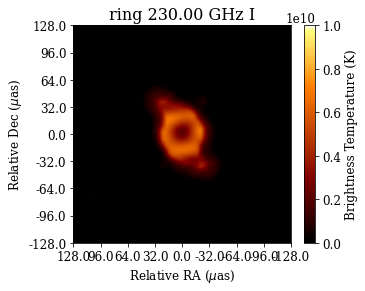

2023-11-22 09:07:30,040 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:07:30,040 INFO Display              :: Penalty--> 182.26674423257407
2023-11-22 09:07:30,355 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:07:30,359 INFO Display              :: Penalty--> 182.26674423257407
2023-11-22 09:07:30,659 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:07:30,659 INFO Display              :: Penalty--> 182.26674423257407
2023-11-22 09:07:30,947 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:07:30,955 INFO Display              :: Penalty--> 182.25601889089998
2023-11-22 09:07:31,229 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:07:31,237 INFO Display              :: Penalty--> 182.25601889089998
2023-11-22 09:07:31,535 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:07:31,535 INFO Display              :: Penalty--> 182.22537505754545
2023-11-22 09:07:31,841 INFO CountIterations      :: iteration = 7 / 2

2998.7378535952976
Data Fidelity:  67.37124035626158


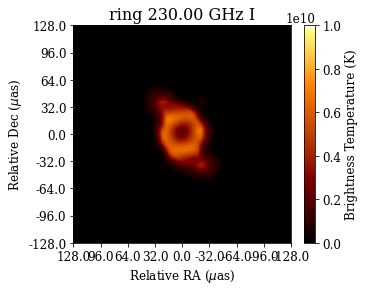

2023-11-22 09:07:38,593 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:07:38,595 INFO Display              :: Penalty--> 182.22537505754545
2023-11-22 09:07:38,901 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:07:38,909 INFO Display              :: Penalty--> 182.22537505754545
2023-11-22 09:07:39,230 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:07:39,230 INFO Display              :: Penalty--> 182.19473122419092
2023-11-22 09:07:39,558 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:07:39,558 INFO Display              :: Penalty--> 182.1640873908364
2023-11-22 09:07:39,892 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:07:39,896 INFO Display              :: Penalty--> 182.1640873908364
2023-11-22 09:07:40,213 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:07:40,221 INFO Display              :: Penalty--> 182.13344355748185
2023-11-22 09:07:40,554 INFO CountIterations      :: iteration = 7 / 25


2998.709073543041
Data Fidelity:  66.38283031616544


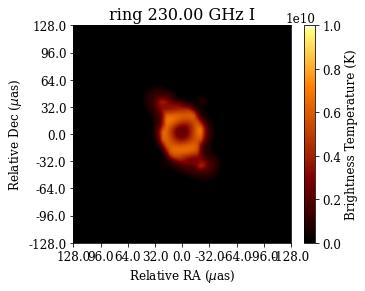

2023-11-22 09:07:47,279 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:07:47,287 INFO Display              :: Penalty--> 182.13344355748185
2023-11-22 09:07:47,609 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:07:47,609 INFO Display              :: Penalty--> 182.13344355748185
2023-11-22 09:07:47,925 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:07:47,930 INFO Display              :: Penalty--> 182.13344355748185
2023-11-22 09:07:48,253 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:07:48,253 INFO Display              :: Penalty--> 182.13344355748185
2023-11-22 09:07:48,577 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:07:48,585 INFO Display              :: Penalty--> 182.13344355748185
2023-11-22 09:07:48,894 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:07:48,894 INFO Display              :: Penalty--> 182.13344355748185
2023-11-22 09:07:49,200 INFO CountIterations      :: iteration = 7 / 2

2998.710094399931
Data Fidelity:  65.41914456623556


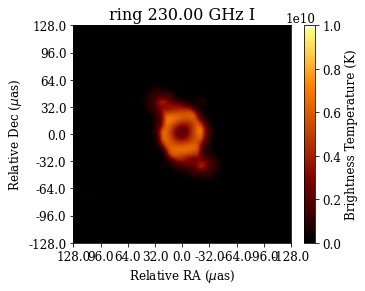

2023-11-22 09:07:55,852 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:07:55,852 INFO Display              :: Penalty--> 182.0721558907728
2023-11-22 09:07:56,167 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:07:56,175 INFO Display              :: Penalty--> 182.0721558907728
2023-11-22 09:07:56,480 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:07:56,480 INFO Display              :: Penalty--> 182.0721558907728
2023-11-22 09:07:56,786 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:07:56,794 INFO Display              :: Penalty--> 182.0721558907728
2023-11-22 09:07:57,116 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:07:57,123 INFO Display              :: Penalty--> 182.0721558907728
2023-11-22 09:07:57,421 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:07:57,421 INFO Display              :: Penalty--> 182.0721558907728
2023-11-22 09:07:57,726 INFO CountIterations      :: iteration = 7 / 25
2023

2998.708408899032
Data Fidelity:  64.48108477500507


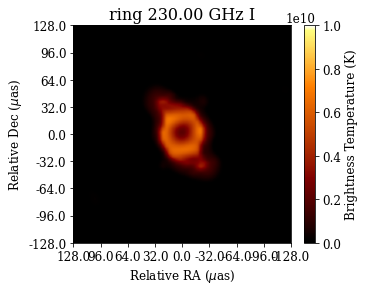

2023-11-22 09:08:04,481 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:08:04,481 INFO Display              :: Penalty--> 182.0721558907728
2023-11-22 09:08:04,773 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:08:04,773 INFO Display              :: Penalty--> 182.0721558907728
2023-11-22 09:08:05,071 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:08:05,078 INFO Display              :: Penalty--> 182.0721558907728
2023-11-22 09:08:05,388 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:08:05,393 INFO Display              :: Penalty--> 182.0721558907728
2023-11-22 09:08:05,700 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:08:05,708 INFO Display              :: Penalty--> 182.0721558907728
2023-11-22 09:08:06,023 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:08:06,023 INFO Display              :: Penalty--> 182.0721558907728
2023-11-22 09:08:06,344 INFO CountIterations      :: iteration = 7 / 25
2023

2998.7084817011855
Data Fidelity:  63.560039700706525


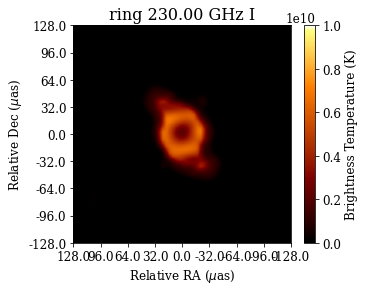

We use  6 scales with threshold 3.5
Current minimum 2756.3110384630822
Start optimization with thresholds [3.5 3.5 3.5 3.5 3.5 3.5 3.5]
reverse mode: True
Updated at scale 0 to threshold 5.5 to minimum 2747.171400944711
Updated at scale 0 to threshold 6.0 to minimum 2746.7019482702663
Updated at scale 0 to threshold 6.5 to minimum 2696.3110271735372
Updated at scale 0 to threshold 7.0 to minimum 2670.727872288536
Updated at scale 1 to threshold 5.5 to minimum 2613.943580479421
Updated at scale 2 to threshold 3.0 to minimum 2604.9310034734417
Updated at scale 2 to threshold 5.5 to minimum 2563.012785494111
Updated at scale 3 to threshold 0.5 to minimum 2562.8159920241787
Updated at scale 3 to threshold 1.5 to minimum 2550.4880689796723
Updated at scale 3 to threshold 2.0 to minimum 2546.532696013193
Updated at scale 4 to threshold 0.0 to minimum 2539.912176690902
Updated at scale 4 to threshold 0.5 to minimum 2515.791944599744
Updated at scale 5 to threshold 0.0 to minimum 2511.81026049

2023-11-22 09:08:40,153 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:08:40,161 INFO Display              :: Penalty--> 517.1438607355802
2023-11-22 09:08:40,482 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:08:40,486 INFO Display              :: Penalty--> 485.8504665401679
2023-11-22 09:08:40,816 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:08:40,820 INFO Display              :: Penalty--> 479.7967922876606
2023-11-22 09:08:41,154 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:08:41,157 INFO Display              :: Penalty--> 473.23596606083146
2023-11-22 09:08:41,464 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:08:41,472 INFO Display              :: Penalty--> 468.04951171430815
2023-11-22 09:08:41,787 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:08:41,794 INFO Display              :: Penalty--> 463.65572614540014
2023-11-22 09:08:42,117 INFO CountIterations      :: iteration = 7 / 25
2

2877.5315619038292
Data Fidelity:  439.2873166608997


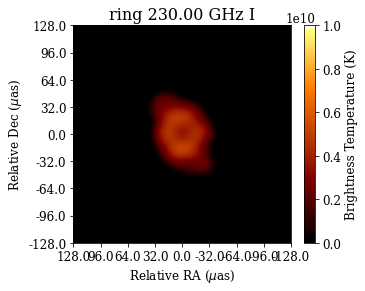

2023-11-22 09:08:48,830 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:08:48,831 INFO Display              :: Penalty--> 403.5649263135315
2023-11-22 09:08:49,136 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:08:49,144 INFO Display              :: Penalty--> 402.81109032480697
2023-11-22 09:08:49,458 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:08:49,462 INFO Display              :: Penalty--> 401.1808430139399
2023-11-22 09:08:49,772 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:08:49,785 INFO Display              :: Penalty--> 399.83711496698845
2023-11-22 09:08:50,094 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:08:50,098 INFO Display              :: Penalty--> 398.1762238227668
2023-11-22 09:08:50,398 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:08:50,398 INFO Display              :: Penalty--> 397.01942258132885
2023-11-22 09:08:50,731 INFO CountIterations      :: iteration = 7 / 25
2

2941.2387884793534
Data Fidelity:  319.27283167773527


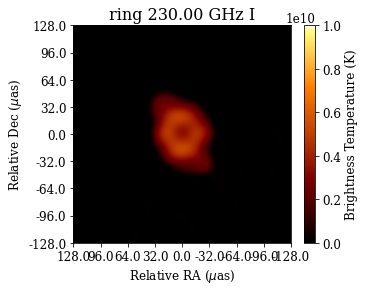

2023-11-22 09:08:57,595 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:08:57,598 INFO Display              :: Penalty--> 376.4809802234751
2023-11-22 09:08:57,888 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:08:57,888 INFO Display              :: Penalty--> 376.0887403124356
2023-11-22 09:08:58,209 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:08:58,209 INFO Display              :: Penalty--> 375.8926203569158
2023-11-22 09:08:58,517 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:08:58,525 INFO Display              :: Penalty--> 375.53255589294935
2023-11-22 09:08:58,847 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:08:58,847 INFO Display              :: Penalty--> 375.1602344735903
2023-11-22 09:08:59,176 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:08:59,184 INFO Display              :: Penalty--> 374.62243693206597
2023-11-22 09:08:59,506 INFO CountIterations      :: iteration = 7 / 25
20

2954.434722004219
Data Fidelity:  272.2502424876087


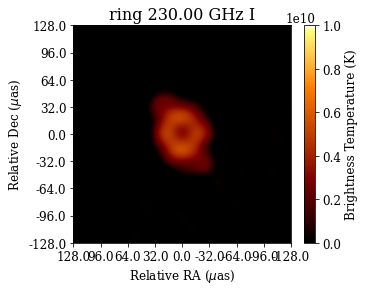

2023-11-22 09:09:06,333 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:09:06,341 INFO Display              :: Penalty--> 367.6034853965865
2023-11-22 09:09:06,655 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:09:06,655 INFO Display              :: Penalty--> 367.58203471323833
2023-11-22 09:09:06,962 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:09:06,962 INFO Display              :: Penalty--> 367.1484256271702
2023-11-22 09:09:07,282 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:09:07,285 INFO Display              :: Penalty--> 367.1484256271702
2023-11-22 09:09:07,606 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:09:07,606 INFO Display              :: Penalty--> 366.5789800578212
2023-11-22 09:09:07,929 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:09:07,937 INFO Display              :: Penalty--> 366.37213476062726
2023-11-22 09:09:08,252 INFO CountIterations      :: iteration = 7 / 25
20

2962.399615084727
Data Fidelity:  243.34469626096933


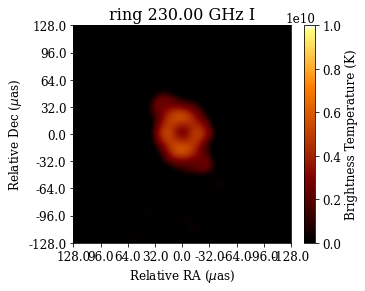

2023-11-22 09:09:15,085 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:09:15,093 INFO Display              :: Penalty--> 359.59579866174465
2023-11-22 09:09:15,405 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:09:15,410 INFO Display              :: Penalty--> 359.3996787062249
2023-11-22 09:09:15,744 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:09:15,744 INFO Display              :: Penalty--> 359.33839103951584
2023-11-22 09:09:16,051 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:09:16,051 INFO Display              :: Penalty--> 358.99671345351135
2023-11-22 09:09:16,373 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:09:16,373 INFO Display              :: Penalty--> 358.8005934979916
2023-11-22 09:09:16,670 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:09:16,670 INFO Display              :: Penalty--> 358.5738297091173
2023-11-22 09:09:17,014 INFO CountIterations      :: iteration = 7 / 25
2

2968.6233273299727
Data Fidelity:  223.59133409418803


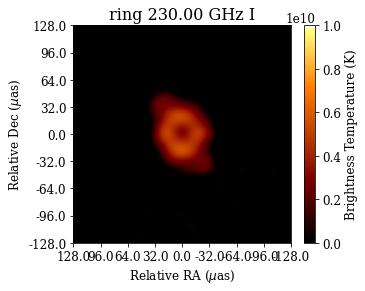

2023-11-22 09:09:24,134 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:09:24,134 INFO Display              :: Penalty--> 354.6882031987477
2023-11-22 09:09:24,462 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:09:24,470 INFO Display              :: Penalty--> 354.49208324322797
2023-11-22 09:09:24,802 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:09:24,809 INFO Display              :: Penalty--> 354.4307955765189
2023-11-22 09:09:25,128 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:09:25,128 INFO Display              :: Penalty--> 354.14274412093556
2023-11-22 09:09:25,442 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:09:25,442 INFO Display              :: Penalty--> 354.0600057708783
2023-11-22 09:09:25,754 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:09:25,754 INFO Display              :: Penalty--> 353.69840969319335
2023-11-22 09:09:26,067 INFO CountIterations      :: iteration = 7 / 25
2

2972.907637712687
Data Fidelity:  208.57030929412093


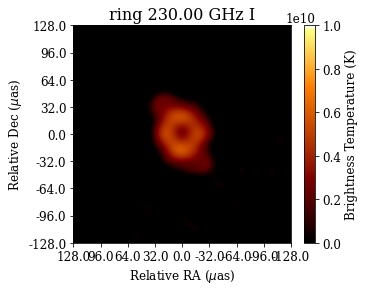

2023-11-22 09:09:32,881 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:09:32,891 INFO Display              :: Penalty--> 349.77294562151354
2023-11-22 09:09:33,219 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:09:33,227 INFO Display              :: Penalty--> 349.7622202798395
2023-11-22 09:09:33,558 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:09:33,562 INFO Display              :: Penalty--> 349.6702887797759
2023-11-22 09:09:33,883 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:09:33,891 INFO Display              :: Penalty--> 349.6702887797759
2023-11-22 09:09:34,211 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:09:34,214 INFO Display              :: Penalty--> 349.4940873159366
2023-11-22 09:09:34,529 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:09:34,529 INFO Display              :: Penalty--> 349.4940873159366
2023-11-22 09:09:34,843 INFO CountIterations      :: iteration = 7 / 25
202

2976.282974814224
Data Fidelity:  197.1705758202512


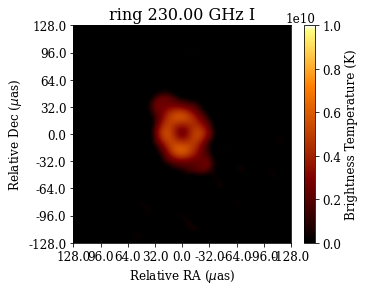

2023-11-22 09:09:41,762 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:09:41,773 INFO Display              :: Penalty--> 347.22032008257366
2023-11-22 09:09:42,076 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:09:42,084 INFO Display              :: Penalty--> 347.22032008257366
2023-11-22 09:09:42,405 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:09:42,405 INFO Display              :: Penalty--> 347.18967624921913
2023-11-22 09:09:42,718 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:09:42,722 INFO Display              :: Penalty--> 347.178950907545
2023-11-22 09:09:43,016 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:09:43,024 INFO Display              :: Penalty--> 347.178950907545
2023-11-22 09:09:43,323 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:09:43,323 INFO Display              :: Penalty--> 347.1483070741905
2023-11-22 09:09:43,645 INFO CountIterations      :: iteration = 7 / 25
202

2978.9204948901597
Data Fidelity:  188.09578889338718


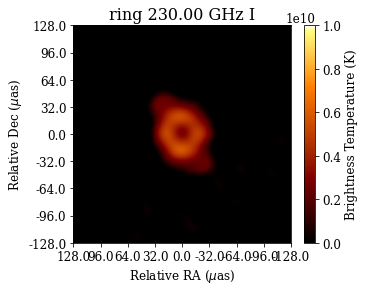

2023-11-22 09:09:50,549 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:09:50,557 INFO Display              :: Penalty--> 345.73562982424204
2023-11-22 09:09:50,878 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:09:50,886 INFO Display              :: Penalty--> 345.70498599088756
2023-11-22 09:09:51,192 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:09:51,192 INFO Display              :: Penalty--> 345.5395098687223
2023-11-22 09:09:51,513 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:09:51,513 INFO Display              :: Penalty--> 345.37403374655713
2023-11-22 09:09:51,835 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:09:51,835 INFO Display              :: Penalty--> 345.37403374655713
2023-11-22 09:09:52,134 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:09:52,142 INFO Display              :: Penalty--> 345.37403374655713
2023-11-22 09:09:52,463 INFO CountIterations      :: iteration = 7 / 25

2981.0116222739452
Data Fidelity:  180.40129675788475


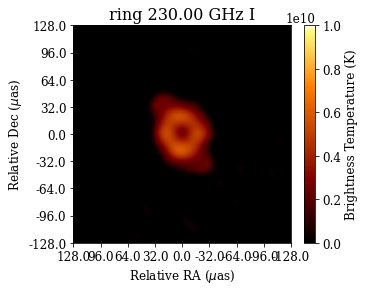

2023-11-22 09:09:59,321 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:09:59,321 INFO Display              :: Penalty--> 343.7912843773895
2023-11-22 09:09:59,628 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:09:59,636 INFO Display              :: Penalty--> 343.7912843773895
2023-11-22 09:09:59,950 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:09:59,958 INFO Display              :: Penalty--> 343.7912843773895
2023-11-22 09:10:00,242 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:10:00,248 INFO Display              :: Penalty--> 343.78362341905085
2023-11-22 09:10:00,561 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:10:00,561 INFO Display              :: Penalty--> 343.78362341905085
2023-11-22 09:10:00,875 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:10:00,883 INFO Display              :: Penalty--> 343.7529795856963
2023-11-22 09:10:01,198 INFO CountIterations      :: iteration = 7 / 25
20

2982.779511905119
Data Fidelity:  173.77498093256298


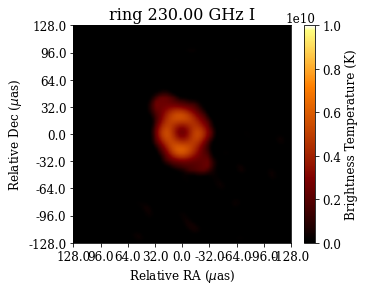

2023-11-22 09:10:08,008 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:10:08,008 INFO Display              :: Penalty--> 342.07063833607583
2023-11-22 09:10:08,322 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:10:08,330 INFO Display              :: Penalty--> 342.0399945027213
2023-11-22 09:10:08,637 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:10:08,645 INFO Display              :: Penalty--> 342.00935066936677
2023-11-22 09:10:08,950 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:10:08,952 INFO Display              :: Penalty--> 341.97870683601224
2023-11-22 09:10:09,271 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:10:09,271 INFO Display              :: Penalty--> 341.9174191693032
2023-11-22 09:10:09,583 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:10:09,591 INFO Display              :: Penalty--> 341.9174191693032
2023-11-22 09:10:09,896 INFO CountIterations      :: iteration = 7 / 25
2

2984.354303874932
Data Fidelity:  167.94185097975748


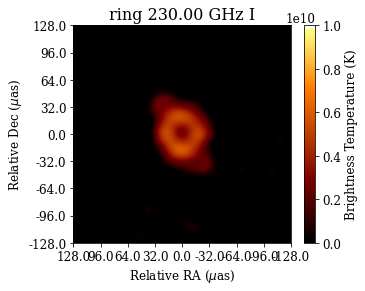

2023-11-22 09:10:16,750 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:10:16,754 INFO Display              :: Penalty--> 340.7529563915772
2023-11-22 09:10:17,052 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:10:17,059 INFO Display              :: Penalty--> 340.74529543323854
2023-11-22 09:10:17,392 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:10:17,392 INFO Display              :: Penalty--> 340.65336393317494
2023-11-22 09:10:17,709 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:10:17,709 INFO Display              :: Penalty--> 340.6426385915008
2023-11-22 09:10:18,030 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:10:18,035 INFO Display              :: Penalty--> 340.4771624693356
2023-11-22 09:10:18,354 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:10:18,354 INFO Display              :: Penalty--> 340.46643712766155
2023-11-22 09:10:18,660 INFO CountIterations      :: iteration = 7 / 25
2

2985.5486485093284
Data Fidelity:  162.75810571786639


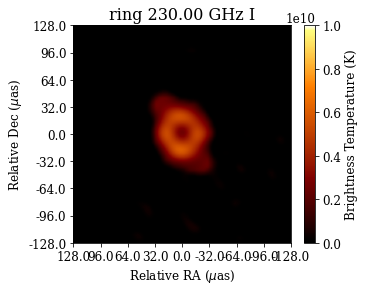

2023-11-22 09:10:25,488 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:10:25,488 INFO Display              :: Penalty--> 339.7141327526555
2023-11-22 09:10:25,815 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:10:25,820 INFO Display              :: Penalty--> 339.5379312888162
2023-11-22 09:10:26,121 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:10:26,129 INFO Display              :: Penalty--> 339.34181133329645
2023-11-22 09:10:26,437 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:10:26,437 INFO Display              :: Penalty--> 339.3111674999419
2023-11-22 09:10:26,759 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:10:26,759 INFO Display              :: Penalty--> 339.3111674999419
2023-11-22 09:10:27,082 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:10:27,082 INFO Display              :: Penalty--> 338.949571422257
2023-11-22 09:10:27,405 INFO CountIterations      :: iteration = 7 / 25
2023

2986.653470088605
Data Fidelity:  157.79587448741583


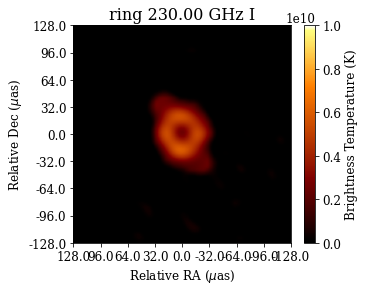

2023-11-22 09:10:34,163 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:10:34,171 INFO Display              :: Penalty--> 337.196749355921
2023-11-22 09:10:34,487 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:10:34,497 INFO Display              :: Penalty--> 336.86579711159055
2023-11-22 09:10:34,794 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:10:34,797 INFO Display              :: Penalty--> 336.86579711159055
2023-11-22 09:10:35,132 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:10:35,132 INFO Display              :: Penalty--> 336.86579711159055
2023-11-22 09:10:35,432 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:10:35,440 INFO Display              :: Penalty--> 336.68959564775133
2023-11-22 09:10:35,739 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:10:35,744 INFO Display              :: Penalty--> 336.68959564775133
2023-11-22 09:10:36,047 INFO CountIterations      :: iteration = 7 / 25


2987.3526281744325
Data Fidelity:  153.05058123964866


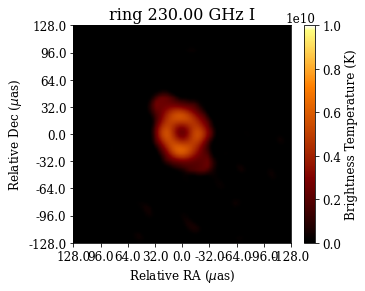

2023-11-22 09:10:42,946 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:10:42,946 INFO Display              :: Penalty--> 335.5128759146329
2023-11-22 09:10:43,239 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:10:43,248 INFO Display              :: Penalty--> 335.4822320812783
2023-11-22 09:10:43,556 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:10:43,564 INFO Display              :: Penalty--> 335.4515882479238
2023-11-22 09:10:43,893 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:10:43,897 INFO Display              :: Penalty--> 335.4515882479238
2023-11-22 09:10:44,219 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:10:44,219 INFO Display              :: Penalty--> 335.2248244590495
2023-11-22 09:10:44,530 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:10:44,535 INFO Display              :: Penalty--> 335.2248244590495
2023-11-22 09:10:44,836 INFO CountIterations      :: iteration = 7 / 25
2023

2988.2277420897963
Data Fidelity:  147.94845536068544


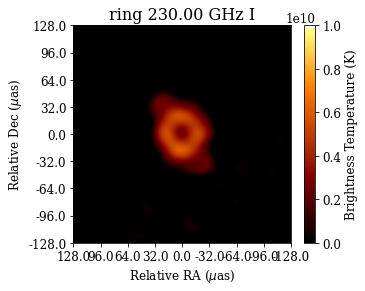

2023-11-22 09:10:51,651 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:10:51,659 INFO Display              :: Penalty--> 333.39079681227327
2023-11-22 09:10:51,993 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:10:51,994 INFO Display              :: Penalty--> 333.36015297891873
2023-11-22 09:10:52,320 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:10:52,323 INFO Display              :: Penalty--> 333.3295091455642
2023-11-22 09:10:52,631 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:10:52,631 INFO Display              :: Penalty--> 333.29886531220967
2023-11-22 09:10:52,976 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:10:52,976 INFO Display              :: Penalty--> 333.29886531220967
2023-11-22 09:10:53,309 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:10:53,318 INFO Display              :: Penalty--> 333.29886531220967
2023-11-22 09:10:53,636 INFO CountIterations      :: iteration = 7 / 25

2988.546369552284
Data Fidelity:  141.11057455543795


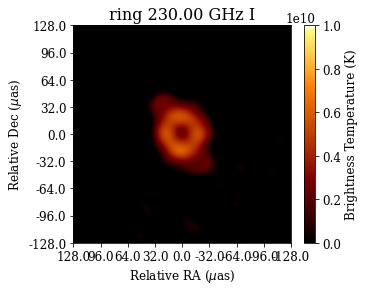

2023-11-22 09:11:00,315 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:11:00,323 INFO Display              :: Penalty--> 331.98578052066347
2023-11-22 09:11:00,620 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:11:00,620 INFO Display              :: Penalty--> 331.82030439849825
2023-11-22 09:11:00,950 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:11:00,950 INFO Display              :: Penalty--> 331.65482827633303
2023-11-22 09:11:01,272 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:11:01,280 INFO Display              :: Penalty--> 331.3238760320026
2023-11-22 09:11:01,592 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:11:01,592 INFO Display              :: Penalty--> 331.3238760320026
2023-11-22 09:11:02,138 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:11:02,147 INFO Display              :: Penalty--> 331.29323219864807
2023-11-22 09:11:02,458 INFO CountIterations      :: iteration = 7 / 25


2988.6257412826653
Data Fidelity:  122.9352219511083


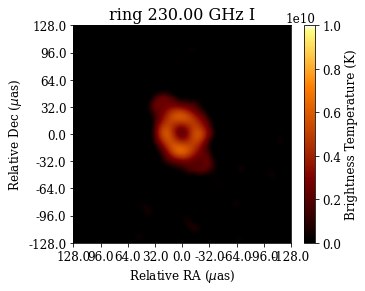

2023-11-22 09:11:09,342 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:11:09,350 INFO Display              :: Penalty--> 328.2043430436993
2023-11-22 09:11:09,670 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:11:09,670 INFO Display              :: Penalty--> 327.83202162434026
2023-11-22 09:11:10,008 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:11:10,016 INFO Display              :: Penalty--> 327.59453249379186
2023-11-22 09:11:10,347 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:11:10,347 INFO Display              :: Penalty--> 327.39841253827217
2023-11-22 09:11:10,663 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:11:10,671 INFO Display              :: Penalty--> 327.20229258275236
2023-11-22 09:11:10,993 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:11:11,001 INFO Display              :: Penalty--> 327.17164874939783
2023-11-22 09:11:11,307 INFO CountIterations      :: iteration = 7 / 25

2988.774456347467
Data Fidelity:  91.26533105839876


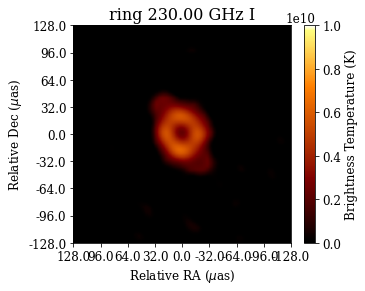

2023-11-22 09:11:18,339 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:11:18,347 INFO Display              :: Penalty--> 323.226266763987
2023-11-22 09:11:18,663 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:11:18,673 INFO Display              :: Penalty--> 322.864670686302
2023-11-22 09:11:18,969 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:11:18,977 INFO Display              :: Penalty--> 322.5337184419716
2023-11-22 09:11:19,310 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:11:19,310 INFO Display              :: Penalty--> 322.1721223642866
2023-11-22 09:11:19,648 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:11:19,651 INFO Display              :: Penalty--> 322.11083469757756
2023-11-22 09:11:19,962 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:11:19,962 INFO Display              :: Penalty--> 321.6144063310819
2023-11-22 09:11:20,275 INFO CountIterations      :: iteration = 7 / 25
2023-

2989.883081613395
Data Fidelity:  76.82391229691444


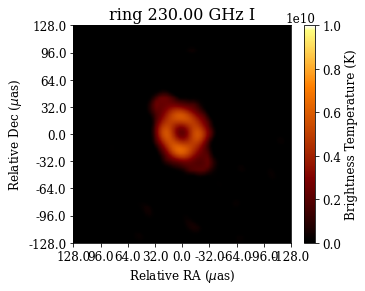

2023-11-22 09:11:27,055 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:11:27,060 INFO Display              :: Penalty--> 319.64094924254255
2023-11-22 09:11:27,381 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:11:27,389 INFO Display              :: Penalty--> 319.47547312037733
2023-11-22 09:11:27,697 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:11:27,697 INFO Display              :: Penalty--> 319.4448292870228
2023-11-22 09:11:28,035 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:11:28,043 INFO Display              :: Penalty--> 319.41418545366827
2023-11-22 09:11:28,372 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:11:28,376 INFO Display              :: Penalty--> 319.38354162031374
2023-11-22 09:11:28,676 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:11:28,684 INFO Display              :: Penalty--> 319.3528977869592
2023-11-22 09:11:29,005 INFO CountIterations      :: iteration = 7 / 25


2990.4302664287034
Data Fidelity:  68.64180487907207


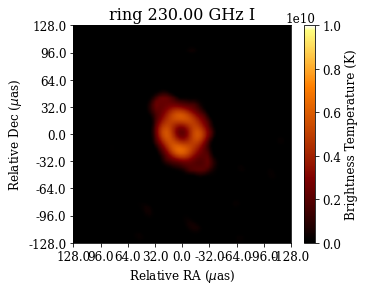

2023-11-22 09:11:35,782 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:11:35,790 INFO Display              :: Penalty--> 316.6439910097081
2023-11-22 09:11:36,119 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:11:36,127 INFO Display              :: Penalty--> 316.6439910097081
2023-11-22 09:11:36,433 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:11:36,441 INFO Display              :: Penalty--> 316.4785148875429
2023-11-22 09:11:36,739 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:11:36,747 INFO Display              :: Penalty--> 316.44787105418834
2023-11-22 09:11:37,069 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:11:37,077 INFO Display              :: Penalty--> 316.4172272208338
2023-11-22 09:11:37,406 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:11:37,406 INFO Display              :: Penalty--> 316.2211072653141
2023-11-22 09:11:37,728 INFO CountIterations      :: iteration = 7 / 25
202

2990.7402283725555
Data Fidelity:  62.99877034487986


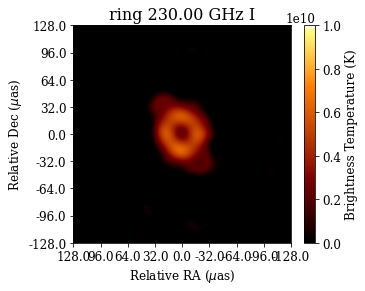

2023-11-22 09:11:44,478 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:11:44,478 INFO Display              :: Penalty--> 314.563280504428
2023-11-22 09:11:44,765 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:11:44,773 INFO Display              :: Penalty--> 314.39780438226273
2023-11-22 09:11:45,071 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:11:45,079 INFO Display              :: Penalty--> 314.35949959056956
2023-11-22 09:11:45,386 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:11:45,394 INFO Display              :: Penalty--> 314.328855757215
2023-11-22 09:11:45,698 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:11:45,706 INFO Display              :: Penalty--> 314.16337963504986
2023-11-22 09:11:46,036 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:11:46,043 INFO Display              :: Penalty--> 314.16337963504986
2023-11-22 09:11:46,371 INFO CountIterations      :: iteration = 7 / 25
20

2990.968091993486
Data Fidelity:  58.619714208420305


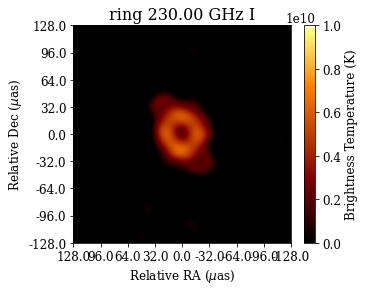

2023-11-22 09:11:53,223 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:11:53,234 INFO Display              :: Penalty--> 312.48256999914776
2023-11-22 09:11:53,538 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:11:53,546 INFO Display              :: Penalty--> 312.4519261657932
2023-11-22 09:11:53,859 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:11:53,867 INFO Display              :: Penalty--> 312.4519261657932
2023-11-22 09:11:54,182 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:11:54,182 INFO Display              :: Penalty--> 312.4519261657932
2023-11-22 09:11:54,510 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:11:54,510 INFO Display              :: Penalty--> 312.27878908528936
2023-11-22 09:11:54,832 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:11:54,832 INFO Display              :: Penalty--> 312.27878908528936
2023-11-22 09:11:55,153 INFO CountIterations      :: iteration = 7 / 25
2

2991.2437716244376
Data Fidelity:  55.04160196228881


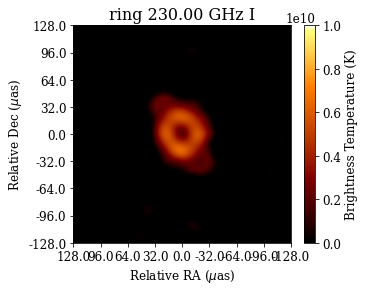

2023-11-22 09:12:02,007 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:12:02,015 INFO Display              :: Penalty--> 311.15722825220905
2023-11-22 09:12:02,320 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:12:02,328 INFO Display              :: Penalty--> 310.99175213004384
2023-11-22 09:12:02,648 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:12:02,656 INFO Display              :: Penalty--> 310.99175213004384
2023-11-22 09:12:02,968 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:12:02,971 INFO Display              :: Penalty--> 310.9611082966893
2023-11-22 09:12:03,291 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:12:03,299 INFO Display              :: Penalty--> 310.9611082966893
2023-11-22 09:12:03,620 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:12:03,620 INFO Display              :: Penalty--> 310.9611082966893
2023-11-22 09:12:03,942 INFO CountIterations      :: iteration = 7 / 25
2

2991.5517652745193
Data Fidelity:  51.88277274141841


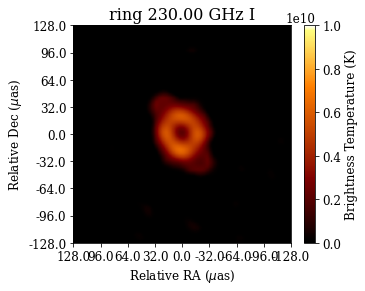

2023-11-22 09:12:10,833 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:12:10,841 INFO Display              :: Penalty--> 309.66334542182034
2023-11-22 09:12:11,167 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:12:11,171 INFO Display              :: Penalty--> 309.66334542182034
2023-11-22 09:12:11,491 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:12:11,499 INFO Display              :: Penalty--> 309.66334542182034
2023-11-22 09:12:11,812 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:12:11,812 INFO Display              :: Penalty--> 309.66334542182034
2023-11-22 09:12:12,156 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:12:12,164 INFO Display              :: Penalty--> 309.4978692996551
2023-11-22 09:12:12,485 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:12:12,493 INFO Display              :: Penalty--> 309.32166783581584
2023-11-22 09:12:12,815 INFO CountIterations      :: iteration = 7 / 25

2991.8034273733647
Data Fidelity:  49.12509072079136


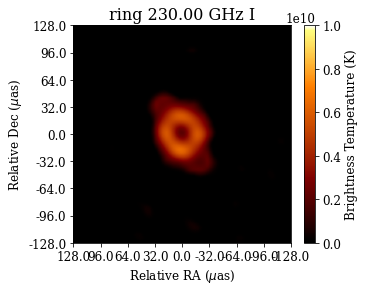

2023-11-22 09:12:19,661 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:12:19,669 INFO Display              :: Penalty--> 308.2460727527673
2023-11-22 09:12:19,965 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:12:19,965 INFO Display              :: Penalty--> 308.2460727527673
2023-11-22 09:12:20,292 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:12:20,295 INFO Display              :: Penalty--> 308.2460727527673
2023-11-22 09:12:20,617 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:12:20,625 INFO Display              :: Penalty--> 308.2460727527673
2023-11-22 09:12:20,938 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:12:20,946 INFO Display              :: Penalty--> 308.2154289194128
2023-11-22 09:12:21,278 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:12:21,286 INFO Display              :: Penalty--> 308.18478508605824
2023-11-22 09:12:21,600 INFO CountIterations      :: iteration = 7 / 25
202

2992.1160590504624
Data Fidelity:  46.67751537270155


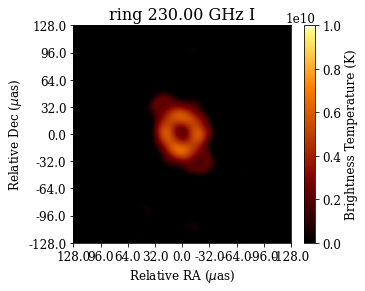

2023-11-22 09:12:28,629 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:12:28,635 INFO Display              :: Penalty--> 307.55505604447035
2023-11-22 09:12:28,958 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:12:28,966 INFO Display              :: Penalty--> 307.5244122111158
2023-11-22 09:12:29,299 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:12:29,303 INFO Display              :: Penalty--> 307.5244122111158
2023-11-22 09:12:29,633 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:12:29,633 INFO Display              :: Penalty--> 307.5244122111158
2023-11-22 09:12:29,953 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:12:29,961 INFO Display              :: Penalty--> 307.34821074727654
2023-11-22 09:12:30,276 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:12:30,284 INFO Display              :: Penalty--> 307.30684157224795
2023-11-22 09:12:30,606 INFO CountIterations      :: iteration = 7 / 25
2

2992.3795173577873
Data Fidelity:  44.395485169478164


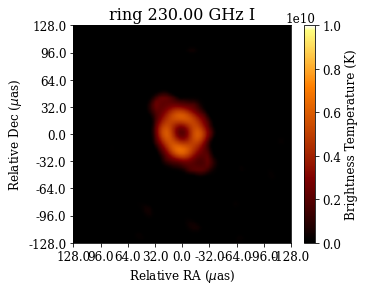

2023-11-22 09:12:37,846 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:12:37,846 INFO Display              :: Penalty--> 306.64646869730547
2023-11-22 09:12:38,175 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:12:38,175 INFO Display              :: Penalty--> 306.61582486395093
2023-11-22 09:12:38,508 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:12:38,513 INFO Display              :: Penalty--> 306.61582486395093
2023-11-22 09:12:38,794 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:12:38,802 INFO Display              :: Penalty--> 306.4503487417857
2023-11-22 09:12:39,091 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:12:39,094 INFO Display              :: Penalty--> 306.4503487417857
2023-11-22 09:12:39,389 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:12:39,397 INFO Display              :: Penalty--> 306.4503487417857
2023-11-22 09:12:39,704 INFO CountIterations      :: iteration = 7 / 25
2

2992.6961422144636
Data Fidelity:  42.35764992237719


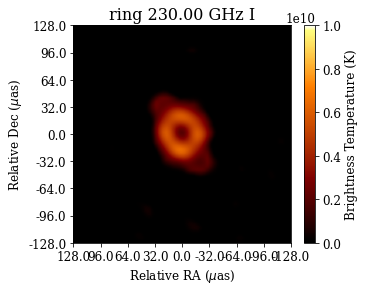

2023-11-22 09:12:46,259 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:12:46,266 INFO Display              :: Penalty--> 305.92480815565403
2023-11-22 09:12:46,588 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:12:46,592 INFO Display              :: Penalty--> 305.92480815565403
2023-11-22 09:12:46,889 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:12:46,897 INFO Display              :: Penalty--> 305.92480815565403
2023-11-22 09:12:47,228 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:12:47,228 INFO Display              :: Penalty--> 305.92480815565403
2023-11-22 09:12:47,544 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:12:47,549 INFO Display              :: Penalty--> 305.8941643222995
2023-11-22 09:12:47,872 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:12:47,872 INFO Display              :: Penalty--> 305.8941643222995
2023-11-22 09:12:48,218 INFO CountIterations      :: iteration = 7 / 25


2993.014445314141
Data Fidelity:  40.47321332501721


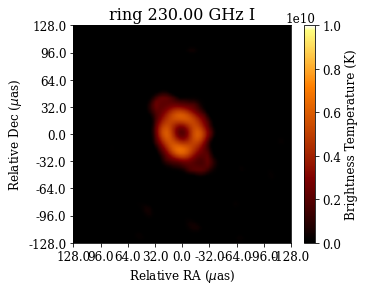

2023-11-22 09:12:54,873 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:12:54,875 INFO Display              :: Penalty--> 305.53256824461454
2023-11-22 09:12:55,193 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:12:55,197 INFO Display              :: Penalty--> 305.53256824461454
2023-11-22 09:12:55,494 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:12:55,502 INFO Display              :: Penalty--> 305.5218429029404
2023-11-22 09:12:55,818 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:12:55,826 INFO Display              :: Penalty--> 305.5218429029404
2023-11-22 09:12:56,121 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:12:56,125 INFO Display              :: Penalty--> 305.5218429029404
2023-11-22 09:12:56,439 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:12:56,439 INFO Display              :: Penalty--> 305.5218429029404
2023-11-22 09:12:56,753 INFO CountIterations      :: iteration = 7 / 25
20

2993.301909602623
Data Fidelity:  38.72253504932631


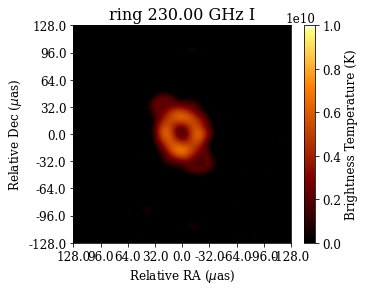

2023-11-22 09:13:03,375 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:13:03,383 INFO Display              :: Penalty--> 305.14186052524275
2023-11-22 09:13:03,682 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:13:03,693 INFO Display              :: Penalty--> 305.14186052524275
2023-11-22 09:13:03,994 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:13:03,994 INFO Display              :: Penalty--> 305.14186052524275
2023-11-22 09:13:04,301 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:13:04,305 INFO Display              :: Penalty--> 305.14186052524275
2023-11-22 09:13:04,573 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:13:04,581 INFO Display              :: Penalty--> 304.97638440307753
2023-11-22 09:13:04,872 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:13:04,880 INFO Display              :: Penalty--> 304.97638440307753
2023-11-22 09:13:05,162 INFO CountIterations      :: iteration = 7 / 2

2993.559498306546
Data Fidelity:  37.00936755345147


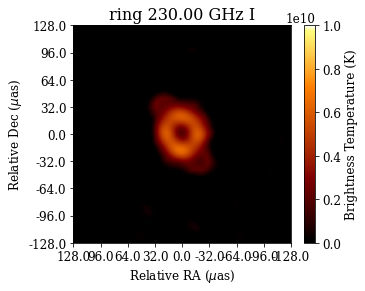

2023-11-22 09:13:11,770 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:13:11,778 INFO Display              :: Penalty--> 303.9850592838046
2023-11-22 09:13:12,061 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:13:12,069 INFO Display              :: Penalty--> 303.9850592838046
2023-11-22 09:13:12,359 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:13:12,367 INFO Display              :: Penalty--> 303.9850592838046
2023-11-22 09:13:12,659 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:13:12,667 INFO Display              :: Penalty--> 303.9544154504501
2023-11-22 09:13:12,989 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:13:12,989 INFO Display              :: Penalty--> 303.7889393282849
2023-11-22 09:13:13,286 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:13:13,294 INFO Display              :: Penalty--> 303.7889393282849
2023-11-22 09:13:13,577 INFO CountIterations      :: iteration = 7 / 25
2023

2993.7582834027244
Data Fidelity:  35.46311070781549


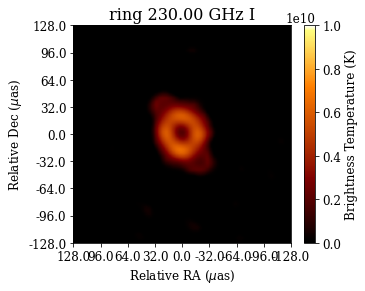

2023-11-22 09:13:20,093 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:13:20,093 INFO Display              :: Penalty--> 303.35533024221684
2023-11-22 09:13:20,390 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:13:20,398 INFO Display              :: Penalty--> 303.35533024221684
2023-11-22 09:13:20,703 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:13:20,703 INFO Display              :: Penalty--> 303.3246864088623
2023-11-22 09:13:21,023 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:13:21,023 INFO Display              :: Penalty--> 303.3246864088623
2023-11-22 09:13:21,329 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:13:21,329 INFO Display              :: Penalty--> 303.1285664533425
2023-11-22 09:13:21,650 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:13:21,650 INFO Display              :: Penalty--> 303.1285664533425
2023-11-22 09:13:21,979 INFO CountIterations      :: iteration = 7 / 25
20

2994.0540324928597
Data Fidelity:  33.98067961540604


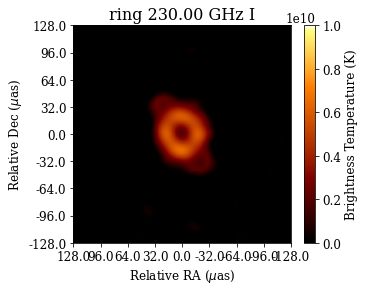

2023-11-22 09:13:28,726 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:13:28,734 INFO Display              :: Penalty--> 302.42682440337154
2023-11-22 09:13:29,035 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:13:29,038 INFO Display              :: Penalty--> 302.42682440337154
2023-11-22 09:13:29,334 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:13:29,342 INFO Display              :: Penalty--> 302.42682440337154
2023-11-22 09:13:29,674 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:13:29,682 INFO Display              :: Penalty--> 302.42682440337154
2023-11-22 09:13:29,986 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:13:29,995 INFO Display              :: Penalty--> 302.396180570017
2023-11-22 09:13:30,298 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:13:30,307 INFO Display              :: Penalty--> 302.396180570017
2023-11-22 09:13:30,603 INFO CountIterations      :: iteration = 7 / 25
20

2994.217491644849
Data Fidelity:  32.6315930544646


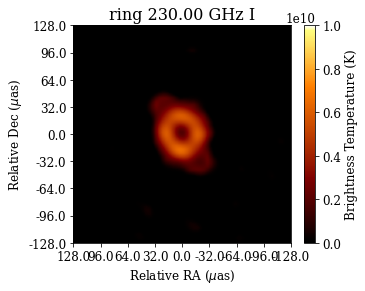

2023-11-22 09:13:37,344 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:13:37,351 INFO Display              :: Penalty--> 302.12804760611397
2023-11-22 09:13:37,667 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:13:37,667 INFO Display              :: Penalty--> 302.12804760611397
2023-11-22 09:13:37,998 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:13:37,998 INFO Display              :: Penalty--> 302.12804760611397
2023-11-22 09:13:38,339 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:13:38,339 INFO Display              :: Penalty--> 302.12804760611397
2023-11-22 09:13:38,647 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:13:38,647 INFO Display              :: Penalty--> 302.12804760611397
2023-11-22 09:13:38,978 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:13:38,978 INFO Display              :: Penalty--> 301.9625714839488
2023-11-22 09:13:39,273 INFO CountIterations      :: iteration = 7 / 25

2994.451247667129
Data Fidelity:  31.371320436609352


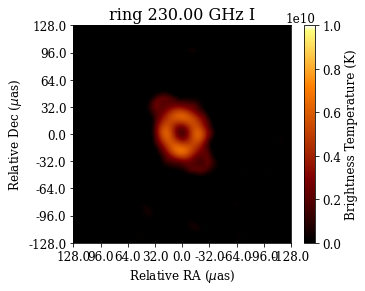

2023-11-22 09:13:45,814 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:13:45,822 INFO Display              :: Penalty--> 301.9135413505816
2023-11-22 09:13:46,121 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:13:46,129 INFO Display              :: Penalty--> 301.9135413505816
2023-11-22 09:13:46,444 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:13:46,444 INFO Display              :: Penalty--> 301.9135413505816
2023-11-22 09:13:46,765 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:13:46,765 INFO Display              :: Penalty--> 301.9135413505816
2023-11-22 09:13:47,071 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:13:47,071 INFO Display              :: Penalty--> 301.9135413505816
2023-11-22 09:13:47,377 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:13:47,385 INFO Display              :: Penalty--> 301.9135413505816
2023-11-22 09:13:47,700 INFO CountIterations      :: iteration = 7 / 25
2023

2994.671864353008
Data Fidelity:  30.17856904831912


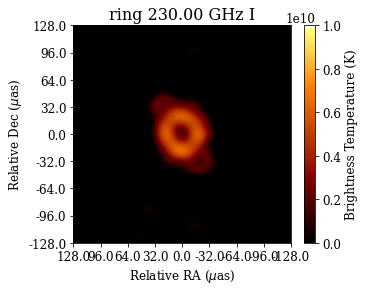

2023-11-22 09:13:54,447 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:13:54,449 INFO Display              :: Penalty--> 301.6852453700395
2023-11-22 09:13:54,752 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:13:54,760 INFO Display              :: Penalty--> 301.6852453700395
2023-11-22 09:13:55,076 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:13:55,076 INFO Display              :: Penalty--> 301.6852453700395
2023-11-22 09:13:55,390 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:13:55,398 INFO Display              :: Penalty--> 301.6852453700395
2023-11-22 09:13:55,712 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:13:55,720 INFO Display              :: Penalty--> 301.6852453700395
2023-11-22 09:13:56,027 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:13:56,027 INFO Display              :: Penalty--> 301.6852453700395
2023-11-22 09:13:56,343 INFO CountIterations      :: iteration = 7 / 25
2023

2994.9046616994656
Data Fidelity:  29.041399534999734


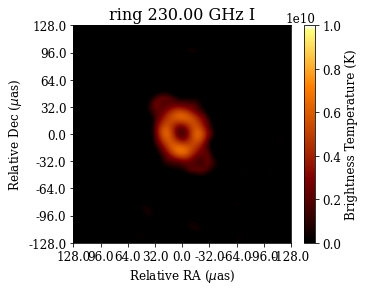

2023-11-22 09:14:03,027 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:14:03,035 INFO Display              :: Penalty--> 301.4584815811653
2023-11-22 09:14:03,372 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:14:03,372 INFO Display              :: Penalty--> 301.4584815811653
2023-11-22 09:14:03,703 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:14:03,711 INFO Display              :: Penalty--> 301.4584815811653
2023-11-22 09:14:04,042 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:14:04,046 INFO Display              :: Penalty--> 301.4584815811653
2023-11-22 09:14:04,380 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:14:04,380 INFO Display              :: Penalty--> 301.4584815811653
2023-11-22 09:14:04,711 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:14:04,711 INFO Display              :: Penalty--> 301.4584815811653
2023-11-22 09:14:05,032 INFO CountIterations      :: iteration = 7 / 25
2023

2995.121460934506
Data Fidelity:  27.948470236413545


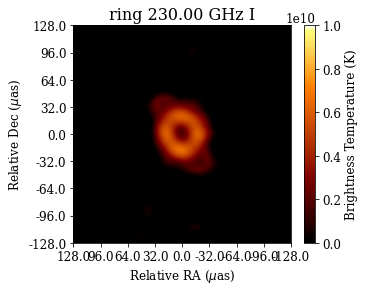

2023-11-22 09:14:12,268 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:14:12,273 INFO Display              :: Penalty--> 300.92068403964106
2023-11-22 09:14:12,579 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:14:12,587 INFO Display              :: Penalty--> 300.92068403964106
2023-11-22 09:14:12,884 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:14:12,884 INFO Display              :: Penalty--> 300.92068403964106
2023-11-22 09:14:13,197 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:14:13,205 INFO Display              :: Penalty--> 300.92068403964106
2023-11-22 09:14:13,503 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:14:13,511 INFO Display              :: Penalty--> 300.92068403964106
2023-11-22 09:14:13,801 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:14:13,809 INFO Display              :: Penalty--> 300.92068403964106
2023-11-22 09:14:14,128 INFO CountIterations      :: iteration = 7 / 2

2995.26879447266
Data Fidelity:  26.92429269274085


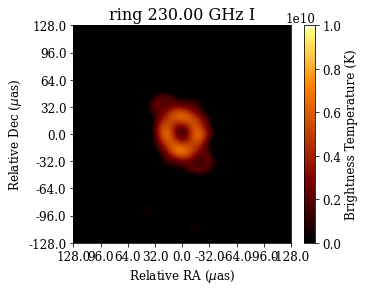

2023-11-22 09:14:20,806 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:14:20,806 INFO Display              :: Penalty--> 300.62497162571907
2023-11-22 09:14:21,110 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:14:21,110 INFO Display              :: Penalty--> 300.62497162571907
2023-11-22 09:14:21,416 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:14:21,416 INFO Display              :: Penalty--> 300.61424628404495
2023-11-22 09:14:21,744 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:14:21,744 INFO Display              :: Penalty--> 300.61424628404495
2023-11-22 09:14:22,056 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:14:22,064 INFO Display              :: Penalty--> 300.61424628404495
2023-11-22 09:14:22,353 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:14:22,353 INFO Display              :: Penalty--> 300.61424628404495
2023-11-22 09:14:22,658 INFO CountIterations      :: iteration = 7 / 2

2995.388652691171
Data Fidelity:  25.948680424206817


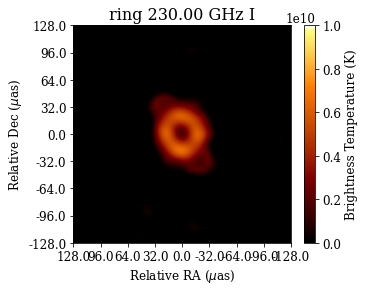

2023-11-22 09:14:29,157 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:14:29,165 INFO Display              :: Penalty--> 300.0458049091662
2023-11-22 09:14:29,479 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:14:29,479 INFO Display              :: Penalty--> 300.0458049091662
2023-11-22 09:14:29,787 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:14:29,787 INFO Display              :: Penalty--> 300.0350795674921
2023-11-22 09:14:30,100 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:14:30,100 INFO Display              :: Penalty--> 300.0350795674921
2023-11-22 09:14:30,391 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:14:30,391 INFO Display              :: Penalty--> 300.0350795674921
2023-11-22 09:14:30,703 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:14:30,703 INFO Display              :: Penalty--> 300.0350795674921
2023-11-22 09:14:31,010 INFO CountIterations      :: iteration = 7 / 25
2023

2995.6072212895274
Data Fidelity:  25.03295420790039


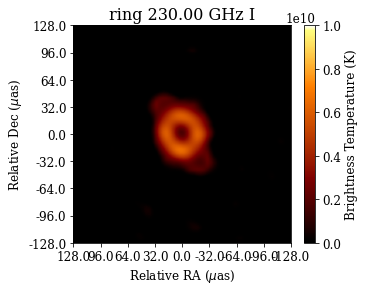

2023-11-22 09:14:37,496 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:14:37,503 INFO Display              :: Penalty--> 299.66275814813304
2023-11-22 09:14:37,809 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:14:37,817 INFO Display              :: Penalty--> 299.652032806459
2023-11-22 09:14:38,114 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:14:38,114 INFO Display              :: Penalty--> 299.48655668429376
2023-11-22 09:14:38,420 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:14:38,420 INFO Display              :: Penalty--> 299.48655668429376
2023-11-22 09:14:38,718 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:14:38,726 INFO Display              :: Penalty--> 299.48655668429376
2023-11-22 09:14:39,024 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:14:39,032 INFO Display              :: Penalty--> 299.48655668429376
2023-11-22 09:14:39,358 INFO CountIterations      :: iteration = 7 / 25


2995.667499639412
Data Fidelity:  24.167779167174672


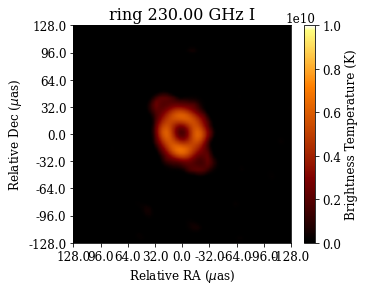

2023-11-22 09:14:45,860 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:14:45,860 INFO Display              :: Penalty--> 299.24906755374536
2023-11-22 09:14:46,174 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:14:46,182 INFO Display              :: Penalty--> 299.2414065954067
2023-11-22 09:14:46,455 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:14:46,455 INFO Display              :: Penalty--> 299.23374563706807
2023-11-22 09:14:46,760 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:14:46,760 INFO Display              :: Penalty--> 299.23374563706807
2023-11-22 09:14:47,048 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:14:47,056 INFO Display              :: Penalty--> 299.23374563706807
2023-11-22 09:14:47,364 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:14:47,364 INFO Display              :: Penalty--> 299.06826951490285
2023-11-22 09:14:47,678 INFO CountIterations      :: iteration = 7 / 25

2995.8005744724833
Data Fidelity:  23.336980271945315


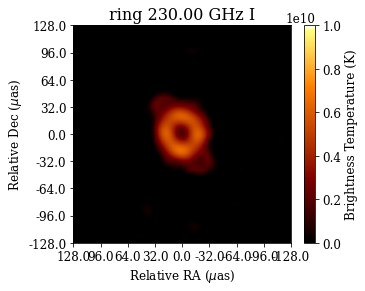

2023-11-22 09:14:54,254 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:14:54,262 INFO Display              :: Penalty--> 298.86142421770904
2023-11-22 09:14:54,554 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:14:54,554 INFO Display              :: Penalty--> 298.86142421770904
2023-11-22 09:14:54,843 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:14:54,843 INFO Display              :: Penalty--> 298.86142421770904
2023-11-22 09:14:55,133 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:14:55,141 INFO Display              :: Penalty--> 298.86142421770904
2023-11-22 09:14:55,438 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:14:55,446 INFO Display              :: Penalty--> 298.6959480955438
2023-11-22 09:14:55,728 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:14:55,736 INFO Display              :: Penalty--> 298.6959480955438
2023-11-22 09:14:56,040 INFO CountIterations      :: iteration = 7 / 25


2995.899627885819
Data Fidelity:  22.557156075676076


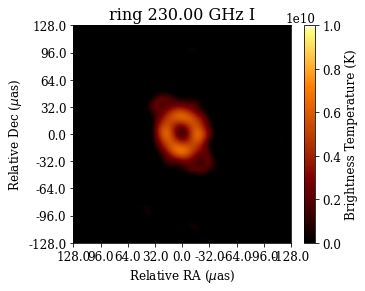

2023-11-22 09:15:02,489 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:15:02,497 INFO Display              :: Penalty--> 298.5197466317045
2023-11-22 09:15:02,793 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:15:02,801 INFO Display              :: Penalty--> 298.5197466317045
2023-11-22 09:15:03,107 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:15:03,107 INFO Display              :: Penalty--> 298.5197466317045
2023-11-22 09:15:03,404 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:15:03,407 INFO Display              :: Penalty--> 298.5197466317045
2023-11-22 09:15:03,697 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:15:03,697 INFO Display              :: Penalty--> 298.5197466317045
2023-11-22 09:15:03,979 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:15:03,979 INFO Display              :: Penalty--> 298.5197466317045
2023-11-22 09:15:04,274 INFO CountIterations      :: iteration = 7 / 25
2023

2996.0506003968294
Data Fidelity:  21.820398522184675


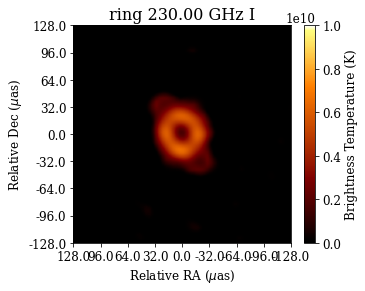

2023-11-22 09:15:10,781 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:15:10,781 INFO Display              :: Penalty--> 298.3680596565995
2023-11-22 09:15:11,072 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:15:11,076 INFO Display              :: Penalty--> 298.3680596565995
2023-11-22 09:15:11,378 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:15:11,378 INFO Display              :: Penalty--> 298.3680596565995
2023-11-22 09:15:11,676 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:15:11,684 INFO Display              :: Penalty--> 298.3680596565995
2023-11-22 09:15:11,989 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:15:11,989 INFO Display              :: Penalty--> 298.20258353443427
2023-11-22 09:15:12,311 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:15:12,311 INFO Display              :: Penalty--> 298.20258353443427
2023-11-22 09:15:12,635 INFO CountIterations      :: iteration = 7 / 25
20

2996.1362645479976
Data Fidelity:  21.114040882152473


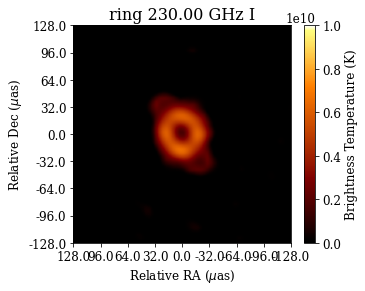

2023-11-22 09:15:19,009 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:15:19,017 INFO Display              :: Penalty--> 298.16427874274115
2023-11-22 09:15:19,340 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:15:19,340 INFO Display              :: Penalty--> 298.16427874274115
2023-11-22 09:15:19,638 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:15:19,638 INFO Display              :: Penalty--> 298.16427874274115
2023-11-22 09:15:19,944 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:15:19,952 INFO Display              :: Penalty--> 298.16427874274115
2023-11-22 09:15:20,243 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:15:20,243 INFO Display              :: Penalty--> 298.16427874274115
2023-11-22 09:15:20,542 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:15:20,551 INFO Display              :: Penalty--> 298.16427874274115
2023-11-22 09:15:20,864 INFO CountIterations      :: iteration = 7 / 2

2996.2698635195725
Data Fidelity:  20.446540290582675


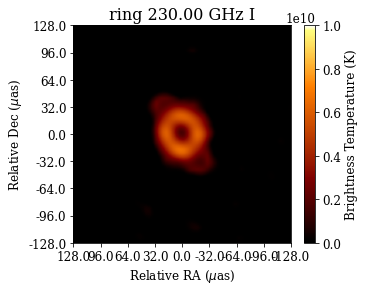

2023-11-22 09:15:27,479 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:15:27,487 INFO Display              :: Penalty--> 297.8455834538033
2023-11-22 09:15:27,784 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:15:27,792 INFO Display              :: Penalty--> 297.8455834538033
2023-11-22 09:15:28,084 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:15:28,092 INFO Display              :: Penalty--> 297.8455834538033
2023-11-22 09:15:28,390 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:15:28,398 INFO Display              :: Penalty--> 297.81493962044874
2023-11-22 09:15:28,705 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:15:28,705 INFO Display              :: Penalty--> 297.81493962044874
2023-11-22 09:15:29,003 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:15:29,012 INFO Display              :: Penalty--> 297.81493962044874
2023-11-22 09:15:29,327 INFO CountIterations      :: iteration = 7 / 25
2

2996.3745279916147
Data Fidelity:  19.81334025140237


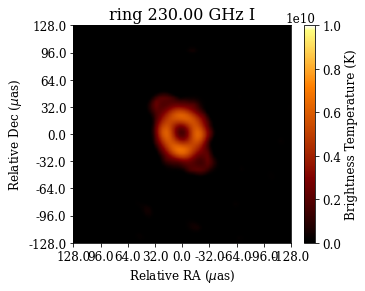

2023-11-22 09:15:35,936 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:15:35,944 INFO Display              :: Penalty--> 297.618819664929
2023-11-22 09:15:36,257 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:15:36,257 INFO Display              :: Penalty--> 297.618819664929
2023-11-22 09:15:36,546 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:15:36,554 INFO Display              :: Penalty--> 297.618819664929
2023-11-22 09:15:36,851 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:15:36,851 INFO Display              :: Penalty--> 297.618819664929
2023-11-22 09:15:37,125 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:15:37,133 INFO Display              :: Penalty--> 297.618819664929
2023-11-22 09:15:37,431 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:15:37,439 INFO Display              :: Penalty--> 297.618819664929
2023-11-22 09:15:37,752 INFO CountIterations      :: iteration = 7 / 25
2023-11-22

2996.4613644767796
Data Fidelity:  19.213835980762003


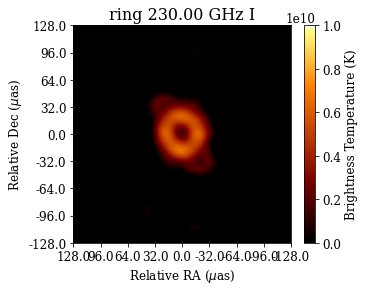

2023-11-22 09:15:44,435 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:15:44,443 INFO Display              :: Penalty--> 297.55753199821993
2023-11-22 09:15:44,747 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:15:44,755 INFO Display              :: Penalty--> 297.55753199821993
2023-11-22 09:15:45,062 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:15:45,062 INFO Display              :: Penalty--> 297.55753199821993
2023-11-22 09:15:45,375 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:15:45,383 INFO Display              :: Penalty--> 297.55753199821993
2023-11-22 09:15:45,656 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:15:45,656 INFO Display              :: Penalty--> 297.55753199821993
2023-11-22 09:15:45,969 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:15:45,969 INFO Display              :: Penalty--> 297.55753199821993
2023-11-22 09:15:46,266 INFO CountIterations      :: iteration = 7 / 2

2996.6051396485454
Data Fidelity:  18.64021943829145


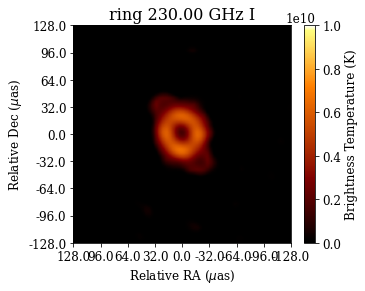

We use  6 scales with threshold 0.5
Current minimum 2776.705459523246
Start optimization with thresholds [0.5 0.5 0.5 0.5 0.5 0.5 0.5]
reverse mode: True
Updated at scale 2 to threshold 0.0 to minimum 2714.8085275438907
Updated at scale 3 to threshold 0.0 to minimum 2712.105401428603
Updated at scale 3 to threshold 4.5 to minimum 2710.663390515079
Updated at scale 6 to threshold 1.0 to minimum 2680.939076919119
Updated at scale 6 to threshold 1.5 to minimum 2662.0774225483638
Updated at scale 6 to threshold 2.0 to minimum 2646.887347442299
Updated at scale 6 to threshold 2.5 to minimum 2627.7714973672264
Updated at scale 6 to threshold 3.0 to minimum 2609.1792802956816
Updated at scale 6 to threshold 3.5 to minimum 2596.137360414932
Updated at scale 6 to threshold 4.0 to minimum 2584.762572616771
Updated at scale 6 to threshold 4.5 to minimum 2571.4753974958285
Updated at scale 6 to threshold 5.0 to minimum 2562.9960294268576
Updated at scale 6 to threshold 5.5 to minimum 2550.81419909

2023-11-22 09:16:19,606 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:16:19,614 INFO Display              :: Penalty--> 776.3221407740305
2023-11-22 09:16:19,946 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:16:19,954 INFO Display              :: Penalty--> 731.8913162392344
2023-11-22 09:16:20,252 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:16:20,258 INFO Display              :: Penalty--> 721.3856348682933
2023-11-22 09:16:20,574 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:16:20,574 INFO Display              :: Penalty--> 712.9892459132736
2023-11-22 09:16:20,872 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:16:20,872 INFO Display              :: Penalty--> 706.4330145275999
2023-11-22 09:16:21,187 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:16:21,195 INFO Display              :: Penalty--> 699.5044623005163
2023-11-22 09:16:21,493 INFO CountIterations      :: iteration = 7 / 25
2023

2761.7928706057774
Data Fidelity:  207.75177395384443


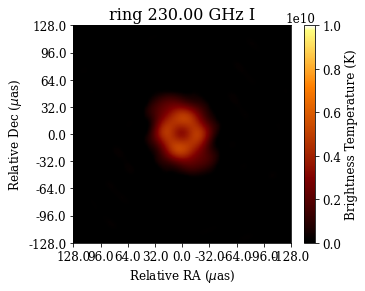

2023-11-22 09:16:28,167 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:16:28,167 INFO Display              :: Penalty--> 617.062586723847
2023-11-22 09:16:28,490 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:16:28,498 INFO Display              :: Penalty--> 617.0012990571379
2023-11-22 09:16:28,796 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:16:28,796 INFO Display              :: Penalty--> 616.3102823488409
2023-11-22 09:16:29,102 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:16:29,102 INFO Display              :: Penalty--> 615.5564463601165
2023-11-22 09:16:29,392 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:16:29,392 INFO Display              :: Penalty--> 614.5160911074763
2023-11-22 09:16:29,691 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:16:29,691 INFO Display              :: Penalty--> 613.3225166880637
2023-11-22 09:16:29,990 INFO CountIterations      :: iteration = 7 / 25
2023-

2952.7484712881314
Data Fidelity:  122.87074849485671


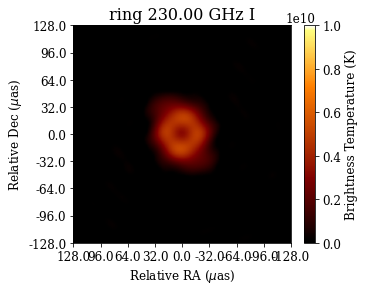

2023-11-22 09:16:36,489 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:16:36,497 INFO Display              :: Penalty--> 587.860630687186
2023-11-22 09:16:36,794 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:16:36,794 INFO Display              :: Penalty--> 587.3258975289972
2023-11-22 09:16:37,094 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:16:37,094 INFO Display              :: Penalty--> 586.365216243079
2023-11-22 09:16:37,375 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:16:37,383 INFO Display              :: Penalty--> 585.1272094212006
2023-11-22 09:16:37,688 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:16:37,696 INFO Display              :: Penalty--> 584.630781054705
2023-11-22 09:16:37,977 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:16:37,985 INFO Display              :: Penalty--> 584.3825665824826
2023-11-22 09:16:38,276 INFO CountIterations      :: iteration = 7 / 25
2023-11

2963.4005682271613
Data Fidelity:  88.48068021144567


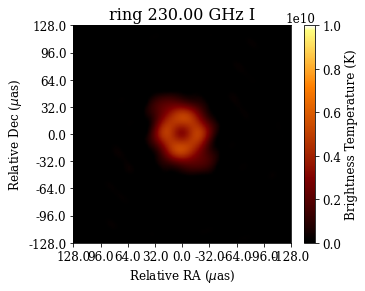

2023-11-22 09:16:44,696 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:16:44,704 INFO Display              :: Penalty--> 574.4861683422006
2023-11-22 09:16:44,995 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:16:45,003 INFO Display              :: Penalty--> 574.2594045533262
2023-11-22 09:16:45,284 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:16:45,284 INFO Display              :: Penalty--> 574.199649078285
2023-11-22 09:16:45,582 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:16:45,590 INFO Display              :: Penalty--> 573.6342720867417
2023-11-22 09:16:45,878 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:16:45,886 INFO Display              :: Penalty--> 573.1271183785718
2023-11-22 09:16:46,194 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:16:46,202 INFO Display              :: Penalty--> 572.920273081378
2023-11-22 09:16:46,483 INFO CountIterations      :: iteration = 7 / 25
2023-1

2970.2355390115517
Data Fidelity:  69.86089570776339


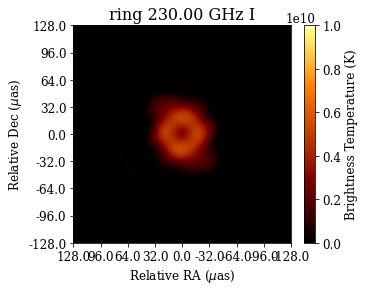

2023-11-22 09:16:52,898 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:16:52,906 INFO Display              :: Penalty--> 565.4891654549757
2023-11-22 09:16:53,178 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:16:53,178 INFO Display              :: Penalty--> 565.4278777882666
2023-11-22 09:16:53,492 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:16:53,500 INFO Display              :: Penalty--> 565.0785392439235
2023-11-22 09:16:53,774 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:16:53,782 INFO Display              :: Penalty--> 564.6556554995294
2023-11-22 09:16:54,070 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:16:54,078 INFO Display              :: Penalty--> 564.4901793773641
2023-11-22 09:16:54,374 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:16:54,374 INFO Display              :: Penalty--> 564.1132613830019
2023-11-22 09:16:54,668 INFO CountIterations      :: iteration = 7 / 25
2023

2975.0616547830714
Data Fidelity:  58.045437809716866


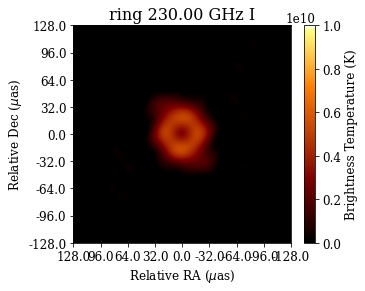

2023-11-22 09:17:01,107 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:17:01,107 INFO Display              :: Penalty--> 559.157163205886
2023-11-22 09:17:01,396 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:17:01,396 INFO Display              :: Penalty--> 559.1157940308575
2023-11-22 09:17:01,677 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:17:01,677 INFO Display              :: Penalty--> 559.0774892391643
2023-11-22 09:17:01,982 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:17:01,982 INFO Display              :: Penalty--> 559.0162015724552
2023-11-22 09:17:02,271 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:17:02,271 INFO Display              :: Penalty--> 559.0162015724552
2023-11-22 09:17:02,560 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:17:02,560 INFO Display              :: Penalty--> 559.0162015724552
2023-11-22 09:17:02,856 INFO CountIterations      :: iteration = 7 / 25
2023-

2978.5615775202104
Data Fidelity:  50.143243780002734


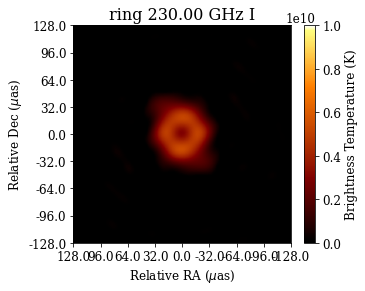

2023-11-22 09:17:09,203 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:17:09,203 INFO Display              :: Penalty--> 555.1903293812284
2023-11-22 09:17:09,516 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:17:09,524 INFO Display              :: Penalty--> 555.1903293812284
2023-11-22 09:17:09,829 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:17:09,829 INFO Display              :: Penalty--> 555.0983978811647
2023-11-22 09:17:10,142 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:17:10,148 INFO Display              :: Penalty--> 555.0983978811647
2023-11-22 09:17:10,448 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:17:10,456 INFO Display              :: Penalty--> 555.0064663811012
2023-11-22 09:17:10,753 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:17:10,761 INFO Display              :: Penalty--> 555.0064663811012
2023-11-22 09:17:11,059 INFO CountIterations      :: iteration = 7 / 25
2023

2981.423519010179
Data Fidelity:  43.868502087833726


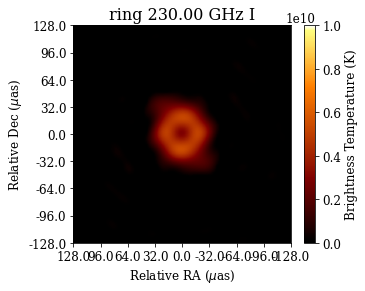

2023-11-22 09:17:17,625 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:17:17,633 INFO Display              :: Penalty--> 550.4456730763093
2023-11-22 09:17:17,931 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:17:17,931 INFO Display              :: Penalty--> 550.218909287435
2023-11-22 09:17:18,244 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:17:18,252 INFO Display              :: Penalty--> 550.2112483290964
2023-11-22 09:17:18,558 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:17:18,558 INFO Display              :: Penalty--> 550.1698791540678
2023-11-22 09:17:18,859 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:17:18,863 INFO Display              :: Penalty--> 549.6428069542176
2023-11-22 09:17:19,176 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:17:19,184 INFO Display              :: Penalty--> 549.3118547098871
2023-11-22 09:17:19,497 INFO CountIterations      :: iteration = 7 / 25
2023-

2983.3855142278744
Data Fidelity:  38.948386584610496


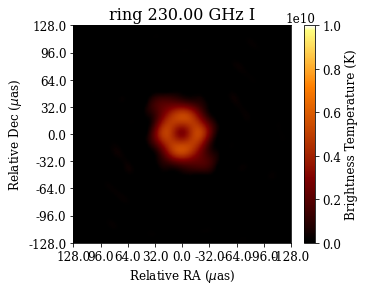

2023-11-22 09:17:26,050 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:17:26,058 INFO Display              :: Penalty--> 544.3756761803502
2023-11-22 09:17:26,357 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:17:26,357 INFO Display              :: Penalty--> 544.2837446802865
2023-11-22 09:17:26,664 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:17:26,664 INFO Display              :: Penalty--> 543.7873163137908
2023-11-22 09:17:26,975 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:17:26,983 INFO Display              :: Penalty--> 543.7459471387622
2023-11-22 09:17:27,266 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:17:27,274 INFO Display              :: Penalty--> 543.7153033054077
2023-11-22 09:17:27,596 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:17:27,599 INFO Display              :: Penalty--> 543.6846594720531
2023-11-22 09:17:27,893 INFO CountIterations      :: iteration = 7 / 25
2023

2985.186242487064
Data Fidelity:  35.15658455131644


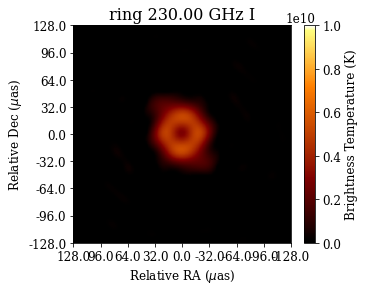

2023-11-22 09:17:34,607 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:17:34,614 INFO Display              :: Penalty--> 541.738781833533
2023-11-22 09:17:34,911 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:17:34,919 INFO Display              :: Penalty--> 541.4078295892026
2023-11-22 09:17:35,231 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:17:35,231 INFO Display              :: Penalty--> 541.2209027836893
2023-11-22 09:17:35,536 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:17:35,544 INFO Display              :: Penalty--> 541.055426661524
2023-11-22 09:17:35,850 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:17:35,858 INFO Display              :: Penalty--> 541.055426661524
2023-11-22 09:17:36,170 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:17:36,170 INFO Display              :: Penalty--> 541.055426661524
2023-11-22 09:17:36,468 INFO CountIterations      :: iteration = 7 / 25
2023-11-

2986.7972579615116
Data Fidelity:  32.01611139657455


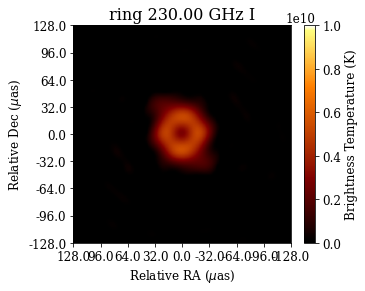

2023-11-22 09:17:43,334 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:17:43,334 INFO Display              :: Penalty--> 539.2106725171752
2023-11-22 09:17:43,631 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:17:43,631 INFO Display              :: Penalty--> 539.2106725171752
2023-11-22 09:17:43,929 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:17:43,937 INFO Display              :: Penalty--> 539.2106725171752
2023-11-22 09:17:44,250 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:17:44,250 INFO Display              :: Penalty--> 539.0451963950101
2023-11-22 09:17:44,555 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:17:44,555 INFO Display              :: Penalty--> 539.0145525616555
2023-11-22 09:17:44,875 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:17:44,883 INFO Display              :: Penalty--> 539.0145525616555
2023-11-22 09:17:45,204 INFO CountIterations      :: iteration = 7 / 25
2023

2987.855134603834
Data Fidelity:  29.370016849962113


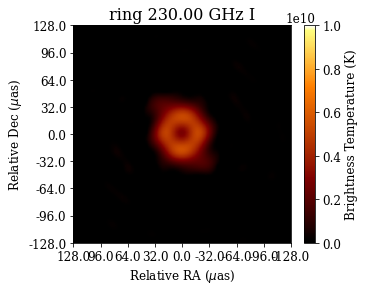

2023-11-22 09:17:51,777 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:17:51,777 INFO Display              :: Penalty--> 537.1177039006039
2023-11-22 09:17:52,091 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:17:52,099 INFO Display              :: Penalty--> 537.0870600672494
2023-11-22 09:17:52,396 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:17:52,396 INFO Display              :: Penalty--> 537.0564162338948
2023-11-22 09:17:52,709 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:17:52,709 INFO Display              :: Penalty--> 537.0257724005403
2023-11-22 09:17:53,029 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:17:53,038 INFO Display              :: Penalty--> 536.8602962783751
2023-11-22 09:17:53,335 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:17:53,335 INFO Display              :: Penalty--> 536.8112661450078
2023-11-22 09:17:53,633 INFO CountIterations      :: iteration = 7 / 25
2023

2988.7407178702524
Data Fidelity:  27.103322194573398


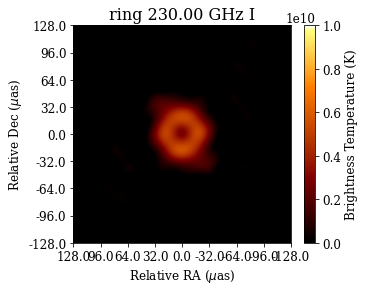

2023-11-22 09:18:00,211 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:18:00,219 INFO Display              :: Penalty--> 535.1488428091185
2023-11-22 09:18:00,522 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:18:00,530 INFO Display              :: Penalty--> 535.1488428091185
2023-11-22 09:18:00,837 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:18:00,837 INFO Display              :: Penalty--> 534.9220790202442
2023-11-22 09:18:01,142 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:18:01,142 INFO Display              :: Penalty--> 534.9220790202442
2023-11-22 09:18:01,447 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:18:01,447 INFO Display              :: Penalty--> 534.9220790202442
2023-11-22 09:18:01,746 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:18:01,754 INFO Display              :: Penalty--> 534.7489419397403
2023-11-22 09:18:02,051 INFO CountIterations      :: iteration = 7 / 25
2023

2989.9000838335423
Data Fidelity:  25.052093118111205


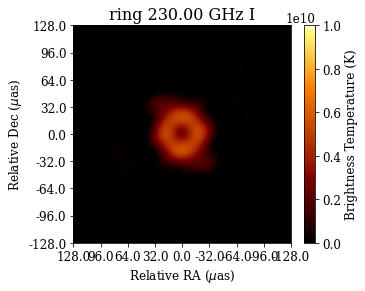

2023-11-22 09:18:08,586 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:18:08,594 INFO Display              :: Penalty--> 532.5196099985892
2023-11-22 09:18:08,899 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:18:08,907 INFO Display              :: Penalty--> 532.5196099985892
2023-11-22 09:18:09,220 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:18:09,220 INFO Display              :: Penalty--> 532.5196099985892
2023-11-22 09:18:09,533 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:18:09,541 INFO Display              :: Penalty--> 532.4889661652347
2023-11-22 09:18:09,837 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:18:09,841 INFO Display              :: Penalty--> 532.4889661652347
2023-11-22 09:18:10,125 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:18:10,133 INFO Display              :: Penalty--> 532.3127647013953
2023-11-22 09:18:10,414 INFO CountIterations      :: iteration = 7 / 25
2023

2990.3458321105854
Data Fidelity:  23.306992338922356


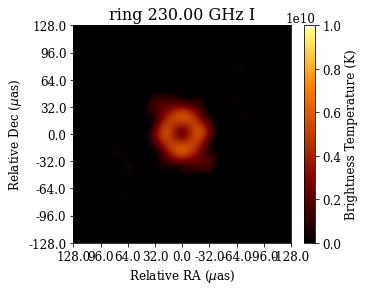

2023-11-22 09:18:16,946 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:18:16,953 INFO Display              :: Penalty--> 530.7867058459844
2023-11-22 09:18:17,250 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:18:17,258 INFO Display              :: Penalty--> 530.7867058459844
2023-11-22 09:18:17,563 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:18:17,571 INFO Display              :: Penalty--> 530.6105043821451
2023-11-22 09:18:17,860 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:18:17,860 INFO Display              :: Penalty--> 530.5798605487905
2023-11-22 09:18:18,180 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:18:18,188 INFO Display              :: Penalty--> 530.4143844266254
2023-11-22 09:18:18,494 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:18:18,494 INFO Display              :: Penalty--> 530.0757712239563
2023-11-22 09:18:18,784 INFO CountIterations      :: iteration = 7 / 25
2023

2991.0651357071133
Data Fidelity:  21.766016263609092


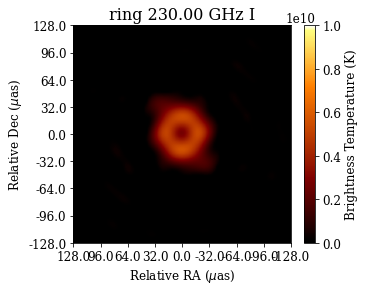

2023-11-22 09:18:25,310 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:18:25,318 INFO Display              :: Penalty--> 528.381172440994
2023-11-22 09:18:25,623 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:18:25,623 INFO Display              :: Penalty--> 528.3505286076395
2023-11-22 09:18:25,920 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:18:25,928 INFO Display              :: Penalty--> 528.1544086521197
2023-11-22 09:18:26,241 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:18:26,241 INFO Display              :: Penalty--> 527.9889325299545
2023-11-22 09:18:26,530 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:18:26,537 INFO Display              :: Penalty--> 527.9889325299545
2023-11-22 09:18:26,836 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:18:26,844 INFO Display              :: Penalty--> 527.9506277382613
2023-11-22 09:18:27,148 INFO CountIterations      :: iteration = 7 / 25
2023-

2991.7224358504113
Data Fidelity:  20.40302745625275


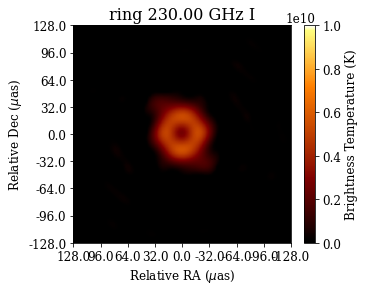

2023-11-22 09:18:33,698 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:18:33,706 INFO Display              :: Penalty--> 526.628350374658
2023-11-22 09:18:33,996 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:18:33,996 INFO Display              :: Penalty--> 526.5977065413034
2023-11-22 09:18:34,301 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:18:34,309 INFO Display              :: Penalty--> 526.5670627079489
2023-11-22 09:18:34,622 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:18:34,622 INFO Display              :: Penalty--> 526.5594017496103
2023-11-22 09:18:34,926 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:18:34,926 INFO Display              :: Penalty--> 526.5517407912718
2023-11-22 09:18:35,222 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:18:35,230 INFO Display              :: Penalty--> 526.2207885469413
2023-11-22 09:18:35,552 INFO CountIterations      :: iteration = 7 / 25
2023-

2992.213294227925
Data Fidelity:  19.2021998604258


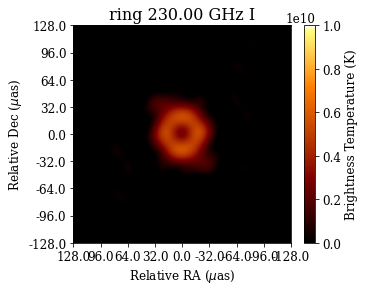

2023-11-22 09:18:42,187 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:18:42,195 INFO Display              :: Penalty--> 525.5313040303121
2023-11-22 09:18:42,532 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:18:42,532 INFO Display              :: Penalty--> 525.5313040303121
2023-11-22 09:18:42,852 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:18:42,852 INFO Display              :: Penalty--> 525.3658279081469
2023-11-22 09:18:43,164 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:18:43,172 INFO Display              :: Penalty--> 525.3658279081469
2023-11-22 09:18:43,480 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:18:43,486 INFO Display              :: Penalty--> 525.3658279081469
2023-11-22 09:18:43,814 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:18:43,822 INFO Display              :: Penalty--> 525.3351840747923
2023-11-22 09:18:44,135 INFO CountIterations      :: iteration = 7 / 25
2023

2992.7590494923998
Data Fidelity:  18.11609454441134


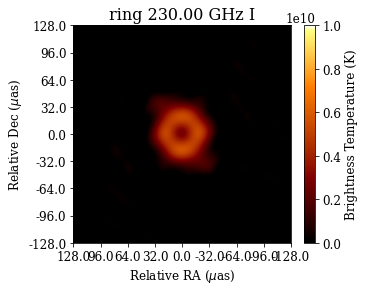

2023-11-22 09:18:50,765 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:18:50,773 INFO Display              :: Penalty--> 524.3024897804909
2023-11-22 09:18:51,078 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:18:51,087 INFO Display              :: Penalty--> 524.3024897804909
2023-11-22 09:18:51,383 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:18:51,387 INFO Display              :: Penalty--> 524.1262883166515
2023-11-22 09:18:51,687 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:18:51,695 INFO Display              :: Penalty--> 524.0879835249583
2023-11-22 09:18:52,032 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:18:52,032 INFO Display              :: Penalty--> 523.9225074027931
2023-11-22 09:18:52,328 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:18:52,336 INFO Display              :: Penalty--> 523.7493703222892
2023-11-22 09:18:52,640 INFO CountIterations      :: iteration = 7 / 25
2023

2993.096988777468
Data Fidelity:  17.116380715713028


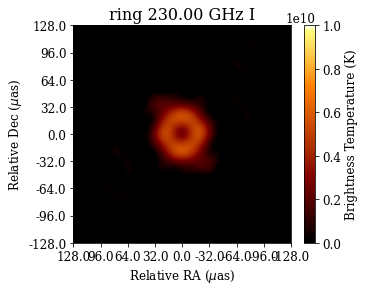

2023-11-22 09:18:59,264 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:18:59,264 INFO Display              :: Penalty--> 522.6431314058862
2023-11-22 09:18:59,582 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:18:59,585 INFO Display              :: Penalty--> 522.6431314058862
2023-11-22 09:18:59,890 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:18:59,890 INFO Display              :: Penalty--> 522.6431314058862
2023-11-22 09:19:00,188 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:19:00,197 INFO Display              :: Penalty--> 522.6431314058862
2023-11-22 09:19:00,517 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:19:00,517 INFO Display              :: Penalty--> 522.6431314058862
2023-11-22 09:19:00,821 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:19:00,821 INFO Display              :: Penalty--> 522.6431314058862
2023-11-22 09:19:01,142 INFO CountIterations      :: iteration = 7 / 25
2023

2993.5048872091875
Data Fidelity:  16.200805853599892


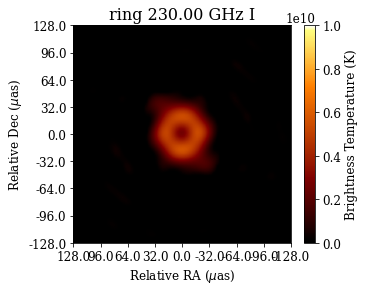

2023-11-22 09:19:07,806 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:19:07,814 INFO Display              :: Penalty--> 520.9393394729176
2023-11-22 09:19:08,112 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:19:08,121 INFO Display              :: Penalty--> 520.9393394729176
2023-11-22 09:19:08,431 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:19:08,435 INFO Display              :: Penalty--> 520.7432195173977
2023-11-22 09:19:08,740 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:19:08,748 INFO Display              :: Penalty--> 520.7432195173977
2023-11-22 09:19:09,061 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:19:09,061 INFO Display              :: Penalty--> 520.7432195173977
2023-11-22 09:19:09,374 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:19:09,382 INFO Display              :: Penalty--> 520.7432195173977
2023-11-22 09:19:09,688 INFO CountIterations      :: iteration = 7 / 25
2023

2993.8146353684324
Data Fidelity:  15.397701461900425


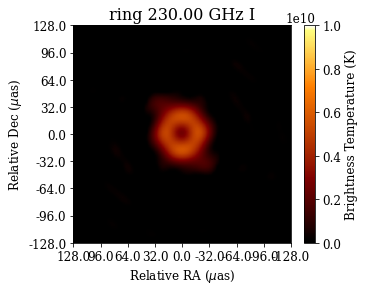

2023-11-22 09:19:16,564 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:19:16,564 INFO Display              :: Penalty--> 520.0537350007686
2023-11-22 09:19:16,861 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:19:16,861 INFO Display              :: Penalty--> 520.0537350007686
2023-11-22 09:19:17,134 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:19:17,142 INFO Display              :: Penalty--> 520.0537350007686
2023-11-22 09:19:17,448 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:19:17,456 INFO Display              :: Penalty--> 519.8576150452487
2023-11-22 09:19:17,744 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:19:17,744 INFO Display              :: Penalty--> 519.6814135814095
2023-11-22 09:19:18,049 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:19:18,057 INFO Display              :: Penalty--> 519.650769748055
2023-11-22 09:19:18,361 INFO CountIterations      :: iteration = 7 / 25
2023-

2994.1487160615907
Data Fidelity:  14.623328793858107


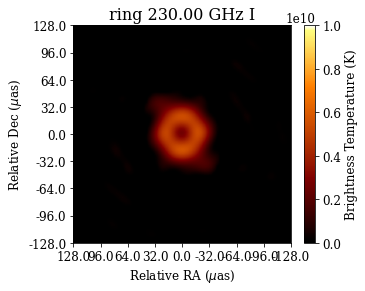

2023-11-22 09:19:24,896 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:19:24,896 INFO Display              :: Penalty--> 518.4112301565598
2023-11-22 09:19:25,202 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:19:25,202 INFO Display              :: Penalty--> 518.4112301565598
2023-11-22 09:19:25,526 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:19:25,534 INFO Display              :: Penalty--> 518.4112301565598
2023-11-22 09:19:25,824 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:19:25,824 INFO Display              :: Penalty--> 518.4112301565598
2023-11-22 09:19:26,137 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:19:26,137 INFO Display              :: Penalty--> 518.4112301565598
2023-11-22 09:19:26,436 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:19:26,444 INFO Display              :: Penalty--> 518.3805863232052
2023-11-22 09:19:26,748 INFO CountIterations      :: iteration = 7 / 25
2023

2994.3983288170975
Data Fidelity:  13.928817702849601


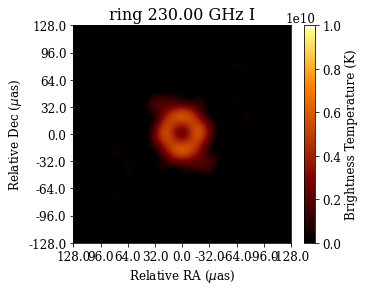

2023-11-22 09:19:33,244 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:19:33,252 INFO Display              :: Penalty--> 516.7595321623445
2023-11-22 09:19:33,550 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:19:33,550 INFO Display              :: Penalty--> 516.7288883289899
2023-11-22 09:19:33,839 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:19:33,839 INFO Display              :: Penalty--> 516.3979360846595
2023-11-22 09:19:34,171 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:19:34,176 INFO Display              :: Penalty--> 516.3979360846595
2023-11-22 09:19:34,472 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:19:34,480 INFO Display              :: Penalty--> 516.3979360846595
2023-11-22 09:19:34,762 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:19:34,770 INFO Display              :: Penalty--> 516.3979360846595
2023-11-22 09:19:35,059 INFO CountIterations      :: iteration = 7 / 25
2023

2994.812917952999
Data Fidelity:  13.308801282614317


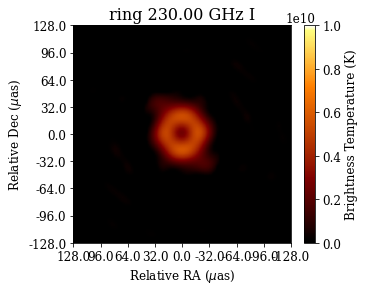

2023-11-22 09:19:41,554 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:19:41,554 INFO Display              :: Penalty--> 516.3075367762636
2023-11-22 09:19:41,858 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:19:41,866 INFO Display              :: Penalty--> 516.3075367762636
2023-11-22 09:19:42,170 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:19:42,170 INFO Display              :: Penalty--> 516.1313353124243
2023-11-22 09:19:42,466 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:19:42,466 INFO Display              :: Penalty--> 516.1313353124243
2023-11-22 09:19:42,763 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:19:42,771 INFO Display              :: Penalty--> 516.1313353124243
2023-11-22 09:19:43,075 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:19:43,083 INFO Display              :: Penalty--> 516.1006914790697
2023-11-22 09:19:43,365 INFO CountIterations      :: iteration = 7 / 25
2023

2995.0979113913904
Data Fidelity:  12.734529347535334


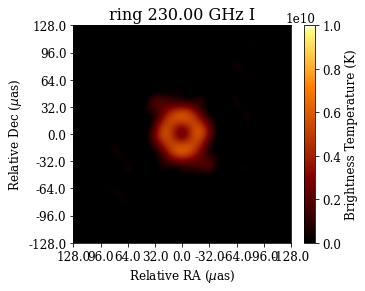

2023-11-22 09:19:49,793 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:19:49,801 INFO Display              :: Penalty--> 515.7099831817487
2023-11-22 09:19:50,081 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:19:50,089 INFO Display              :: Penalty--> 515.5445070595836
2023-11-22 09:19:50,380 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:19:50,388 INFO Display              :: Penalty--> 515.5445070595836
2023-11-22 09:19:50,694 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:19:50,694 INFO Display              :: Penalty--> 515.5445070595836
2023-11-22 09:19:50,977 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:19:50,985 INFO Display              :: Penalty--> 515.3683055957441
2023-11-22 09:19:51,290 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:19:51,298 INFO Display              :: Penalty--> 515.3683055957441
2023-11-22 09:19:51,596 INFO CountIterations      :: iteration = 7 / 25
2023

2995.194289695364
Data Fidelity:  12.195159776583466


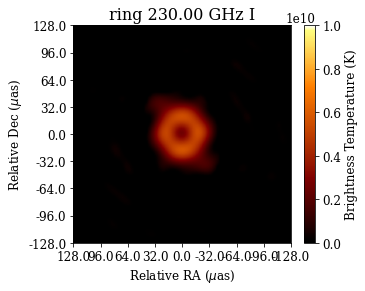

2023-11-22 09:19:58,055 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:19:58,055 INFO Display              :: Penalty--> 514.5960827290577
2023-11-22 09:19:58,344 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:19:58,352 INFO Display              :: Penalty--> 514.5960827290577
2023-11-22 09:19:58,698 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:19:58,703 INFO Display              :: Penalty--> 514.5960827290577
2023-11-22 09:19:59,004 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:19:59,004 INFO Display              :: Penalty--> 514.5960827290577
2023-11-22 09:19:59,309 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:19:59,309 INFO Display              :: Penalty--> 514.5960827290577
2023-11-22 09:19:59,607 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:19:59,607 INFO Display              :: Penalty--> 514.5960827290577
2023-11-22 09:19:59,912 INFO CountIterations      :: iteration = 7 / 25
2023

2995.4137040782884
Data Fidelity:  11.702901770606811


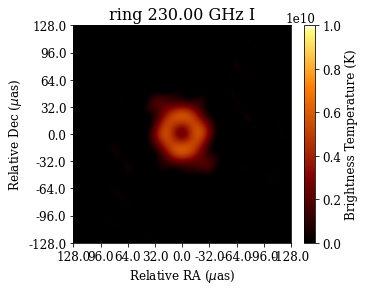

2023-11-22 09:20:06,376 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:20:06,384 INFO Display              :: Penalty--> 513.7380582848771
2023-11-22 09:20:06,674 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:20:06,680 INFO Display              :: Penalty--> 513.7380582848771
2023-11-22 09:20:06,988 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:20:06,988 INFO Display              :: Penalty--> 513.7380582848771
2023-11-22 09:20:07,317 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:20:07,317 INFO Display              :: Penalty--> 513.7380582848771
2023-11-22 09:20:07,622 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:20:07,630 INFO Display              :: Penalty--> 513.7380582848771
2023-11-22 09:20:07,918 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:20:07,926 INFO Display              :: Penalty--> 513.5725821627119
2023-11-22 09:20:08,231 INFO CountIterations      :: iteration = 7 / 25
2023

2995.607760553399
Data Fidelity:  11.23305270326988


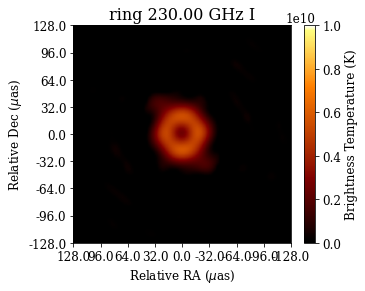

2023-11-22 09:20:14,743 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:20:14,743 INFO Display              :: Penalty--> 512.7666516572848
2023-11-22 09:20:15,069 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:20:15,072 INFO Display              :: Penalty--> 512.7666516572848
2023-11-22 09:20:15,387 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:20:15,387 INFO Display              :: Penalty--> 512.6011755351195
2023-11-22 09:20:15,720 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:20:15,723 INFO Display              :: Penalty--> 512.6011755351195
2023-11-22 09:20:16,020 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:20:16,028 INFO Display              :: Penalty--> 512.6011755351195
2023-11-22 09:20:16,333 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:20:16,333 INFO Display              :: Penalty--> 512.4356994129544
2023-11-22 09:20:16,654 INFO CountIterations      :: iteration = 7 / 25
2023

2995.741522066157
Data Fidelity:  10.813848712138704


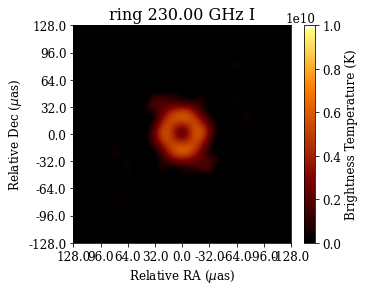

2023-11-22 09:20:23,338 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:20:23,338 INFO Display              :: Penalty--> 511.67420246589126
2023-11-22 09:20:23,659 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:20:23,659 INFO Display              :: Penalty--> 511.67420246589126
2023-11-22 09:20:23,964 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:20:23,972 INFO Display              :: Penalty--> 511.67420246589126
2023-11-22 09:20:24,285 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:20:24,285 INFO Display              :: Penalty--> 511.67420246589126
2023-11-22 09:20:24,597 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:20:24,598 INFO Display              :: Penalty--> 511.6052538408435
2023-11-22 09:20:24,897 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:20:24,905 INFO Display              :: Penalty--> 511.6052538408435
2023-11-22 09:20:25,185 INFO CountIterations      :: iteration = 7 / 25


2995.89695027143
Data Fidelity:  10.4147639336168


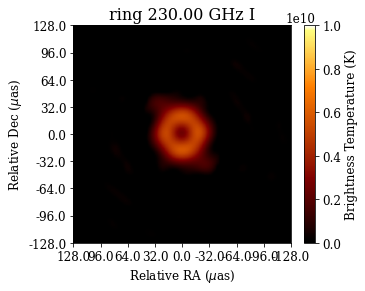

2023-11-22 09:20:32,012 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:20:32,020 INFO Display              :: Penalty--> 510.9985076742715
2023-11-22 09:20:32,341 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:20:32,341 INFO Display              :: Penalty--> 510.9985076742715
2023-11-22 09:20:32,656 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:20:32,656 INFO Display              :: Penalty--> 510.9985076742715
2023-11-22 09:20:32,992 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:20:32,992 INFO Display              :: Penalty--> 510.9985076742715
2023-11-22 09:20:33,296 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:20:33,296 INFO Display              :: Penalty--> 510.9985076742715
2023-11-22 09:20:33,626 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:20:33,626 INFO Display              :: Penalty--> 510.9985076742715
2023-11-22 09:20:33,947 INFO CountIterations      :: iteration = 7 / 25
2023

2996.058086984961
Data Fidelity:  10.05708148817614


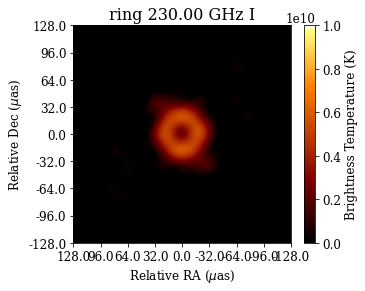

2023-11-22 09:20:40,793 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:20:40,793 INFO Display              :: Penalty--> 509.9448906938194
2023-11-22 09:20:41,137 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:20:41,145 INFO Display              :: Penalty--> 509.93416535214527
2023-11-22 09:20:41,484 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:20:41,484 INFO Display              :: Penalty--> 509.93416535214527
2023-11-22 09:20:41,836 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:20:41,836 INFO Display              :: Penalty--> 509.93416535214527
2023-11-22 09:20:42,174 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:20:42,182 INFO Display              :: Penalty--> 509.93416535214527
2023-11-22 09:20:42,496 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:20:42,504 INFO Display              :: Penalty--> 509.76868922998
2023-11-22 09:20:42,833 INFO CountIterations      :: iteration = 7 / 25
20

2996.2849540701445
Data Fidelity:  9.722326904470753


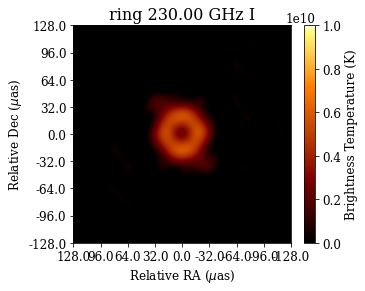

2023-11-22 09:20:50,348 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:20:50,356 INFO Display              :: Penalty--> 509.32741918557326
2023-11-22 09:20:50,652 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:20:50,660 INFO Display              :: Penalty--> 509.28911439388014
2023-11-22 09:20:50,957 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:20:50,965 INFO Display              :: Penalty--> 509.28911439388014
2023-11-22 09:20:51,247 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:20:51,247 INFO Display              :: Penalty--> 509.28911439388014
2023-11-22 09:20:51,536 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:20:51,536 INFO Display              :: Penalty--> 509.28911439388014
2023-11-22 09:20:51,856 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:20:51,866 INFO Display              :: Penalty--> 509.123638271715
2023-11-22 09:20:52,169 INFO CountIterations      :: iteration = 7 / 25


2996.3652786932626
Data Fidelity:  9.405913476004596


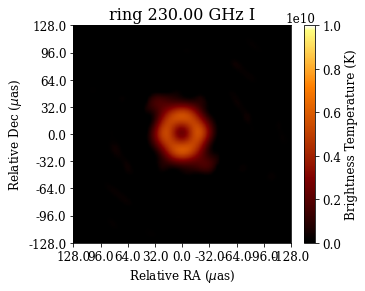

2023-11-22 09:20:58,743 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:20:58,743 INFO Display              :: Penalty--> 507.8840986802196
2023-11-22 09:20:59,056 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:20:59,064 INFO Display              :: Penalty--> 507.8840986802196
2023-11-22 09:20:59,370 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:20:59,370 INFO Display              :: Penalty--> 507.8840986802196
2023-11-22 09:20:59,668 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:20:59,668 INFO Display              :: Penalty--> 507.8534548468651
2023-11-22 09:20:59,973 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:20:59,981 INFO Display              :: Penalty--> 507.82281101351055
2023-11-22 09:21:00,302 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:21:00,310 INFO Display              :: Penalty--> 507.82281101351055
2023-11-22 09:21:00,606 INFO CountIterations      :: iteration = 7 / 25
20

2996.5200735252447
Data Fidelity:  9.113458880466032


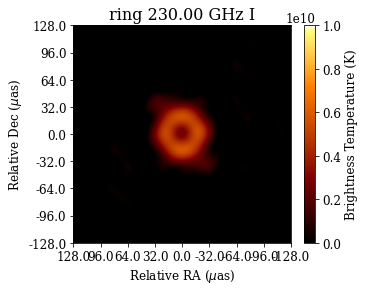

2023-11-22 09:21:07,192 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:21:07,200 INFO Display              :: Penalty--> 507.48113342750605
2023-11-22 09:21:07,504 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:21:07,512 INFO Display              :: Penalty--> 507.48113342750605
2023-11-22 09:21:07,817 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:21:07,828 INFO Display              :: Penalty--> 507.4504895941515
2023-11-22 09:21:08,141 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:21:08,146 INFO Display              :: Penalty--> 507.28501347198625
2023-11-22 09:21:08,441 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:21:08,443 INFO Display              :: Penalty--> 507.27428813031213
2023-11-22 09:21:08,741 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:21:08,748 INFO Display              :: Penalty--> 507.10881200814697
2023-11-22 09:21:09,052 INFO CountIterations      :: iteration = 7 / 25

2996.677259511105
Data Fidelity:  8.836559425444676


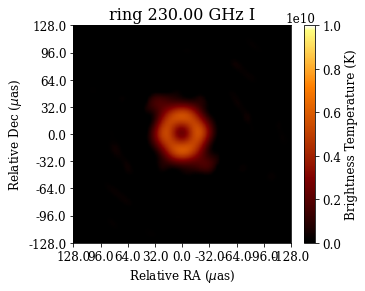

2023-11-22 09:21:15,672 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:21:15,672 INFO Display              :: Penalty--> 506.66447758040476
2023-11-22 09:21:15,969 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:21:15,969 INFO Display              :: Penalty--> 506.66447758040476
2023-11-22 09:21:16,275 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:21:16,275 INFO Display              :: Penalty--> 506.66447758040476
2023-11-22 09:21:16,589 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:21:16,597 INFO Display              :: Penalty--> 506.63383374705023
2023-11-22 09:21:16,894 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:21:16,902 INFO Display              :: Penalty--> 506.63383374705023
2023-11-22 09:21:17,207 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:21:17,215 INFO Display              :: Penalty--> 506.6031899136957
2023-11-22 09:21:17,512 INFO CountIterations      :: iteration = 7 / 25

2996.7536654666656
Data Fidelity:  8.574960018469458


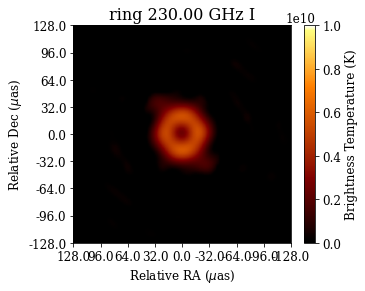

2023-11-22 09:21:23,959 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:21:23,961 INFO Display              :: Penalty--> 506.0546664525481
2023-11-22 09:21:24,250 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:21:24,250 INFO Display              :: Penalty--> 506.0546664525481
2023-11-22 09:21:24,561 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:21:24,563 INFO Display              :: Penalty--> 506.0546664525481
2023-11-22 09:21:24,867 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:21:24,875 INFO Display              :: Penalty--> 506.0546664525481
2023-11-22 09:21:25,164 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:21:25,172 INFO Display              :: Penalty--> 506.0546664525481
2023-11-22 09:21:25,477 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:21:25,485 INFO Display              :: Penalty--> 506.0546664525481
2023-11-22 09:21:25,758 INFO CountIterations      :: iteration = 7 / 25
2023

2996.911715844055
Data Fidelity:  8.34826799943089


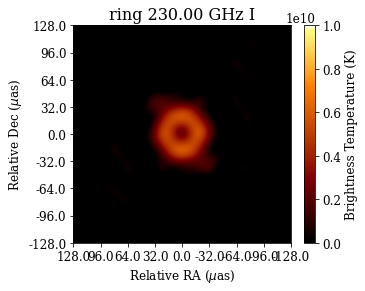

2023-11-22 09:21:32,397 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:21:32,397 INFO Display              :: Penalty--> 505.8478211553542
2023-11-22 09:21:32,687 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:21:32,695 INFO Display              :: Penalty--> 505.8478211553542
2023-11-22 09:21:33,025 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:21:33,025 INFO Display              :: Penalty--> 505.8478211553542
2023-11-22 09:21:33,297 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:21:33,297 INFO Display              :: Penalty--> 505.8478211553542
2023-11-22 09:21:33,602 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:21:33,610 INFO Display              :: Penalty--> 505.8478211553542
2023-11-22 09:21:33,914 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:21:33,914 INFO Display              :: Penalty--> 505.8478211553542
2023-11-22 09:21:34,210 INFO CountIterations      :: iteration = 7 / 25
2023

2997.0118380694626
Data Fidelity:  8.119729365221584


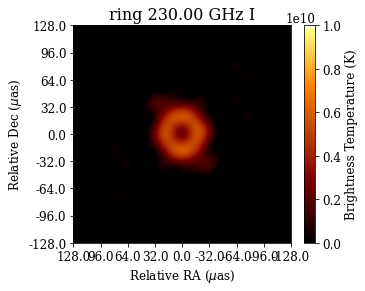

2023-11-22 09:21:40,816 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:21:40,824 INFO Display              :: Penalty--> 505.2594612887949
2023-11-22 09:21:41,114 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:21:41,122 INFO Display              :: Penalty--> 505.2594612887949
2023-11-22 09:21:41,442 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:21:41,442 INFO Display              :: Penalty--> 505.2594612887949
2023-11-22 09:21:41,754 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:21:41,754 INFO Display              :: Penalty--> 505.2288174554404
2023-11-22 09:21:42,051 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:21:42,059 INFO Display              :: Penalty--> 505.2288174554404
2023-11-22 09:21:42,357 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:21:42,357 INFO Display              :: Penalty--> 505.06334133327516
2023-11-22 09:21:42,654 INFO CountIterations      :: iteration = 7 / 25
202

2997.1496654561515
Data Fidelity:  7.907175067685845


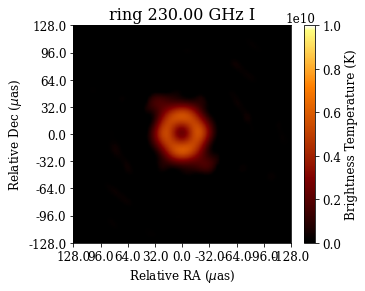

2023-11-22 09:21:49,399 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:21:49,407 INFO Display              :: Penalty--> 504.8151268610527
2023-11-22 09:21:49,712 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:21:49,712 INFO Display              :: Penalty--> 504.8151268610527
2023-11-22 09:21:50,017 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:21:50,017 INFO Display              :: Penalty--> 504.8151268610527
2023-11-22 09:21:50,338 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:21:50,338 INFO Display              :: Penalty--> 504.8151268610527
2023-11-22 09:21:50,651 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:21:50,659 INFO Display              :: Penalty--> 504.8151268610527
2023-11-22 09:21:50,964 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:21:50,972 INFO Display              :: Penalty--> 504.7844830276982
2023-11-22 09:21:51,290 INFO CountIterations      :: iteration = 7 / 25
2023

2997.2096313061766
Data Fidelity:  7.713970764522807


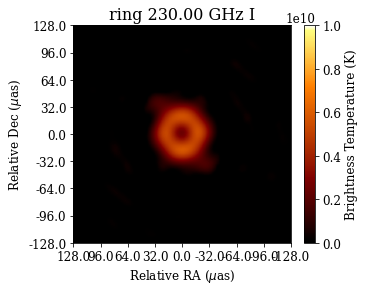

2023-11-22 09:21:58,016 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:21:58,024 INFO Display              :: Penalty--> 504.38917873332326
2023-11-22 09:21:58,329 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:21:58,337 INFO Display              :: Penalty--> 504.38917873332326
2023-11-22 09:21:58,658 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:21:58,661 INFO Display              :: Penalty--> 504.38917873332326
2023-11-22 09:21:58,978 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:21:58,986 INFO Display              :: Penalty--> 504.38917873332326
2023-11-22 09:21:59,275 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:21:59,275 INFO Display              :: Penalty--> 504.22370261115805
2023-11-22 09:21:59,596 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:21:59,600 INFO Display              :: Penalty--> 504.22370261115805
2023-11-22 09:21:59,909 INFO CountIterations      :: iteration = 7 / 2

2997.291528753276
Data Fidelity:  7.518398017960254


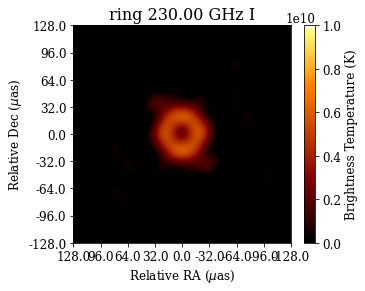

2023-11-22 09:22:06,637 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:22:06,637 INFO Display              :: Penalty--> 503.6353427445988
2023-11-22 09:22:06,959 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:22:06,967 INFO Display              :: Penalty--> 503.6353427445988
2023-11-22 09:22:07,280 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:22:07,280 INFO Display              :: Penalty--> 503.6353427445988
2023-11-22 09:22:07,601 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:22:07,601 INFO Display              :: Penalty--> 503.6353427445988
2023-11-22 09:22:07,922 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:22:07,922 INFO Display              :: Penalty--> 503.6353427445988
2023-11-22 09:22:08,234 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:22:08,234 INFO Display              :: Penalty--> 503.6246174029247
2023-11-22 09:22:08,530 INFO CountIterations      :: iteration = 7 / 25
2023

2997.370010606178
Data Fidelity:  7.345329275344947


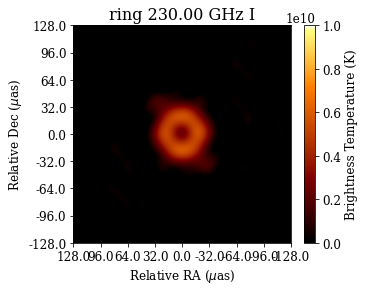

2023-11-22 09:22:15,379 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:22:15,387 INFO Display              :: Penalty--> 503.53268590286115
2023-11-22 09:22:15,716 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:22:15,719 INFO Display              :: Penalty--> 503.53268590286115
2023-11-22 09:22:16,031 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:22:16,039 INFO Display              :: Penalty--> 503.53268590286115
2023-11-22 09:22:16,344 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:22:16,352 INFO Display              :: Penalty--> 503.53268590286115
2023-11-22 09:22:16,689 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:22:16,689 INFO Display              :: Penalty--> 503.50204206950656
2023-11-22 09:22:16,993 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:22:17,001 INFO Display              :: Penalty--> 503.50204206950656
2023-11-22 09:22:17,338 INFO CountIterations      :: iteration = 7 / 2

2997.478093579686
Data Fidelity:  7.184686305892333


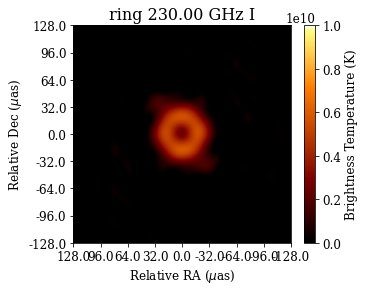

2023-11-22 09:22:24,619 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:22:24,627 INFO Display              :: Penalty--> 503.3258406056673
2023-11-22 09:22:24,939 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:22:24,947 INFO Display              :: Penalty--> 503.3258406056673
2023-11-22 09:22:25,260 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:22:25,268 INFO Display              :: Penalty--> 503.3258406056673
2023-11-22 09:22:25,565 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:22:25,565 INFO Display              :: Penalty--> 503.3258406056673
2023-11-22 09:22:25,878 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:22:25,886 INFO Display              :: Penalty--> 503.3258406056673
2023-11-22 09:22:26,191 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:22:26,191 INFO Display              :: Penalty--> 503.3258406056673
2023-11-22 09:22:26,496 INFO CountIterations      :: iteration = 7 / 25
2023

2997.5239577289994
Data Fidelity:  7.028408040058256


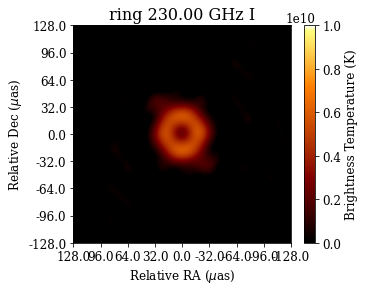

2023-11-22 09:22:33,083 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:22:33,091 INFO Display              :: Penalty--> 503.03012819174523
2023-11-22 09:22:33,387 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:22:33,395 INFO Display              :: Penalty--> 503.03012819174523
2023-11-22 09:22:33,692 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:22:33,700 INFO Display              :: Penalty--> 503.03012819174523
2023-11-22 09:22:34,031 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:22:34,031 INFO Display              :: Penalty--> 503.03012819174523
2023-11-22 09:22:34,342 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:22:34,350 INFO Display              :: Penalty--> 503.03012819174523
2023-11-22 09:22:34,662 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:22:34,670 INFO Display              :: Penalty--> 502.8340082362255
2023-11-22 09:22:34,992 INFO CountIterations      :: iteration = 7 / 25

2997.5700706488906
Data Fidelity:  6.872391676591352


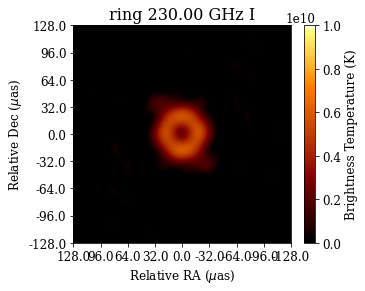

2023-11-22 09:22:41,532 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:22:41,540 INFO Display              :: Penalty--> 502.54595678064214
2023-11-22 09:22:41,828 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:22:41,828 INFO Display              :: Penalty--> 502.54595678064214
2023-11-22 09:22:42,134 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:22:42,134 INFO Display              :: Penalty--> 502.54595678064214
2023-11-22 09:22:42,452 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:22:42,456 INFO Display              :: Penalty--> 502.54595678064214
2023-11-22 09:22:42,746 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:22:42,752 INFO Display              :: Penalty--> 502.5153129472876
2023-11-22 09:22:43,063 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:22:43,068 INFO Display              :: Penalty--> 502.5153129472876
2023-11-22 09:22:43,357 INFO CountIterations      :: iteration = 7 / 25


2997.674710446607
Data Fidelity:  6.730281013401397


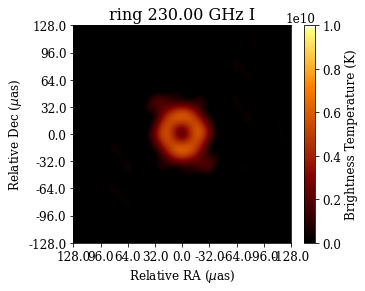

2023-11-22 09:22:49,945 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:22:49,953 INFO Display              :: Penalty--> 502.1858923166757
2023-11-22 09:22:50,251 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:22:50,260 INFO Display              :: Penalty--> 502.1858923166757
2023-11-22 09:22:50,556 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:22:50,564 INFO Display              :: Penalty--> 502.1858923166757
2023-11-22 09:22:50,877 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:22:50,885 INFO Display              :: Penalty--> 502.02041619451046
2023-11-22 09:22:51,183 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:22:51,191 INFO Display              :: Penalty--> 501.85494007234524
2023-11-22 09:22:51,513 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:22:51,513 INFO Display              :: Penalty--> 501.85494007234524
2023-11-22 09:22:51,801 INFO CountIterations      :: iteration = 7 / 25
2

2997.721632050303
Data Fidelity:  6.589332495901649


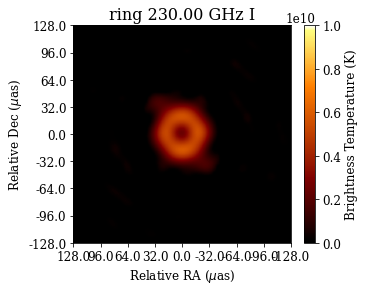

2023-11-22 09:22:58,270 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:22:58,270 INFO Display              :: Penalty--> 501.6603517305439
2023-11-22 09:22:58,566 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:22:58,570 INFO Display              :: Penalty--> 501.6603517305439
2023-11-22 09:22:58,879 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:22:58,887 INFO Display              :: Penalty--> 501.6603517305439
2023-11-22 09:22:59,168 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:22:59,171 INFO Display              :: Penalty--> 501.6603517305439
2023-11-22 09:22:59,472 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:22:59,480 INFO Display              :: Penalty--> 501.6603517305439
2023-11-22 09:22:59,785 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:22:59,785 INFO Display              :: Penalty--> 501.6603517305439
2023-11-22 09:23:00,092 INFO CountIterations      :: iteration = 7 / 25
2023

2997.874247195565
Data Fidelity:  6.458027098059943


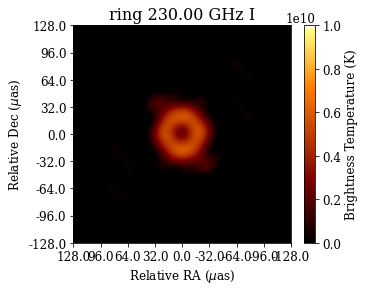

2023-11-22 09:23:06,610 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:23:06,618 INFO Display              :: Penalty--> 501.32939948621345
2023-11-22 09:23:06,899 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:23:06,907 INFO Display              :: Penalty--> 501.3186741445394
2023-11-22 09:23:07,212 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:23:07,220 INFO Display              :: Penalty--> 501.3186741445394
2023-11-22 09:23:07,508 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:23:07,516 INFO Display              :: Penalty--> 501.3186741445394
2023-11-22 09:23:07,829 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:23:07,837 INFO Display              :: Penalty--> 501.30794880286527
2023-11-22 09:23:08,141 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:23:08,149 INFO Display              :: Penalty--> 501.2972234611912
2023-11-22 09:23:08,445 INFO CountIterations      :: iteration = 7 / 25
20

2997.8718430506415
Data Fidelity:  6.34052812788025


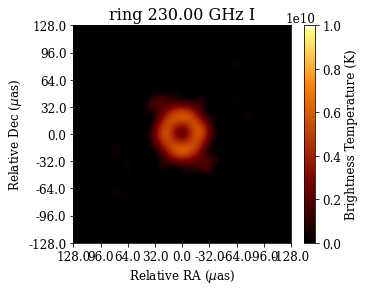

2023-11-22 09:23:15,010 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:23:15,014 INFO Display              :: Penalty--> 501.2665796278367
2023-11-22 09:23:15,328 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:23:15,336 INFO Display              :: Penalty--> 501.2665796278367
2023-11-22 09:23:15,625 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:23:15,625 INFO Display              :: Penalty--> 501.2665796278367
2023-11-22 09:23:15,922 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:23:15,930 INFO Display              :: Penalty--> 501.2665796278367
2023-11-22 09:23:16,276 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:23:16,284 INFO Display              :: Penalty--> 501.2665796278367
2023-11-22 09:23:16,588 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:23:16,588 INFO Display              :: Penalty--> 501.2665796278367
2023-11-22 09:23:16,878 INFO CountIterations      :: iteration = 7 / 25
2023

2997.9351532101737
Data Fidelity:  6.227755390725766


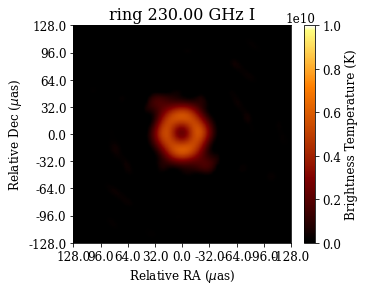

In [7]:
tau = 1

for i in range(3):
    #blur image to help global convergence
    img = img.blur_circ(res)
    data = handler.convert.ehtim_to_numpy(img)/rescaling

    #run mminimization
    wtfcts, img = handler.second_round_minimization(img.copy(), alpha, tau, maxiter=50, display=True)

    reco = handler.op(wtfcts)
    img = handler.wrapper.formatoutput(np.maximum(0, reco))


During the hard-threshold forward-backward splitting iterations of DoG-HiT effectively a mutliresolution support is computed, i.e. a set of all wavelet coefficients that are statistically significant to represent the information in the image. The multiresolution support is computed by the command handler.find_projection and stored as a projection operator handler.coordinate_proj. Note that handler.find_projection is called automatically internally when the last imaging round was done with the shortened handler.second_round_minimization command. 

The multiresolution support could be used to refine the reconstruction result. We minimize the data fidelity term specified by "data_term" without penalization by a gradient descent method. We have seen in tutorial 2 that this gives rise to spurious image artifacts. However, this time we only vary the wavelet coefficients in the multiresolution support (i.e. only the significant ones) which suppresses all possible artifacts during imaging.

The multiresolution support constrained gradient descent algorithm is done by the command handler.third_round. The stepsize parameter tau is found automatically by checkijgn convergence, only a start value has to be provided. Indeed, the procedure is converging (decreasing data fidelity) and improves the reconstruction.

In [8]:
wtfcts, img, tau = handler.third_round(wtfcts, data_term, tau=10, maxit=1000)

2023-11-22 09:24:32,002 INFO CountIterations      :: iteration = 1 / 5
2023-11-22 09:24:32,181 INFO Display              :: Data Fidelity--> 35.8351286990754
2023-11-22 09:24:32,580 INFO CountIterations      :: iteration = 2 / 5
2023-11-22 09:24:32,752 INFO Display              :: Data Fidelity--> 383.2097768883759
2023-11-22 09:24:33,154 INFO CountIterations      :: iteration = 3 / 5
2023-11-22 09:24:33,329 INFO Display              :: Data Fidelity--> 15855.972246969672
2023-11-22 09:24:33,725 INFO CountIterations      :: iteration = 4 / 5
2023-11-22 09:24:33,902 INFO Display              :: Data Fidelity--> 4760.98117091099
2023-11-22 09:24:34,334 INFO CountIterations      :: iteration = 5 / 5
2023-11-22 09:24:34,334 INFO CombineRules         :: Rule CountIterations(max_iterations=5) triggered.
2023-11-22 09:24:34,334 INFO Gradient_Descent     :: Stopping rule triggered.


Stepsize to big, try to run with smaller stepsize


2023-11-22 09:24:34,954 INFO CountIterations      :: iteration = 1 / 5
2023-11-22 09:24:35,148 INFO Display              :: Data Fidelity--> 28.016171582030196
2023-11-22 09:24:35,562 INFO CountIterations      :: iteration = 2 / 5
2023-11-22 09:24:35,750 INFO Display              :: Data Fidelity--> 159.67100215945385
2023-11-22 09:24:36,149 INFO CountIterations      :: iteration = 3 / 5
2023-11-22 09:24:36,335 INFO Display              :: Data Fidelity--> 7233.743417375446
2023-11-22 09:24:36,742 INFO CountIterations      :: iteration = 4 / 5
2023-11-22 09:24:36,936 INFO Display              :: Data Fidelity--> 4230.481772391209
2023-11-22 09:24:37,344 INFO CountIterations      :: iteration = 5 / 5
2023-11-22 09:24:37,344 INFO CombineRules         :: Rule CountIterations(max_iterations=5) triggered.
2023-11-22 09:24:37,350 INFO Gradient_Descent     :: Stopping rule triggered.


Stepsize to big, try to run with smaller stepsize


2023-11-22 09:24:37,988 INFO CountIterations      :: iteration = 1 / 5
2023-11-22 09:24:38,177 INFO Display              :: Data Fidelity--> 26.22561014098578
2023-11-22 09:24:38,563 INFO CountIterations      :: iteration = 2 / 5
2023-11-22 09:24:38,749 INFO Display              :: Data Fidelity--> 44.39140086184526
2023-11-22 09:24:39,138 INFO CountIterations      :: iteration = 3 / 5
2023-11-22 09:24:39,316 INFO Display              :: Data Fidelity--> 345.6949931113687
2023-11-22 09:24:39,737 INFO CountIterations      :: iteration = 4 / 5
2023-11-22 09:24:39,911 INFO Display              :: Data Fidelity--> 147.95527039242626
2023-11-22 09:24:40,324 INFO CountIterations      :: iteration = 5 / 5
2023-11-22 09:24:40,324 INFO CombineRules         :: Rule CountIterations(max_iterations=5) triggered.
2023-11-22 09:24:40,324 INFO Gradient_Descent     :: Stopping rule triggered.


Stepsize to big, try to run with smaller stepsize


2023-11-22 09:24:40,960 INFO CountIterations      :: iteration = 1 / 5
2023-11-22 09:24:41,132 INFO Display              :: Data Fidelity--> 26.1511897072759
2023-11-22 09:24:41,553 INFO CountIterations      :: iteration = 2 / 5
2023-11-22 09:24:41,732 INFO Display              :: Data Fidelity--> 26.237721715804145
2023-11-22 09:24:42,112 INFO CountIterations      :: iteration = 3 / 5
2023-11-22 09:24:42,286 INFO Display              :: Data Fidelity--> 32.718421818865956
2023-11-22 09:24:42,721 INFO CountIterations      :: iteration = 4 / 5
2023-11-22 09:24:42,893 INFO Display              :: Data Fidelity--> 68.86683716555554
2023-11-22 09:24:43,293 INFO CountIterations      :: iteration = 5 / 5
2023-11-22 09:24:43,296 INFO CombineRules         :: Rule CountIterations(max_iterations=5) triggered.
2023-11-22 09:24:43,296 INFO Gradient_Descent     :: Stopping rule triggered.


Stepsize to big, try to run with smaller stepsize


2023-11-22 09:24:43,959 INFO CountIterations      :: iteration = 1 / 5
2023-11-22 09:24:44,146 INFO Display              :: Data Fidelity--> 26.39138093262407
2023-11-22 09:24:44,581 INFO CountIterations      :: iteration = 2 / 5
2023-11-22 09:24:44,776 INFO Display              :: Data Fidelity--> 26.04182379585396
2023-11-22 09:24:45,191 INFO CountIterations      :: iteration = 3 / 5
2023-11-22 09:24:45,352 INFO Display              :: Data Fidelity--> 25.74102174817073
2023-11-22 09:24:45,757 INFO CountIterations      :: iteration = 4 / 5
2023-11-22 09:24:45,936 INFO Display              :: Data Fidelity--> 25.46081103504091
2023-11-22 09:24:46,345 INFO CountIterations      :: iteration = 5 / 5
2023-11-22 09:24:46,348 INFO CombineRules         :: Rule CountIterations(max_iterations=5) triggered.
2023-11-22 09:24:46,349 INFO Gradient_Descent     :: Stopping rule triggered.
2023-11-22 09:24:46,997 INFO CountIterations      :: iteration = 1 / 5
2023-11-22 09:24:47,183 INFO Display     

2023-11-22 09:25:12,409 INFO Display              :: Data Fidelity--> 20.436690344247857
2023-11-22 09:25:12,817 INFO CountIterations      :: iteration = 30 / 1000
2023-11-22 09:25:12,989 INFO Display              :: Data Fidelity--> 20.27669024251861
2023-11-22 09:25:13,405 INFO CountIterations      :: iteration = 31 / 1000
2023-11-22 09:25:13,576 INFO Display              :: Data Fidelity--> 20.118903844317046
2023-11-22 09:25:13,978 INFO CountIterations      :: iteration = 32 / 1000
2023-11-22 09:25:14,156 INFO Display              :: Data Fidelity--> 19.963275628711884
2023-11-22 09:25:14,568 INFO CountIterations      :: iteration = 33 / 1000
2023-11-22 09:25:14,745 INFO Display              :: Data Fidelity--> 19.8097526557003
2023-11-22 09:25:15,152 INFO CountIterations      :: iteration = 34 / 1000
2023-11-22 09:25:15,329 INFO Display              :: Data Fidelity--> 19.658284368430596
2023-11-22 09:25:15,749 INFO CountIterations      :: iteration = 35 / 1000
2023-11-22 09:25:15

2023-11-22 09:25:43,204 INFO CountIterations      :: iteration = 80 / 1000
2023-11-22 09:25:43,392 INFO Display              :: Data Fidelity--> 14.329830252840981
2023-11-22 09:25:43,831 INFO CountIterations      :: iteration = 81 / 1000
2023-11-22 09:25:44,026 INFO Display              :: Data Fidelity--> 14.240855484123168
2023-11-22 09:25:44,456 INFO CountIterations      :: iteration = 82 / 1000
2023-11-22 09:25:44,653 INFO Display              :: Data Fidelity--> 14.152756244615489
2023-11-22 09:25:45,078 INFO CountIterations      :: iteration = 83 / 1000
2023-11-22 09:25:45,273 INFO Display              :: Data Fidelity--> 14.065520222912385
2023-11-22 09:25:45,683 INFO CountIterations      :: iteration = 84 / 1000
2023-11-22 09:25:45,868 INFO Display              :: Data Fidelity--> 13.97913535611216
2023-11-22 09:25:46,289 INFO CountIterations      :: iteration = 85 / 1000
2023-11-22 09:25:46,483 INFO Display              :: Data Fidelity--> 13.89358982265718
2023-11-22 09:25:4

2023-11-22 09:26:13,728 INFO CountIterations      :: iteration = 130 / 1000
2023-11-22 09:26:13,921 INFO Display              :: Data Fidelity--> 10.757786403915363
2023-11-22 09:26:14,356 INFO CountIterations      :: iteration = 131 / 1000
2023-11-22 09:26:14,545 INFO Display              :: Data Fidelity--> 10.701163033234714
2023-11-22 09:26:14,980 INFO CountIterations      :: iteration = 132 / 1000
2023-11-22 09:26:15,174 INFO Display              :: Data Fidelity--> 10.645008071515363
2023-11-22 09:26:15,611 INFO CountIterations      :: iteration = 133 / 1000
2023-11-22 09:26:15,802 INFO Display              :: Data Fidelity--> 10.589316309014647
2023-11-22 09:26:16,232 INFO CountIterations      :: iteration = 134 / 1000
2023-11-22 09:26:16,400 INFO Display              :: Data Fidelity--> 10.534082612613961
2023-11-22 09:26:16,811 INFO CountIterations      :: iteration = 135 / 1000
2023-11-22 09:26:16,996 INFO Display              :: Data Fidelity--> 10.479301924349127
2023-11-22

2023-11-22 09:26:43,983 INFO CountIterations      :: iteration = 180 / 1000
2023-11-22 09:26:44,168 INFO Display              :: Data Fidelity--> 8.413324542433434
2023-11-22 09:26:44,584 INFO CountIterations      :: iteration = 181 / 1000
2023-11-22 09:26:44,774 INFO Display              :: Data Fidelity--> 8.374965555254285
2023-11-22 09:26:45,198 INFO CountIterations      :: iteration = 182 / 1000
2023-11-22 09:26:45,386 INFO Display              :: Data Fidelity--> 8.336886052280084
2023-11-22 09:26:45,807 INFO CountIterations      :: iteration = 183 / 1000
2023-11-22 09:26:46,002 INFO Display              :: Data Fidelity--> 8.299083373902352
2023-11-22 09:26:46,424 INFO CountIterations      :: iteration = 184 / 1000
2023-11-22 09:26:46,593 INFO Display              :: Data Fidelity--> 8.261554892916626
2023-11-22 09:26:47,023 INFO CountIterations      :: iteration = 185 / 1000
2023-11-22 09:26:47,212 INFO Display              :: Data Fidelity--> 8.224298014025786
2023-11-22 09:26

2023-11-22 09:27:14,652 INFO CountIterations      :: iteration = 230 / 1000
2023-11-22 09:27:14,838 INFO Display              :: Data Fidelity--> 6.792155528844077
2023-11-22 09:27:15,260 INFO CountIterations      :: iteration = 231 / 1000
2023-11-22 09:27:15,441 INFO Display              :: Data Fidelity--> 6.765050409586748
2023-11-22 09:27:15,888 INFO CountIterations      :: iteration = 232 / 1000
2023-11-22 09:27:16,085 INFO Display              :: Data Fidelity--> 6.7381235351652755
2023-11-22 09:27:16,540 INFO CountIterations      :: iteration = 233 / 1000
2023-11-22 09:27:16,742 INFO Display              :: Data Fidelity--> 6.711373402013625
2023-11-22 09:27:17,170 INFO CountIterations      :: iteration = 234 / 1000
2023-11-22 09:27:17,356 INFO Display              :: Data Fidelity--> 6.684798522452171
2023-11-22 09:27:17,793 INFO CountIterations      :: iteration = 235 / 1000
2023-11-22 09:27:17,979 INFO Display              :: Data Fidelity--> 6.658397424479565
2023-11-22 09:2

2023-11-22 09:27:45,439 INFO CountIterations      :: iteration = 280 / 1000
2023-11-22 09:27:45,651 INFO Display              :: Data Fidelity--> 5.6290446186316
2023-11-22 09:27:46,088 INFO CountIterations      :: iteration = 281 / 1000
2023-11-22 09:27:46,281 INFO Display              :: Data Fidelity--> 5.609279490698645
2023-11-22 09:27:46,706 INFO CountIterations      :: iteration = 282 / 1000
2023-11-22 09:27:46,884 INFO Display              :: Data Fidelity--> 5.589633462360184
2023-11-22 09:27:47,304 INFO CountIterations      :: iteration = 283 / 1000
2023-11-22 09:27:47,507 INFO Display              :: Data Fidelity--> 5.570105622497538
2023-11-22 09:27:47,919 INFO CountIterations      :: iteration = 284 / 1000
2023-11-22 09:27:48,104 INFO Display              :: Data Fidelity--> 5.55069506856306
2023-11-22 09:27:48,532 INFO CountIterations      :: iteration = 285 / 1000
2023-11-22 09:27:48,734 INFO Display              :: Data Fidelity--> 5.531400906481561
2023-11-22 09:27:49

2023-11-22 09:28:16,235 INFO CountIterations      :: iteration = 330 / 1000
2023-11-22 09:28:16,428 INFO Display              :: Data Fidelity--> 4.770612152219001
2023-11-22 09:28:16,849 INFO CountIterations      :: iteration = 331 / 1000
2023-11-22 09:28:17,031 INFO Display              :: Data Fidelity--> 4.755833763752319
2023-11-22 09:28:17,447 INFO CountIterations      :: iteration = 332 / 1000
2023-11-22 09:28:17,646 INFO Display              :: Data Fidelity--> 4.74113776058438
2023-11-22 09:28:18,060 INFO CountIterations      :: iteration = 333 / 1000
2023-11-22 09:28:18,253 INFO Display              :: Data Fidelity--> 4.726523561850641
2023-11-22 09:28:18,662 INFO CountIterations      :: iteration = 334 / 1000
2023-11-22 09:28:18,832 INFO Display              :: Data Fidelity--> 4.7119905916473
2023-11-22 09:28:19,268 INFO CountIterations      :: iteration = 335 / 1000
2023-11-22 09:28:19,456 INFO Display              :: Data Fidelity--> 4.697538278980147
2023-11-22 09:28:19

2023-11-22 09:28:46,788 INFO CountIterations      :: iteration = 380 / 1000
2023-11-22 09:28:46,975 INFO Display              :: Data Fidelity--> 4.122273198231202
2023-11-22 09:28:47,411 INFO CountIterations      :: iteration = 381 / 1000
2023-11-22 09:28:47,617 INFO Display              :: Data Fidelity--> 4.110989187412935
2023-11-22 09:28:48,037 INFO CountIterations      :: iteration = 382 / 1000
2023-11-22 09:28:48,212 INFO Display              :: Data Fidelity--> 4.099763722380756
2023-11-22 09:28:48,636 INFO CountIterations      :: iteration = 383 / 1000
2023-11-22 09:28:48,820 INFO Display              :: Data Fidelity--> 4.0885964182603045
2023-11-22 09:28:49,236 INFO CountIterations      :: iteration = 384 / 1000
2023-11-22 09:28:49,428 INFO Display              :: Data Fidelity--> 4.077486893206087
2023-11-22 09:28:49,856 INFO CountIterations      :: iteration = 385 / 1000
2023-11-22 09:28:50,050 INFO Display              :: Data Fidelity--> 4.066434768373052
2023-11-22 09:2

2023-11-22 09:29:17,223 INFO CountIterations      :: iteration = 430 / 1000
2023-11-22 09:29:17,410 INFO Display              :: Data Fidelity--> 3.622889774305893
2023-11-22 09:29:17,839 INFO CountIterations      :: iteration = 431 / 1000
2023-11-22 09:29:18,030 INFO Display              :: Data Fidelity--> 3.614115021909405
2023-11-22 09:29:18,446 INFO CountIterations      :: iteration = 432 / 1000
2023-11-22 09:29:18,634 INFO Display              :: Data Fidelity--> 3.6053827906432905
2023-11-22 09:29:19,066 INFO CountIterations      :: iteration = 433 / 1000
2023-11-22 09:29:19,237 INFO Display              :: Data Fidelity--> 3.5966928176690334
2023-11-22 09:29:19,689 INFO CountIterations      :: iteration = 434 / 1000
2023-11-22 09:29:19,885 INFO Display              :: Data Fidelity--> 3.5880448420762017
2023-11-22 09:29:20,302 INFO CountIterations      :: iteration = 435 / 1000
2023-11-22 09:29:20,491 INFO Display              :: Data Fidelity--> 3.5794386048658478
2023-11-22 0

2023-11-22 09:29:48,027 INFO CountIterations      :: iteration = 480 / 1000
2023-11-22 09:29:48,216 INFO Display              :: Data Fidelity--> 3.231500177936561
2023-11-22 09:29:48,627 INFO CountIterations      :: iteration = 481 / 1000
2023-11-22 09:29:48,812 INFO Display              :: Data Fidelity--> 3.224563790963542
2023-11-22 09:29:49,256 INFO CountIterations      :: iteration = 482 / 1000
2023-11-22 09:29:49,444 INFO Display              :: Data Fidelity--> 3.2176588539311606
2023-11-22 09:29:49,872 INFO CountIterations      :: iteration = 483 / 1000
2023-11-22 09:29:50,049 INFO Display              :: Data Fidelity--> 3.2107851829167546
2023-11-22 09:29:50,488 INFO CountIterations      :: iteration = 484 / 1000
2023-11-22 09:29:50,685 INFO Display              :: Data Fidelity--> 3.2039425952667235
2023-11-22 09:29:51,127 INFO CountIterations      :: iteration = 485 / 1000
2023-11-22 09:29:51,329 INFO Display              :: Data Fidelity--> 3.197130909586125
2023-11-22 09

2023-11-22 09:30:18,893 INFO CountIterations      :: iteration = 530 / 1000
2023-11-22 09:30:19,106 INFO Display              :: Data Fidelity--> 2.9198741661572667
2023-11-22 09:30:19,539 INFO CountIterations      :: iteration = 531 / 1000
2023-11-22 09:30:19,705 INFO Display              :: Data Fidelity--> 2.9143076796216643
2023-11-22 09:30:20,109 INFO CountIterations      :: iteration = 532 / 1000
2023-11-22 09:30:20,288 INFO Display              :: Data Fidelity--> 2.908764821330486
2023-11-22 09:30:20,722 INFO CountIterations      :: iteration = 533 / 1000
2023-11-22 09:30:20,917 INFO Display              :: Data Fidelity--> 2.9032454599629327
2023-11-22 09:30:21,338 INFO CountIterations      :: iteration = 534 / 1000
2023-11-22 09:30:21,540 INFO Display              :: Data Fidelity--> 2.897749465055892
2023-11-22 09:30:21,959 INFO CountIterations      :: iteration = 535 / 1000
2023-11-22 09:30:22,145 INFO Display              :: Data Fidelity--> 2.892276706997435
2023-11-22 09

2023-11-22 09:30:44,322 INFO CountIterations      :: iteration = 580 / 1000
2023-11-22 09:30:44,392 INFO Display              :: Data Fidelity--> 2.668105109685561
2023-11-22 09:30:44,535 INFO CountIterations      :: iteration = 581 / 1000
2023-11-22 09:30:44,605 INFO Display              :: Data Fidelity--> 2.6635745874463943
2023-11-22 09:30:44,738 INFO CountIterations      :: iteration = 582 / 1000
2023-11-22 09:30:44,803 INFO Display              :: Data Fidelity--> 2.6590620620628074
2023-11-22 09:30:44,939 INFO CountIterations      :: iteration = 583 / 1000
2023-11-22 09:30:45,005 INFO Display              :: Data Fidelity--> 2.654567438080833
2023-11-22 09:30:45,147 INFO CountIterations      :: iteration = 584 / 1000
2023-11-22 09:30:45,215 INFO Display              :: Data Fidelity--> 2.6500906206356456
2023-11-22 09:30:45,360 INFO CountIterations      :: iteration = 585 / 1000
2023-11-22 09:30:45,426 INFO Display              :: Data Fidelity--> 2.645631515447107
2023-11-22 09

2023-11-22 09:30:54,928 INFO CountIterations      :: iteration = 630 / 1000
2023-11-22 09:30:54,991 INFO Display              :: Data Fidelity--> 2.4618809818654643
2023-11-22 09:30:55,137 INFO CountIterations      :: iteration = 631 / 1000
2023-11-22 09:30:55,206 INFO Display              :: Data Fidelity--> 2.458143954495108
2023-11-22 09:30:55,343 INFO CountIterations      :: iteration = 632 / 1000
2023-11-22 09:30:55,412 INFO Display              :: Data Fidelity--> 2.454420791927208
2023-11-22 09:30:55,556 INFO CountIterations      :: iteration = 633 / 1000
2023-11-22 09:30:55,625 INFO Display              :: Data Fidelity--> 2.450711423189407
2023-11-22 09:30:55,756 INFO CountIterations      :: iteration = 634 / 1000
2023-11-22 09:30:55,820 INFO Display              :: Data Fidelity--> 2.4470157777011696
2023-11-22 09:30:55,946 INFO CountIterations      :: iteration = 635 / 1000
2023-11-22 09:30:56,013 INFO Display              :: Data Fidelity--> 2.4433337852699273
2023-11-22 09

2023-11-22 09:31:05,169 INFO CountIterations      :: iteration = 680 / 1000
2023-11-22 09:31:05,242 INFO Display              :: Data Fidelity--> 2.2907046858379565
2023-11-22 09:31:05,400 INFO CountIterations      :: iteration = 681 / 1000
2023-11-22 09:31:05,467 INFO Display              :: Data Fidelity--> 2.2875806963832996
2023-11-22 09:31:05,616 INFO CountIterations      :: iteration = 682 / 1000
2023-11-22 09:31:05,681 INFO Display              :: Data Fidelity--> 2.2844674201963056
2023-11-22 09:31:05,829 INFO CountIterations      :: iteration = 683 / 1000
2023-11-22 09:31:05,893 INFO Display              :: Data Fidelity--> 2.281364800328951
2023-11-22 09:31:06,031 INFO CountIterations      :: iteration = 684 / 1000
2023-11-22 09:31:06,091 INFO Display              :: Data Fidelity--> 2.278272779952236
2023-11-22 09:31:06,228 INFO CountIterations      :: iteration = 685 / 1000
2023-11-22 09:31:06,290 INFO Display              :: Data Fidelity--> 2.275191302346195
2023-11-22 09

2023-11-22 09:31:15,439 INFO CountIterations      :: iteration = 730 / 1000
2023-11-22 09:31:15,510 INFO Display              :: Data Fidelity--> 2.1465071195055136
2023-11-22 09:31:15,647 INFO CountIterations      :: iteration = 731 / 1000
2023-11-22 09:31:15,714 INFO Display              :: Data Fidelity--> 2.14384727804395
2023-11-22 09:31:15,859 INFO CountIterations      :: iteration = 732 / 1000
2023-11-22 09:31:15,926 INFO Display              :: Data Fidelity--> 2.1411950210278325
2023-11-22 09:31:16,068 INFO CountIterations      :: iteration = 733 / 1000
2023-11-22 09:31:16,135 INFO Display              :: Data Fidelity--> 2.1385502592729075
2023-11-22 09:31:16,277 INFO CountIterations      :: iteration = 734 / 1000
2023-11-22 09:31:16,347 INFO Display              :: Data Fidelity--> 2.1359129006511743
2023-11-22 09:31:16,488 INFO CountIterations      :: iteration = 735 / 1000
2023-11-22 09:31:16,558 INFO Display              :: Data Fidelity--> 2.1332828498484773
2023-11-22 0

2023-11-22 09:31:25,888 INFO CountIterations      :: iteration = 780 / 1000
2023-11-22 09:31:25,954 INFO Display              :: Data Fidelity--> 2.019663676528917
2023-11-22 09:31:26,098 INFO CountIterations      :: iteration = 781 / 1000
2023-11-22 09:31:26,163 INFO Display              :: Data Fidelity--> 2.0171678809844873
2023-11-22 09:31:26,326 INFO CountIterations      :: iteration = 782 / 1000
2023-11-22 09:31:26,397 INFO Display              :: Data Fidelity--> 2.0146751572101467
2023-11-22 09:31:26,537 INFO CountIterations      :: iteration = 783 / 1000
2023-11-22 09:31:26,606 INFO Display              :: Data Fidelity--> 2.012186606613942
2023-11-22 09:31:26,755 INFO CountIterations      :: iteration = 784 / 1000
2023-11-22 09:31:26,826 INFO Display              :: Data Fidelity--> 2.0097033672514293
2023-11-22 09:31:26,984 INFO CountIterations      :: iteration = 785 / 1000
2023-11-22 09:31:27,049 INFO Display              :: Data Fidelity--> 2.0072265774053255
2023-11-22 0

2023-11-22 09:31:36,275 INFO CountIterations      :: iteration = 830 / 1000
2023-11-22 09:31:36,340 INFO Display              :: Data Fidelity--> 1.9070493264367943
2023-11-22 09:31:36,475 INFO CountIterations      :: iteration = 831 / 1000
2023-11-22 09:31:36,547 INFO Display              :: Data Fidelity--> 1.9050382045130032
2023-11-22 09:31:36,689 INFO CountIterations      :: iteration = 832 / 1000
2023-11-22 09:31:36,747 INFO Display              :: Data Fidelity--> 1.9030343528013396
2023-11-22 09:31:36,890 INFO CountIterations      :: iteration = 833 / 1000
2023-11-22 09:31:36,962 INFO Display              :: Data Fidelity--> 1.901037688242055
2023-11-22 09:31:37,114 INFO CountIterations      :: iteration = 834 / 1000
2023-11-22 09:31:37,178 INFO Display              :: Data Fidelity--> 1.8990481307876386
2023-11-22 09:31:37,328 INFO CountIterations      :: iteration = 835 / 1000
2023-11-22 09:31:37,393 INFO Display              :: Data Fidelity--> 1.8970656032320448
2023-11-22 

2023-11-22 09:31:46,808 INFO CountIterations      :: iteration = 880 / 1000
2023-11-22 09:31:46,876 INFO Display              :: Data Fidelity--> 1.8142248795725968
2023-11-22 09:31:47,036 INFO CountIterations      :: iteration = 881 / 1000
2023-11-22 09:31:47,109 INFO Display              :: Data Fidelity--> 1.8125104847851539
2023-11-22 09:31:47,247 INFO CountIterations      :: iteration = 882 / 1000
2023-11-22 09:31:47,314 INFO Display              :: Data Fidelity--> 1.8108010735674636
2023-11-22 09:31:47,448 INFO CountIterations      :: iteration = 883 / 1000
2023-11-22 09:31:47,513 INFO Display              :: Data Fidelity--> 1.8090966189034188
2023-11-22 09:31:47,665 INFO CountIterations      :: iteration = 884 / 1000
2023-11-22 09:31:47,722 INFO Display              :: Data Fidelity--> 1.807397094119997
2023-11-22 09:31:47,856 INFO CountIterations      :: iteration = 885 / 1000
2023-11-22 09:31:47,921 INFO Display              :: Data Fidelity--> 1.8057024728771445
2023-11-22 

2023-11-22 09:31:57,334 INFO CountIterations      :: iteration = 930 / 1000
2023-11-22 09:31:57,402 INFO Display              :: Data Fidelity--> 1.734143414182936
2023-11-22 09:31:57,545 INFO CountIterations      :: iteration = 931 / 1000
2023-11-22 09:31:57,614 INFO Display              :: Data Fidelity--> 1.7326501729124306
2023-11-22 09:31:57,763 INFO CountIterations      :: iteration = 932 / 1000
2023-11-22 09:31:57,836 INFO Display              :: Data Fidelity--> 1.731160854804112
2023-11-22 09:31:57,986 INFO CountIterations      :: iteration = 933 / 1000
2023-11-22 09:31:58,058 INFO Display              :: Data Fidelity--> 1.729675442871062
2023-11-22 09:31:58,210 INFO CountIterations      :: iteration = 934 / 1000
2023-11-22 09:31:58,270 INFO Display              :: Data Fidelity--> 1.7281939202445395
2023-11-22 09:31:58,421 INFO CountIterations      :: iteration = 935 / 1000
2023-11-22 09:31:58,493 INFO Display              :: Data Fidelity--> 1.726716270172286
2023-11-22 09:

2023-11-22 09:32:08,186 INFO CountIterations      :: iteration = 980 / 1000
2023-11-22 09:32:08,254 INFO Display              :: Data Fidelity--> 1.66397846805368
2023-11-22 09:32:08,393 INFO CountIterations      :: iteration = 981 / 1000
2023-11-22 09:32:08,459 INFO Display              :: Data Fidelity--> 1.6626625748527757
2023-11-22 09:32:08,612 INFO CountIterations      :: iteration = 982 / 1000
2023-11-22 09:32:08,684 INFO Display              :: Data Fidelity--> 1.6613498746391206
2023-11-22 09:32:08,828 INFO CountIterations      :: iteration = 983 / 1000
2023-11-22 09:32:08,900 INFO Display              :: Data Fidelity--> 1.6600403548677303
2023-11-22 09:32:09,054 INFO CountIterations      :: iteration = 984 / 1000
2023-11-22 09:32:09,115 INFO Display              :: Data Fidelity--> 1.658734003061237
2023-11-22 09:32:09,248 INFO CountIterations      :: iteration = 985 / 1000
2023-11-22 09:32:09,314 INFO Display              :: Data Fidelity--> 1.6574308068093002
2023-11-22 09

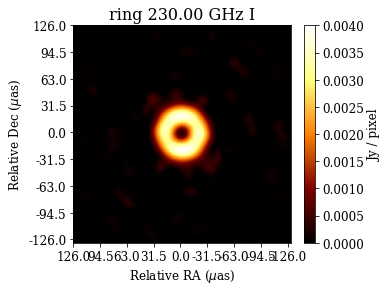

Final data fidelity term:  0.8093332202144508


In [9]:
img.display(cbar_lims=[0,0.004])

#print score
print("Final data fidelity term: ", handler.data_fidelity_closure(wtfcts))